In [1]:
# !pip install scipy
# !pip install ruptures

# imports

In [1]:
import pandas as pd
from scipy.io import arff
import matplotlib.pyplot as plt
import numpy as np
import ruptures as rpt
from fluss import *
from evaluation import *
from math import floor

# Dataset loading

In [2]:
filepath = './datasets/basic_motions/BasicMotions_TRAIN.arff'

def load_dataset_to_dataframe(path):
    """Load data that is stored within the path

    Args:
        path: string with path containing data
    Returns:
        A pandas dataframe with only data inside
    """
    dataset = arff.loadarff(path)
    df = pd.DataFrame(dataset[0])
    return df 



# these function allows to load dataset from .arff file, each function is designed for diffrent represenation
def stack_time_series_randomly(df, shuffle, seed, block_size, group):
    """This function creates new dataframe without segmentation and classification, what is more its rows are randomly shuffled

    Args:
        df: segmented dataframe
        seed: this value is being passed to the sample function which shuffles rows in dataframe
    Returns:
        A pandas dataframe with shape [dimensions of input data,original count of time series]
        , numpy array containing change points
    """
    #print( df.iloc[0,0].shape)
    dimensionality = df.iloc[0,0].shape[0] if type(df.iloc[0,0][0]) == np.void else 1  # assumption that data dimensionality is the number of rows of first element in dataframe
    
    change_points = np.array([],dtype=int)
    chunk_size = len(df.iloc[0,0][0])

    # creating new data frame 
    stacked = pd.DataFrame(index=np.arange(dimensionality), columns=np.arange(1))

    # randomize rows
    if(shuffle == True):
        # Krok 1: Podziel dataframe na bloki
        blocks = [df.iloc[i:i + block_size] for i in range(0, len(df), block_size)]
        
        # Krok 2: Wymieszaj kolejność bloków
        np.random.seed(seed)
        shuffled_indices = np.random.permutation(len(blocks))
        shuffled_blocks = [blocks[i] for i in shuffled_indices]
        
        # Krok 3: Połącz bloki z powrotem w jeden dataframe
        df = pd.concat(shuffled_blocks).reset_index(drop=True)
        #df = df.sample(frac=1, random_state=seed).reset_index(drop=True)
    # filling it with empty numpy arrays
    #print(dimensionality)
    for i in range(dimensionality):
        stacked.iloc[i, 0] = np.array([])

    last_class = df.iloc[0,1]
    # filling the dataframe with data    
    for index, row in df.iterrows():
        i = 0
        if last_class != row[1]:
            change_points = np.append(change_points,int(index*chunk_size))
        last_class = row[1]
        if type(row[0][0]) == np.void:
            for r in row[0]:
                #print((type(r))==np.void)
                stacked.iloc[i,0] = np.concatenate((stacked.iloc[i,0],np.array(r.tolist())))
                i += 1
        else:
             stacked.iloc[0,0] = np.concatenate((stacked.iloc[i,0],row[0]))
    return stacked, change_points

# random_stacked, change_points = stack_time_series_randomly(df,True)
# random_stacked = dataframe_to_ndarray(random_stacked)

# plt.plot(random_stacked)
# plt.show()
# shuffled_df = df.sample(frac=1, random_state=42).reset_index(drop=True)
# print("\nPomieszany DataFrame:")
#print(random_stacked)

def load_data_multivariate_representation(filepath, seed, block_size, group, shuffle):
        """ Load data from filepath to numpy array. The data is assumed to be multivariate time series in .arff file.
    
        Args:
            filepath: path to .arff file containing time series
            seed: seed for dataset shuffle randomization
            block_size: number of rows in original dataset which will make for a size of chunk for dataset shuffling if group is set to True
            group: bool, if set to true the output data will be grouped (each class will be in only one segment)
            shuffle: bool, if set to true, applies shuffling rows in groups of block_size, it takes part after (optional) grouping 
        Returns:
            data: flattend 2d numpy array containing time series
            original_points: list of change points
            window_size: number representing length of a basic pattern in dataset or a size of chunk in original dataset
        """
        df = load_dataset_to_dataframe(filepath)
        window_size = len(df.iloc[0,0][0])

        data, original_points = stack_time_series_randomly(df, shuffle, seed, block_size, group)
        data = dataframe_to_ndarray(data)
    
        return data, original_points, window_size


def load_data_univariate_representation(filepath, seed, block_size, group, shuffle):
    """ Load data from filepath to numpy array. The data is assumed to be univariate time series in .arff file.

    Args:
        filepath: path to .arff file containing time series
        seed: seed for dataset shuffle randomization
        block_size: number of rows in original dataset which will make for a size of chunk for dataset shuffling if group is set to True
        group: bool, if set to true the output data will be grouped (each class will be in only one segment)
        shuffle: bool, if set to true, applies shuffling rows in groups of block_size, it takes part after (optional) grouping 
    Returns:
        data: flattend 2d numpy array containing time series
        original_points: list of change points
        window_size: number representing length of a basic pattern in dataset or a size of chunk in original dataset
    """
    df = load_dataset_to_dataframe(filepath)
    #print(df)    
    if group:
        #print("grupowanie")
        df = df.sort_values(by = df.columns[-1]).reset_index(drop=True)
        #print(df)
    if shuffle:
        #print("shufflowanie")
            # Krok 1: Podziel dataframe na bloki
        blocks = [df.iloc[i:i + block_size,:] for i in range(0, len(df), block_size)]
            
            # Krok 2: Wymieszaj kolejność bloków
        np.random.seed(seed)
        shuffled_indices = np.random.permutation(len(blocks))
        #print(shuffled_indices)
        shuffled_blocks = [blocks[i] for i in shuffled_indices]
            
            # Krok 3: Połącz bloki z powrotem w jeden dataframe
        df = pd.concat(shuffled_blocks).reset_index(drop=True)    # Initialize the flattened data array and original points list
        #print(df)
        
    #print(df)   
    data = np.array([])
    original_points = []
    
    # Calculate the window size
    window_size = len(df.columns) - 1
    
    # Iterate over the DataFrame rows to flatten the data
    last_class = df.iloc[0,-1]
    sum = 0
    for index, row in df.iterrows():
        data = np.concatenate((data, row[:-1].values.flatten())).astype(dtype=float)

        if(row[-1]!=last_class):
            #print(row[-1])
            #print(last_class)
            original_points.append(sum)
        #print(last_class)
        sum += window_size
        last_class = row[-1]
    
    # Convert original_points to numpy array and remove the last element
    original_points = np.array(original_points).astype(dtype=int)
    
    return data, original_points, window_size

def dataframe_to_ndarray(df):
    """This function creates ndarray(2 dmiensional, shape: length x dim) of dataframe (shape: dim x length)

    Args:
        df: dataframe
    Returns:
        A numpy array with shape: length x dim)
    """
    ndarray = np.array([])
    for index, row in df.iterrows():
        if index == 0:
            ndarray = row[0]
        else:
            ndarray = np.vstack((ndarray,row[0]))
    return ndarray.transpose()



# Classic Change points Algorithms

In [3]:
def predict_change_points_bottomup(data, n, original_points, cost_function):
    algo = rpt.BottomUp(model=cost_function)
    algo.fit(data)
    result = algo.predict(n_bkps = len(original_points))
    evaluation = get_evaluation(result[:-1], original_points, n)
    #rpt.display(data, np.append(original_points,result[-1]), result)
    return evaluation, result[:-1]


def predict_change_points_binseg(data, n, original_points, cost_function):
    algo = rpt.Binseg(model = cost_function)
    algo.fit(data)
    result = algo.predict(n_bkps = len(original_points))

    evaluation = get_evaluation(result[:-1], original_points, n )
    #rpt.display(data, np.append(original_points,result[-1]), result)
    return evaluation, result[:-1]

def predict_change_points_window(data, n, original_points, cost_function, window_size):
    algo = None
    if type(cost_function) == str:
        algo = rpt.Window(width = window_size, model = cost_function)
    else:
        algo = rpt.Window(width = window_size, custom_cost = cost_function)

    algo.fit(data)
    result = algo.predict(n_bkps = len(original_points))
    evaluation = get_evaluation(result[:-1], original_points, n)

    #rpt.display(data, np.append(original_points,result[-1]), result)
    return evaluation, result[:-1]

# Benchmark Class

In [4]:
import plotly.express as px


class SegmenationAlgorithmsBenchmark():
    def __init__(self, experiments_number, algorithms_number, algorithms_tags):
        self.experiments_number = experiments_number
        self.history = []
        self.algorithms_number = algorithms_number
        self.ranksSum = np.zeros(algorithms_number)
        self.experiments_conducted = 0 
        self.algorithms_tags = algorithms_tags

    # def add_experiment(self, results):
    #     if self.experiments_conducted == self.experiments_number:
    #         raise ValueError("Niewłaściwa wartość")
    #     self.experiments_conducted += 1
    #     sorted_indices = np.argsort(results)[::-1] + 1
    #     self.ranksSum += sorted_indices
    #     if self.experiments_conducted == self.experiments_number:
    #         self.print_current_results()

    
    def add_experiment(self, results):
        if self.experiments_conducted == self.experiments_number:
            print("Niewłaściwa wartość")
        else:
            #sorted_indices = np.argsort(results)[::-1] + 1

            order = results.argsort()[::-1]
            sorted_indices = order.argsort()+ 1
            self.ranksSum += sorted_indices
            self.history.append(sorted_indices)
            self.experiments_conducted += 1
            if self.experiments_conducted == self.experiments_number:
                self.print_current_results()       
            
    def print_current_results(self):
        print("Conducted experimets: "+str(self.experiments_conducted))

        # x = []
        # y = []

        # df = pd.DataFrame(self.history)
        # for i, array in enumerate(self.history):
        #     x.extend([i] * len(array))  # Współrzędne x (wszystkie elementy mają taką samą współrzędną x)
        #     y.extend(array)  # Współrzędne y (wartości z tablicy)
        
        # # Tworzenie scatter plot
        # plt.scatter(x, y)
        
        # # Opcjonalne etykiety osi
        # plt.xlabel('Index of array in list')
        # plt.ylabel('Values in arrays')
        
        # Wyświetlenie scatter plot
        plt.show()
        for i in range(self.algorithms_number):
            print(self.algorithms_tags[i]+" current average rank is: "+str((float(self.ranksSum[i])/ self.experiments_conducted)))
                    
# arr = np.array([3,4,16])
# print(np.argsort(arr[::-1]))

        
        

# Benchmark Beginning

In [176]:
Benchmark = SegmenationAlgorithmsBenchmark(10, 4, ["window","binseg","bottomup","fluss"])

# Experiment 1 (RacketSports)

In [4]:
filepath = './datasets/RacketSports/RacketSports_TRAIN.arff'

df = load_dataset_to_dataframe(filepath)
window_size = len(df.iloc[0,0][0])

print(window_size)

racket_ds, change_points = stack_time_series_randomly(df,False)
racket_ds = dataframe_to_ndarray(racket_ds)

outputs = np.array([])
print(df)
exp1 = np.zeros(Benchmark.algorithms_number)
n = racket_ds.shape[0]

30


TypeError: stack_time_series_randomly() missing 3 required positional arguments: 'seed', 'block_size', and 'group'

188.75


Metryka     Wartość
0     Acc    0.998824
1    Prec    0.333333
2  Recall    0.333333
3      F1    0.333333
4     ASC    0.333333
5     ASD  150.000000
6     ADT    0.000000

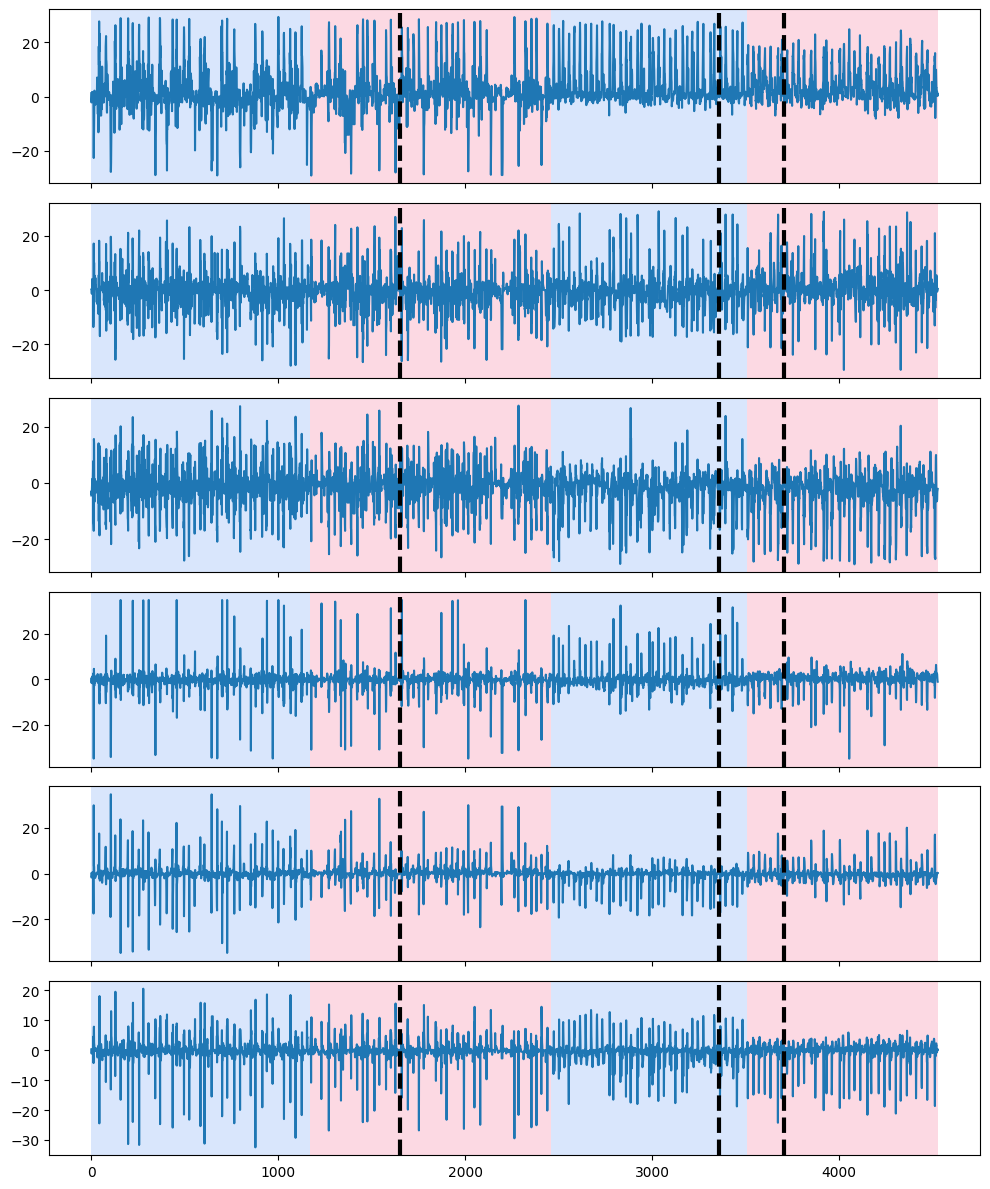

In [178]:
eval, result = predict_change_points_window(racket_ds, n, change_points, "rbf", window_size)
exp1[0] = eval.iloc[3,1]

eval


188.75


Metryka    Wartość
0     Acc   0.999412
1    Prec   0.666667
2  Recall   0.666667
3      F1   0.666667
4     ASC   1.000000
5     ASD  26.666667
6     ADT   1.000000

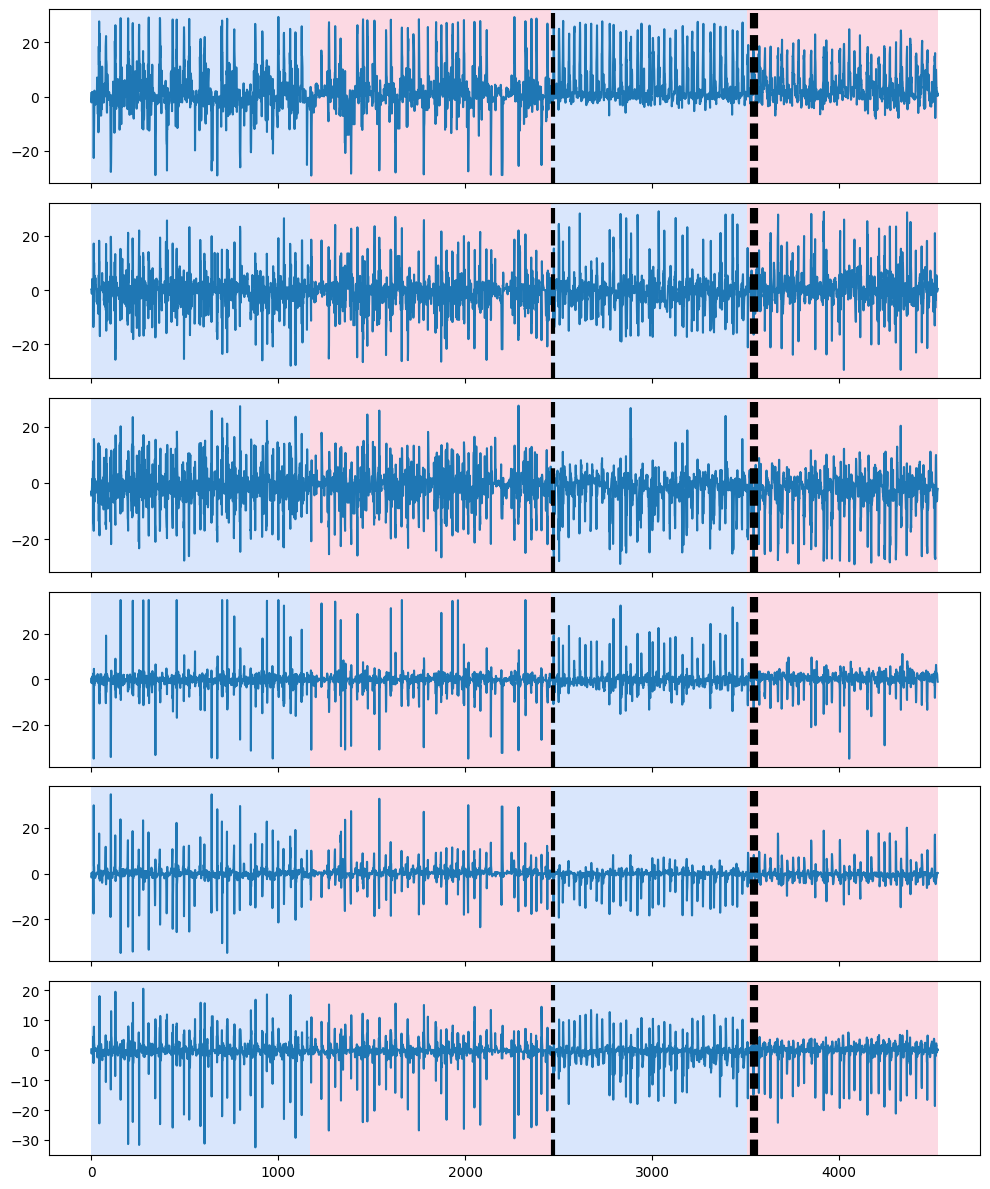

In [179]:
eval, result = predict_change_points_binseg(racket_ds, n, change_points, "l1")
exp1[1] = eval.iloc[3,1]

eval


188.75


Metryka    Wartość
0     Acc   0.999412
1    Prec   0.666667
2  Recall   0.666667
3      F1   0.666667
4     ASC   0.666667
5     ASD  20.000000
6     ADT   0.000000

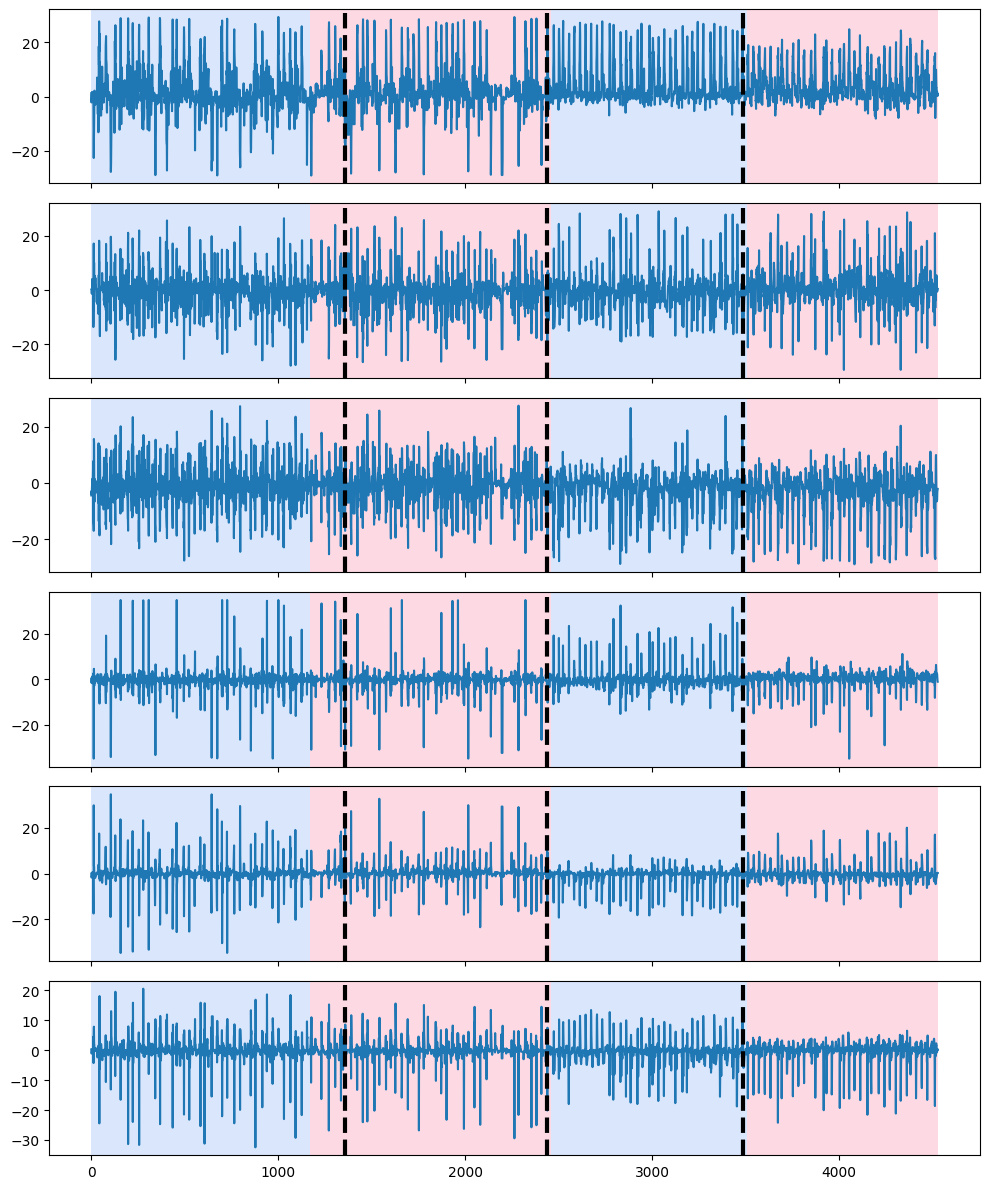

In [180]:
eval, result = predict_change_points_bottomup(racket_ds, n, change_points, "linear")
exp1[2] = eval.iloc[3,1]

eval


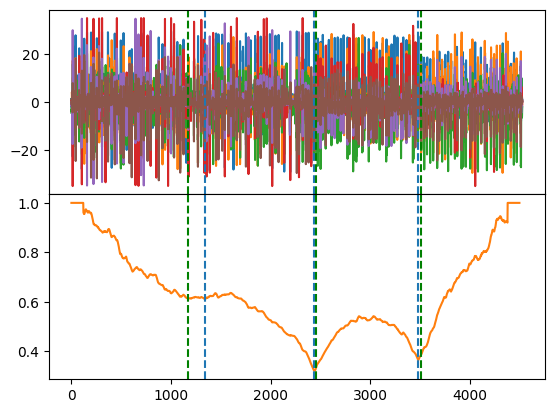

188.75
[0.33333333 0.66666667 0.66666667 1.        ]
Conducted experimets: 1
window current average rank is: 4.0
binseg current average rank is: 3.0
bottomup current average rank is: 2.0
fluss current average rank is: 1.0


Metryka    Wartość
0     Acc   1.000000
1    Prec   1.000000
2  Recall   1.000000
3      F1   1.000000
4     ASC   1.000000
5     ASD  73.000000
6     ADT   0.333333

In [181]:
FlussRegimeSegmentator = Fluss(window_size, 4)

cac, regimes = FlussRegimeSegmentator.m_predict_regimes(racket_ds)
FlussRegimeSegmentator.print_latest_output(change_points)

eval = get_evaluation(regimes,change_points,racket_ds.shape[0])

exp1[3] = eval.iloc[3,1]

print(exp1)

Benchmark.add_experiment(exp1)
Benchmark.print_current_results()
eval

[array([4, 3, 2, 1], dtype=int64)]


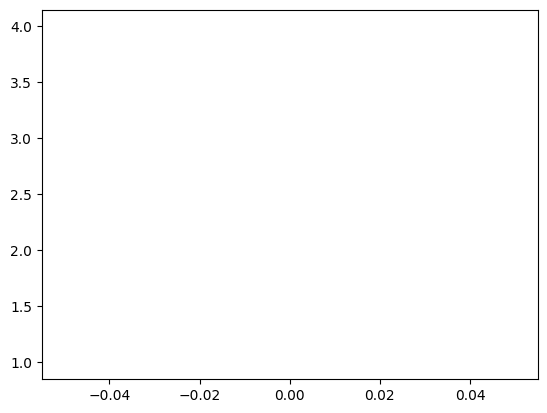

In [182]:
import plotly.express as px

print(Benchmark.history)
plt.plot(Benchmark.history)
plt.show()

# Experiment 2 (Earthquakes)

In [5]:
filepath = './datasets/Earthquakes/Earthquakes_TRAIN.arff'
earth_ds, original_points, window_size = load_data_univariate_representation(filepath, 44, 50, False, False)
print(window_size)
x = 10
i = original_points[x]
exp2 = np.zeros(Benchmark.algorithms_number)

rpt.display(earth_ds[:i], original_points[:(x+1)])

512


NameError: name 'Benchmark' is not defined

217.6


Metryka   Wartość
0     Acc  0.998929
1    Prec  0.300000
2  Recall  0.300000
3      F1  0.300000
4     ASC  0.300000
5     ASD  0.666667
6     ADT  0.333333

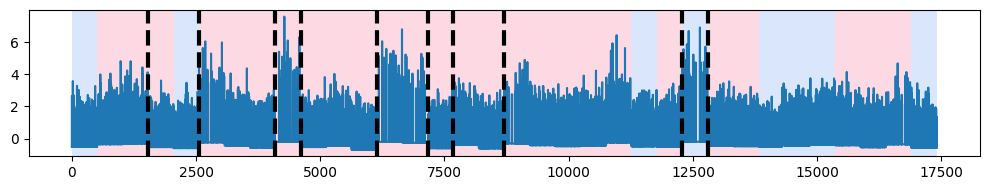

In [184]:
eval, result = predict_change_points_window(earth_ds[:i], earth_ds[:i].shape[0], original_points[:x],"rank" , window_size)
exp2[0] = eval.iloc[3,1]
eval


217.6


Metryka   Wartość
0     Acc  0.998776
1    Prec  0.200000
2  Recall  0.200000
3      F1  0.200000
4     ASC  0.200000
5     ASD  3.000000
6     ADT  0.500000

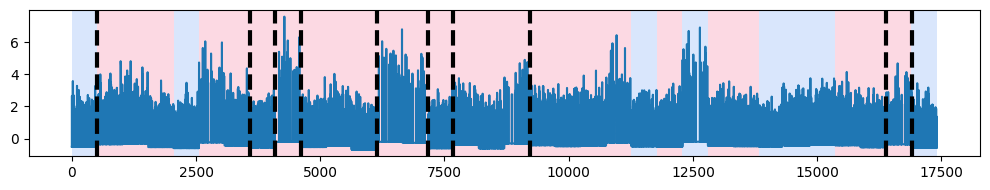

In [185]:
eval, result = predict_change_points_binseg(earth_ds[:i], earth_ds[:i].shape[0], original_points[:x],"l1" )
exp2[1] = eval.iloc[3,1]
eval


217.6


Metryka   Wartość
0     Acc  0.998929
1    Prec  0.300000
2  Recall  0.300000
3      F1  0.300000
4     ASC  0.300000
5     ASD  0.666667
6     ADT  0.333333

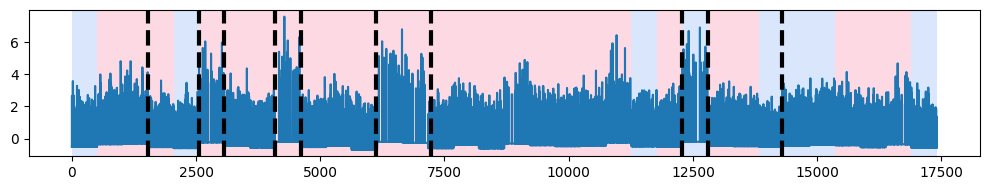

In [186]:
eval, result = predict_change_points_bottomup(earth_ds[:i], earth_ds[:i].shape[0], original_points[:x],"l1" )
exp2[2] = eval.iloc[3,1]
eval


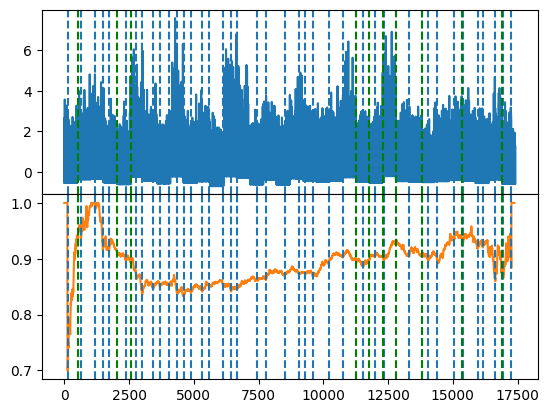

217.6
Conducted experimets: 2
window current average rank is: 3.0
binseg current average rank is: 3.5
bottomup current average rank is: 1.5
fluss current average rank is: 2.0


Metryka    Wartość
0     Acc   0.997169
1    Prec   0.170732
2  Recall   0.700000
3      F1   0.274510
4     ASC   0.700000
5     ASD  93.142857
6     ADT   0.714286

In [187]:
FlussEarth = Fluss(window_size, 3)

cac, regimes = FlussRegimeSegmentator.predict_regimes(earth_ds[:i])
FlussRegimeSegmentator.print_latest_output(original_points[:x])

eval = get_evaluation(regimes, original_points[:x], earth_ds[:i].shape[0])
exp2[3] = eval.iloc[3,1]
Benchmark.add_experiment(exp2)
Benchmark.print_current_results()
eval

In [188]:
print(Benchmark.history)

# sorted_indices = np.argsort((exp2))
print(exp2)
# print(sorted_indices)


# sorted_indices = np.argsort(exp1)
print(exp1)
# print(sorted_indices)

[array([4, 3, 2, 1], dtype=int64), array([2, 4, 1, 3], dtype=int64)]
[0.3       0.2       0.3       0.2745098]
[0.33333333 0.66666667 0.66666667 1.        ]


# Experiment 3 (UMD)

150
[1800 3600]


NameError: name 'Benchmark' is not defined

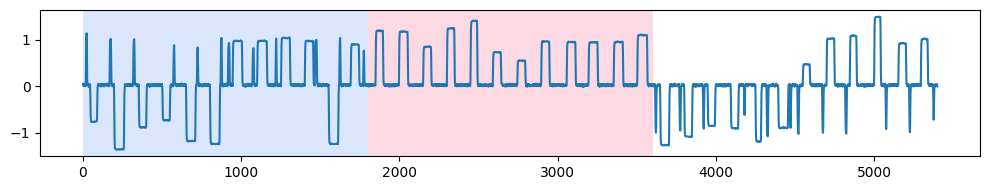

In [7]:
filepath = './datasets/UMD/UMD_TRAIN.arff'

umd_data, original_points, window_size = load_data_univariate_representation(filepath, 44, 50, False, False)
print(window_size)
print(original_points)
rpt.display(umd_data, original_points)

exp3 = np.zeros(Benchmark.algorithms_number)
n = umd_data.shape[0]

C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning:

New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).



337.5
[2065, 3500]


Metryka  Wartość
0     Acc      1.0
1    Prec      1.0
2  Recall      1.0
3      F1      1.0
4     ASC      1.0
5     ASD    182.5
6     ADT      0.5

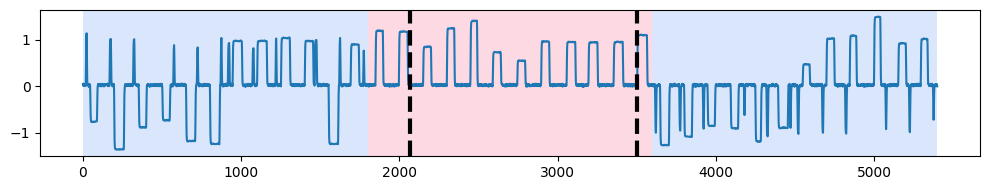

In [190]:
eval, result = predict_change_points_window(umd_data, n, original_points, "normal", window_size)
print(result)
exp3[0] = eval.iloc[3,1]
eval


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning:

New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).



337.5
[870, 3570]


Metryka    Wartość
0     Acc   0.999506
1    Prec   0.500000
2  Recall   0.500000
3      F1   0.500000
4     ASC   0.500000
5     ASD  30.000000
6     ADT   0.000000

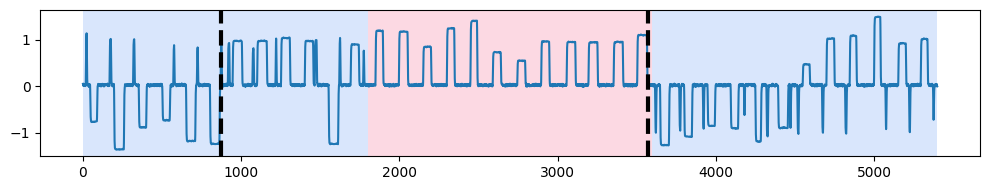

In [191]:
eval, result = predict_change_points_binseg(umd_data, n, original_points, "normal")
print(result)
exp3[1] = eval.iloc[3,1]
eval


337.5
[865, 3650]


Metryka    Wartość
0     Acc   0.999506
1    Prec   0.500000
2  Recall   0.500000
3      F1   0.500000
4     ASC   0.500000
5     ASD  50.000000
6     ADT   1.000000

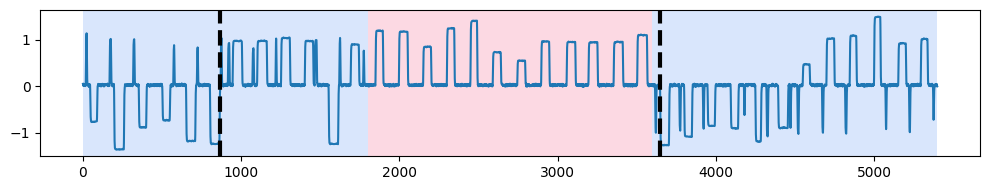

In [192]:
eval, result = predict_change_points_bottomup(umd_data, n, original_points, "l2")
print(result)
exp3[2] = eval.iloc[3,1]
eval


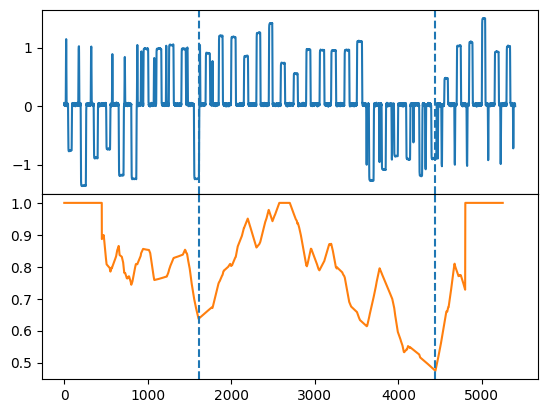

337.5
Conducted experimets: 3
window current average rank is: 2.3333333333333335
binseg current average rank is: 3.6666666666666665
bottomup current average rank is: 2.0
fluss current average rank is: 2.0


Metryka     Wartość
0     Acc    0.999506
1    Prec    0.500000
2  Recall    0.500000
3      F1    0.500000
4     ASC    0.500000
5     ASD  192.000000
6     ADT    0.000000

In [193]:
FlussRegimeSegmentator = Fluss(window_size, 3)

cac, regimes = FlussRegimeSegmentator.predict_regimes(umd_data)
FlussRegimeSegmentator.print_latest_output()

eval = get_evaluation(regimes, original_points, n)

exp3[3] = eval.iloc[3,1]
Benchmark.add_experiment(exp3)
Benchmark.print_current_results()
eval

# Experiment 4 (FreezerSmallTrain)

(<Figure size 1000x200 with 1 Axes>, [<Axes: >])

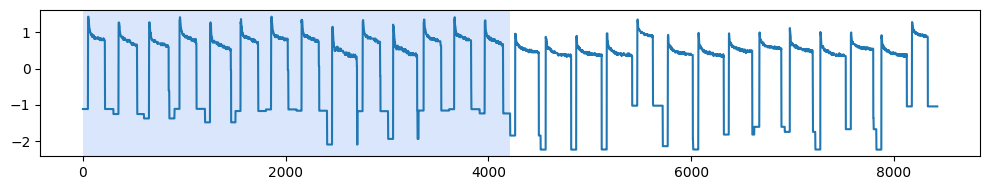

In [194]:
filepath = './datasets/FreezerSmallTrain/FreezerSmallTrain_TRAIN.arff'

fst_ds, original_points, window_size = load_df_2d_representation_grouped(filepath)
exp4 = np.zeros(Benchmark.algorithms_number)
rpt.display(fst_ds, original_points)



1053.5


Metryka   Wartość
0     Acc  0.999684
1    Prec  0.000000
2  Recall  0.000000
3      F1  0.000000
4     ASC  0.000000
5     ASD -1.000000
6     ADT -1.000000

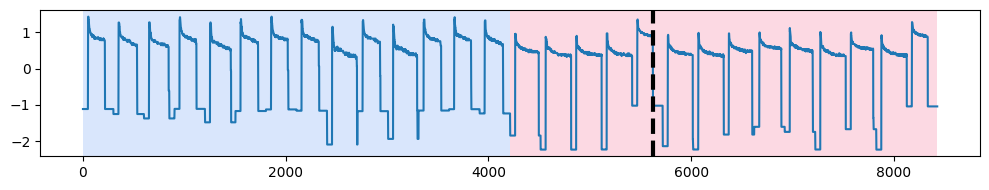

In [195]:
eval, result = predict_change_points_window(fst_ds, fst_ds.shape[0], original_points, "l1", window_size)
exp4[0] = eval.iloc[3,1]
eval


1053.5


Metryka   Wartość
0     Acc  0.999684
1    Prec  0.000000
2  Recall  0.000000
3      F1  0.000000
4     ASC  0.000000
5     ASD -1.000000
6     ADT -1.000000

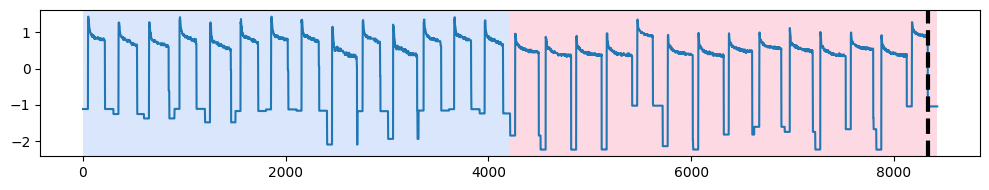

In [196]:
eval, result = predict_change_points_binseg(fst_ds, fst_ds.shape[0], original_points, "l2")
exp4[1] = eval.iloc[3,1]
eval


1053.5


Metryka   Wartość
0     Acc  0.999684
1    Prec  0.000000
2  Recall  0.000000
3      F1  0.000000
4     ASC  0.000000
5     ASD -1.000000
6     ADT -1.000000

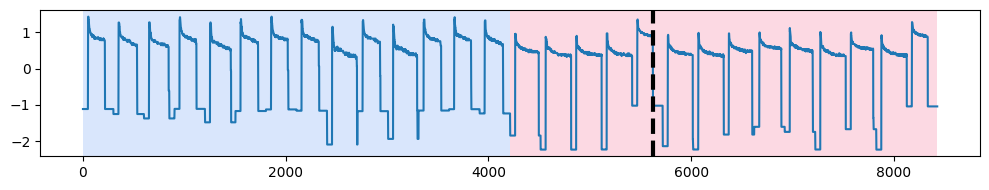

In [197]:
eval, result = predict_change_points_bottomup(fst_ds, fst_ds.shape[0], original_points, "l1")
exp4[2] = eval.iloc[3,1]
eval


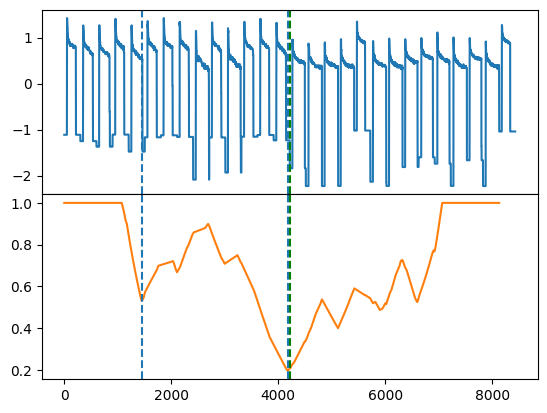

1053.5
Conducted experimets: 4
window current average rank is: 2.75
binseg current average rank is: 3.5
bottomup current average rank is: 2.0
fluss current average rank is: 1.75
[1446 4174]


Metryka    Wartość
0     Acc   0.999842
1    Prec   0.500000
2  Recall   1.000000
3      F1   0.666667
4     ASC   1.000000
5     ASD  40.000000
6     ADT   0.000000

In [198]:
FlussRegimeSegmentator = Fluss(window_size, 3)

cac, regimes = FlussRegimeSegmentator.predict_regimes(fst_ds)
FlussRegimeSegmentator.print_latest_output(original_points)

eval = get_evaluation(regimes,original_points,fst_ds.shape[0])
exp4[3] = eval.iloc[3,1]
Benchmark.add_experiment(exp4)
Benchmark.print_current_results()
print(regimes)
eval

# Experiment 5 (Libras)

In [9]:
filepath = './datasets/Libras/Libras_TRAIN.arff'

df = load_dataset_to_dataframe(filepath)

window_size = len(df.iloc[0,0][0])


print(window_size)
libras_ds, original_points, window_size  =  load_data_multivariate_representation(filepath, 44, 44, False, False)
print(window_size)


exp5 = np.zeros(Benchmark.algorithms_number)
n = libras_ds.shape[0]
rpt.display(libras_ds, original_points)



45
45


NameError: name 'Benchmark' is not defined

C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning:

New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).



72.32142857142857


Metryka    Wartość
0     Acc   0.997042
1    Prec   0.357143
2  Recall   0.357143
3      F1   0.357143
4     ASC   0.428571
5     ASD  22.500000
6     ADT   0.333333

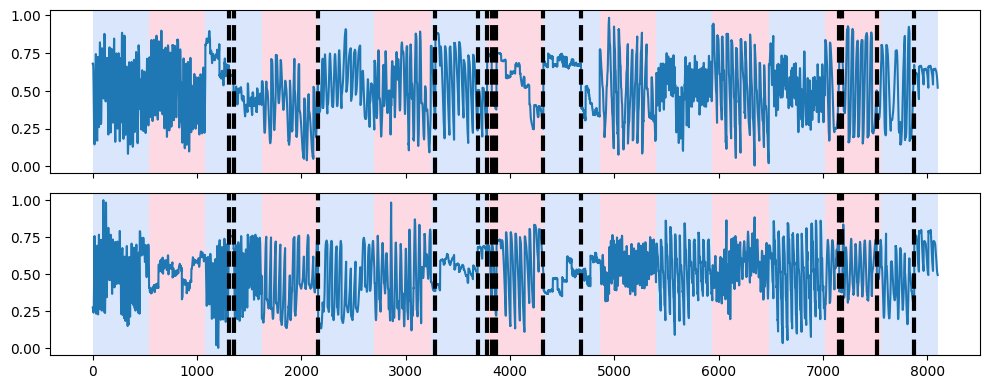

In [200]:
eval, result =  predict_change_points_window(libras_ds,n,original_points,"normal",window_size)
exp5[0] = eval.iloc[3,1]
eval

72.32142857142857


Metryka    Wartość
0     Acc   0.997370
1    Prec   0.428571
2  Recall   0.428571
3      F1   0.428571
4     ASC   0.428571
5     ASD  22.500000
6     ADT   0.500000

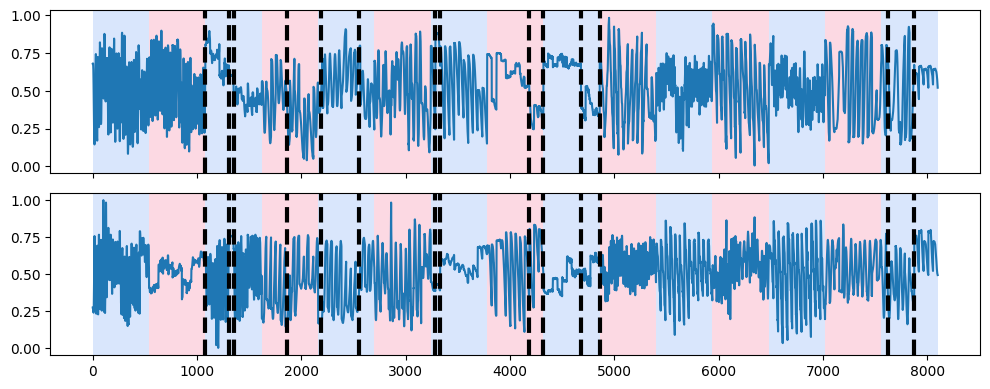

In [201]:
eval, result =  predict_change_points_binseg(libras_ds,n,original_points,"l1")
exp5[1] = eval.iloc[3,1]
eval

72.32142857142857


Metryka    Wartość
0     Acc   0.997042
1    Prec   0.357143
2  Recall   0.357143
3      F1   0.357143
4     ASC   0.428571
5     ASD  11.666667
6     ADT   0.166667

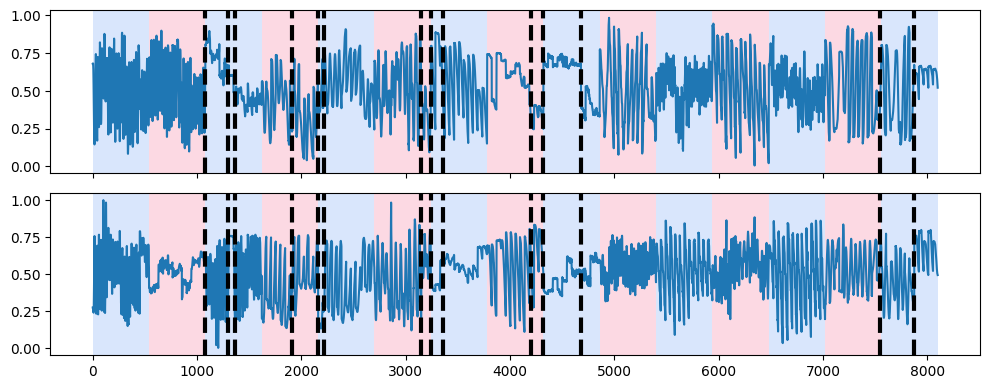

In [202]:
eval, result =  predict_change_points_bottomup(libras_ds,n,original_points,"l2")
exp5[2] = eval.iloc[3,1]
eval

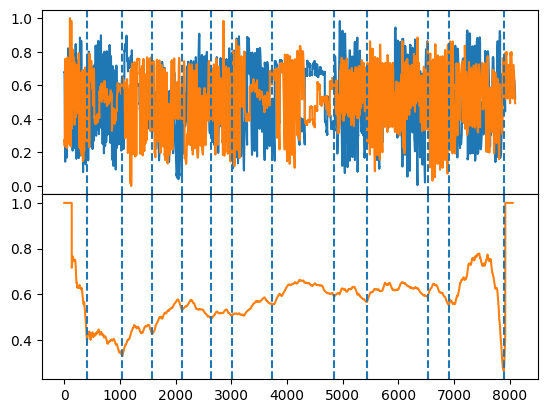

72.32142857142857
Conducted experimets: 5
window current average rank is: 3.0
binseg current average rank is: 3.2
bottomup current average rank is: 2.2
fluss current average rank is: 1.6


Metryka    Wartość
0     Acc   0.998356
1    Prec   0.666667
2  Recall   0.571429
3      F1   0.615385
4     ASC   0.571429
5     ASD  39.750000
6     ADT   0.250000

In [203]:
FlussRegimeSegmentator = Fluss(window_size,3)

cac, regimes = FlussRegimeSegmentator.m_predict_regimes(libras_ds)
FlussRegimeSegmentator.print_latest_output()

eval = get_evaluation(regimes,original_points,n)
exp5[3] = eval.iloc[3,1]
Benchmark.add_experiment(exp5)
Benchmark.print_current_results()
eval

# Experiment 6 (Cricket)

In [10]:
filepath = './datasets/Cricket/Cricket_TRAIN.arff'

df = load_dataset_to_dataframe(filepath)

window_size = len(df.iloc[0,0][0])
print(window_size)
# cricet_stacked, original_points = stack_time_series_randomly(df,False)
# cricet_stacked_ndarray = dataframe_to_ndarray(cricet_stacked)
# original_points = original_points.astype(dtype = int)

# cricket_ds = cricet_stacked_ndarray.astype(np.float64)
# rpt.display(cricket_ds, original_points)

# exp6 = np.zeros(Benchmark.algorithms_number)
# n = cricket_ds.shape[0]

1197


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning:

New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).



1469.0454545454545


Metryka     Wartość
0     Acc    0.999835
1    Prec    0.272727
2  Recall    0.272727
3      F1    0.272727
4     ASC    0.272727
5     ASD  431.000000
6     ADT    0.333333

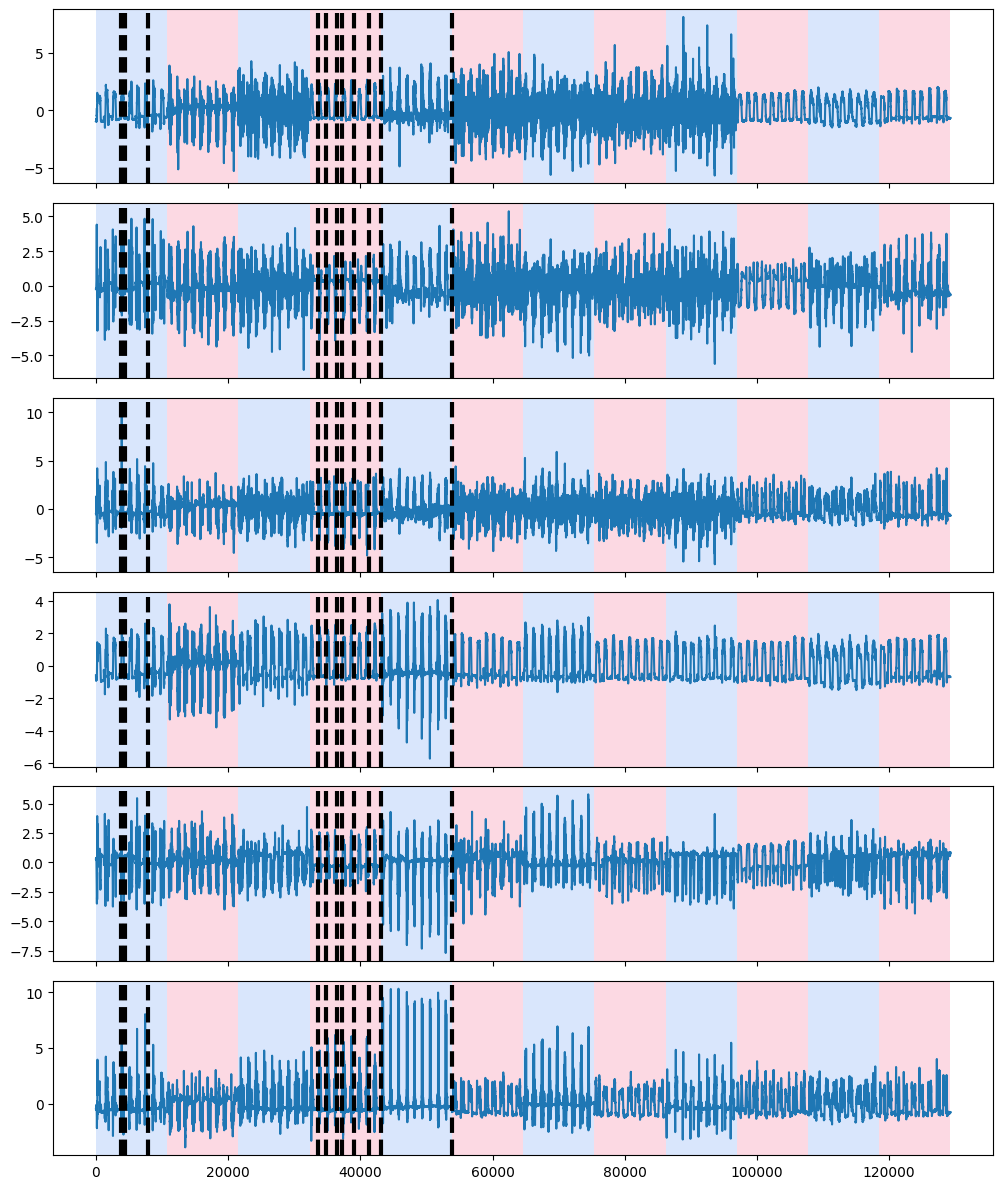

In [205]:
eval, result = predict_change_points_window(cricket_ds, n, original_points, "normal", window_size)
exp6[0] = eval.iloc[3,1]
eval



C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning:

New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).



1469.0454545454545


Metryka    Wartość
0     Acc   1.000000
1    Prec   1.000000
2  Recall   1.000000
3      F1   1.000000
4     ASC   1.000000
5     ASD  47.454545
6     ADT   0.636364

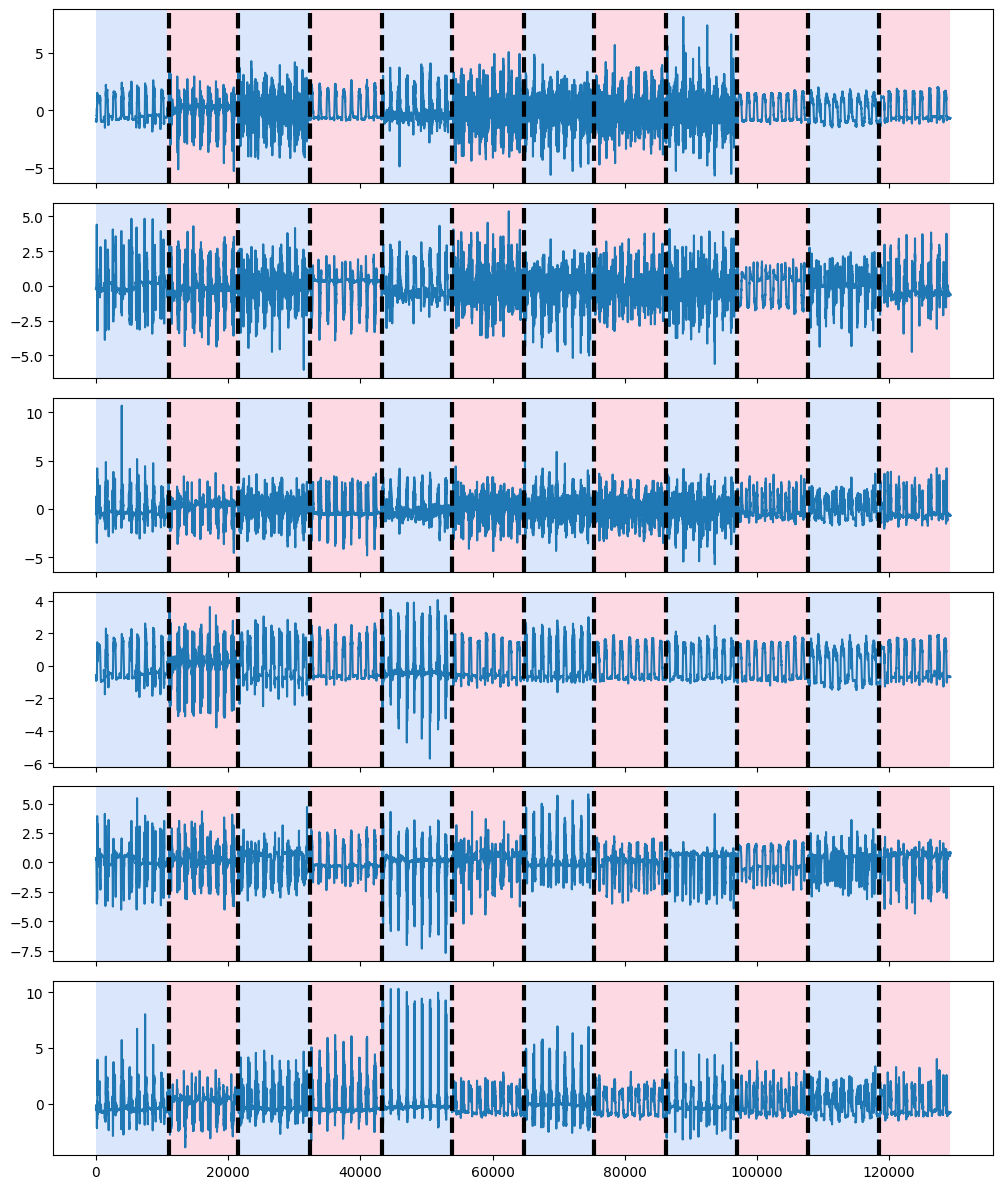

In [206]:
eval, result = predict_change_points_binseg(cricket_ds, n, original_points, "normal")
exp6[1] = eval.iloc[3,1]
eval



C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning:

New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).



1469.0454545454545


Metryka     Wartość
0     Acc    0.999938
1    Prec    0.727273
2  Recall    0.727273
3      F1    0.727273
4     ASC    0.727273
5     ASD  285.000000
6     ADT    0.375000

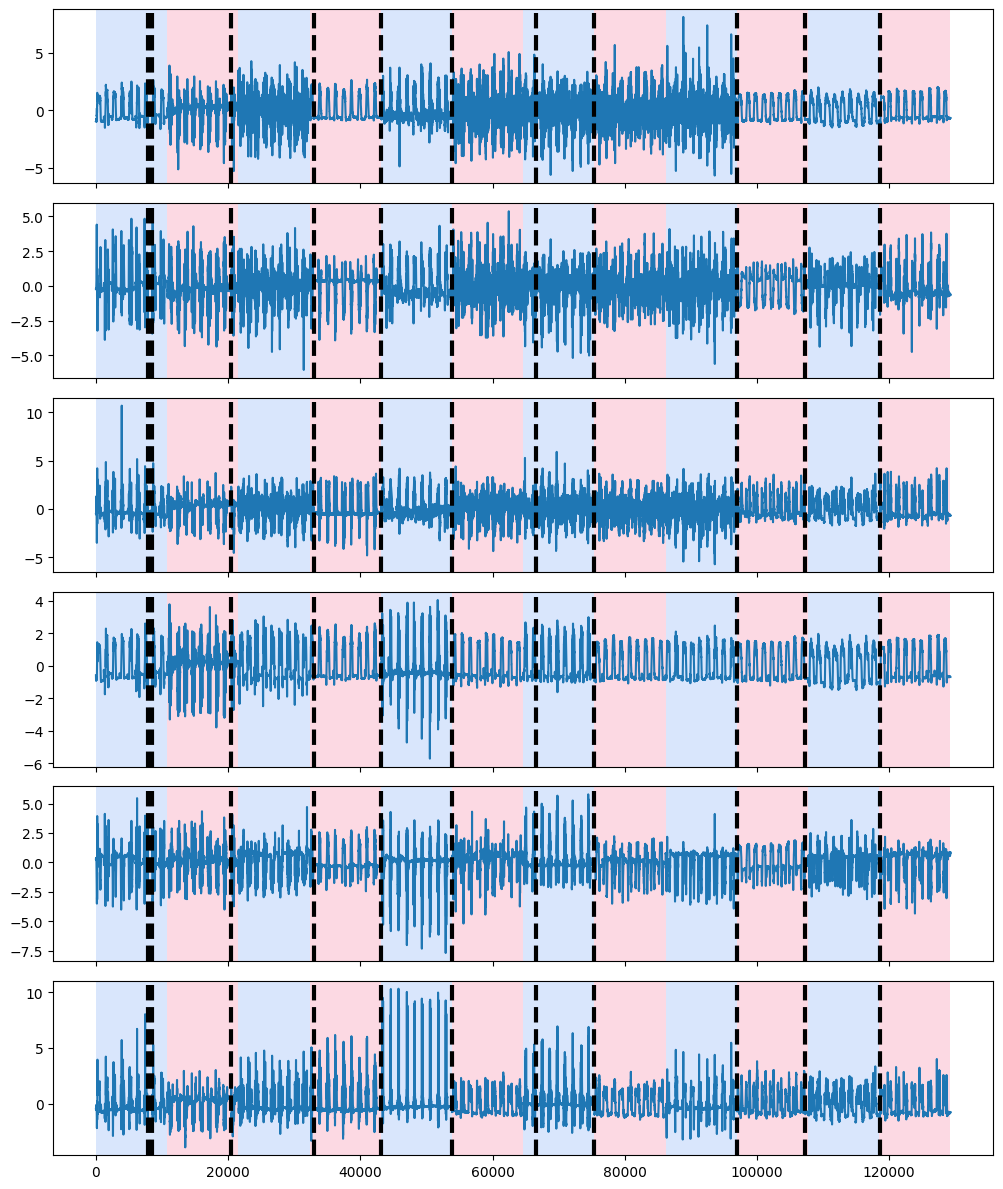

In [207]:
eval, result = predict_change_points_bottomup(cricket_ds, n, original_points, "normal")
exp6[2] = eval.iloc[3,1]
eval



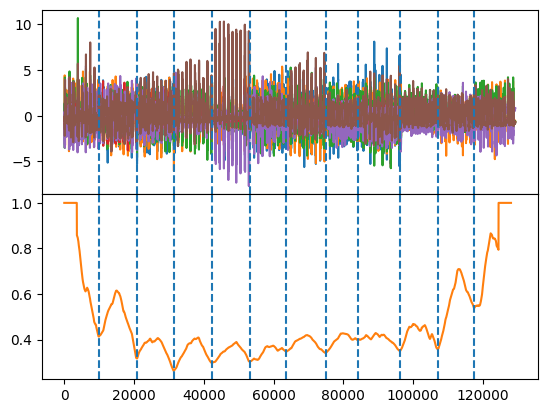

1469.0454545454545
Conducted experimets: 6
window current average rank is: 3.1666666666666665
binseg current average rank is: 2.8333333333333335
bottomup current average rank is: 2.3333333333333335
fluss current average rank is: 1.6666666666666667


Metryka     Wartość
0     Acc    0.999979
1    Prec    0.909091
2  Recall    0.909091
3      F1    0.909091
4     ASC    0.909091
5     ASD  789.500000
6     ADT    0.000000

In [208]:
FlussRegimeSegmentator = Fluss(window_size,3)

cac, regimes = FlussRegimeSegmentator.m_predict_regimes(cricket_ds)
FlussRegimeSegmentator.print_latest_output()
eval = get_evaluation(regimes,original_points,n)

exp6[3] = eval.iloc[3,1]
Benchmark.add_experiment(exp6)
Benchmark.print_current_results()
eval


# Experiment 7 (SweadishLeafs 1)

In [9]:
filepath = './datasets/SwedishLeaf/SwedishLeaf_TRAIN.arff'
df = load_dataset_to_dataframe(filepath)
print(df)
swleaf_data, original_points, window_size = load_df_2d_representation_grouped(filepath)
exp7 = np.zeros(Benchmark.algorithms_number)
rpt.display(swleaf_data, original_points)
n = swleaf_data.shape[0]

         att1     att2      att3      att4      att5      att6      att7  \
0    1.524750  1.53812  1.410790  1.244400  1.039470  0.868676  0.664257   
1    2.214930  2.05051  1.842350  1.635900  1.432590  1.285370  1.143260   
2    1.872010  1.72637  1.573640  1.396900  1.252210  1.083760  0.955383   
3    1.731019  1.70220  1.553009  1.387209  1.144580  0.951378  0.733035   
4    1.842670  1.74943  1.593560  1.420510  1.268400  1.118720  0.972792   
..        ...      ...       ...       ...       ...       ...       ...   
495  1.555160  1.39118  1.027670  0.747651  0.425793  0.158014  0.152089   
496  1.823961  1.74961  1.579271  1.384801  1.204190  1.022790  0.876355   
497  2.009910  1.89306  1.711190  1.492730  1.312480  1.097560  0.949675   
498  1.474660  1.49555  1.358110  1.142910  0.906578  0.752583  0.985894   
499  2.021830  1.92956  1.740330  1.581830  1.428630  1.250230  1.103560   

         att8      att9     att10  ...    att120    att121    att122  \
0    0.489801  

571.4285714285714


Metryka     Wartość
0     Acc    0.999583
1    Prec    0.285714
2  Recall    0.285714
3      F1    0.285714
4     ASC    0.285714
5     ASD  305.500000
6     ADT    0.500000

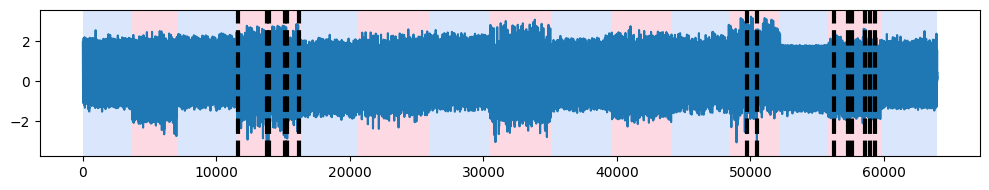

In [210]:
eval, result = predict_change_points_window(swleaf_data, n, original_points, "l2", window_size)
exp7[0] = eval.iloc[3,1]
eval



C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning:

New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).



571.4285714285714


Metryka   Wartość
0     Acc  0.999417
1    Prec  0.000000
2  Recall  0.000000
3      F1  0.000000
4     ASC  0.000000
5     ASD -1.000000
6     ADT -1.000000

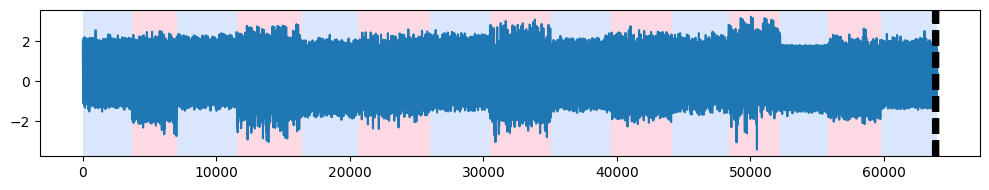

In [211]:
eval, result = predict_change_points_binseg(swleaf_data, n, original_points, "normal")
exp7[1] = eval.iloc[3,1]
eval



C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning:

New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).



571.4285714285714


Metryka   Wartość
0     Acc  0.999417
1    Prec  0.000000
2  Recall  0.000000
3      F1  0.000000
4     ASC  0.000000
5     ASD -1.000000
6     ADT -1.000000

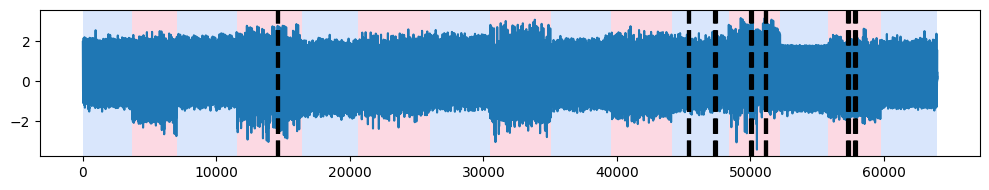

In [212]:
eval, result = predict_change_points_bottomup(swleaf_data, n, original_points, "normal")
exp7[2] = eval.iloc[3,1]
eval



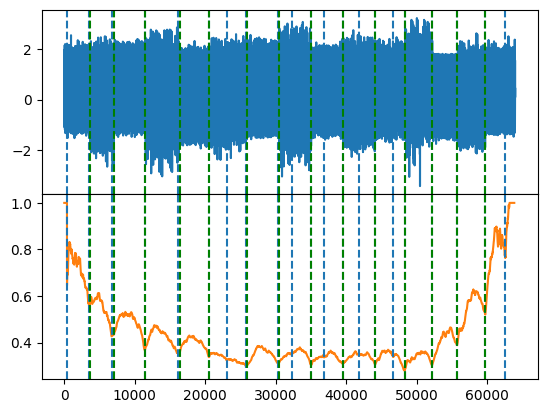

571.4285714285714
Conducted experimets: 7
window current average rank is: 3.0
binseg current average rank is: 3.0
bottomup current average rank is: 2.4285714285714284
fluss current average rank is: 1.5714285714285714


Metryka     Wartość
0     Acc    0.999854
1    Prec    0.666667
2  Recall    1.000000
3      F1    0.800000
4     ASC    1.000000
5     ASD  103.857143
6     ADT    0.000000

In [213]:
FlussRegimeSegmentator = Fluss(window_size,3)

cac, regimes = FlussRegimeSegmentator.predict_regimes(swleaf_data)
FlussRegimeSegmentator.print_latest_output(original_points)

eval = get_evaluation(regimes, original_points, swleaf_data.shape[0])
exp7[3] = eval.iloc[3,1]
Benchmark.add_experiment(exp7)
Benchmark.print_current_results()
eval

# Experiment 8 (sweadish leafs 2)

(<Figure size 1000x200 with 1 Axes>, [<Axes: >])

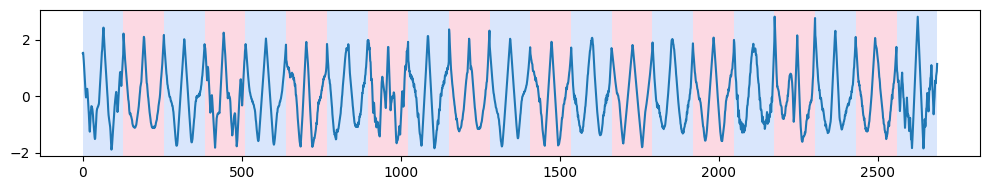

In [214]:
filepath = './datasets/SwedishLeaf/SwedishLeaf_TRAIN.arff'

swleaf_data2, original_points, window_size = load_df_2d_representation(filepath)

x = 20 
i = original_points[x]
swleaf_data2 = swleaf_data2[:i]
original_points = original_points[:x+1]

exp8 = np.zeros(Benchmark.algorithms_number)
rpt.display(swleaf_data2,original_points)

C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning:

New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).



16.8


Metryka   Wartość
0     Acc  0.984375
1    Prec  0.071429
2  Recall  0.050000
3      F1  0.058824
4     ASC  0.050000
5     ASD  4.000000
6     ADT  1.000000

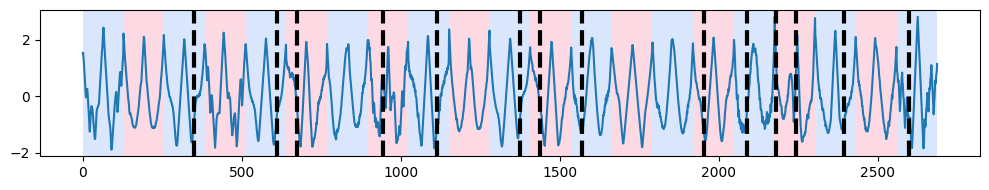

In [215]:
eval, result = predict_change_points_window(swleaf_data2, swleaf_data2.shape[0], original_points[:-1], "normal",window_size)
exp8[0] = eval.iloc[3,1]
eval



C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning:

New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).



16.8


Metryka    Wartość
0     Acc   0.983407
1    Prec   0.150000
2  Recall   0.150000
3      F1   0.150000
4     ASC   0.200000
5     ASD  11.000000
6     ADT   0.250000

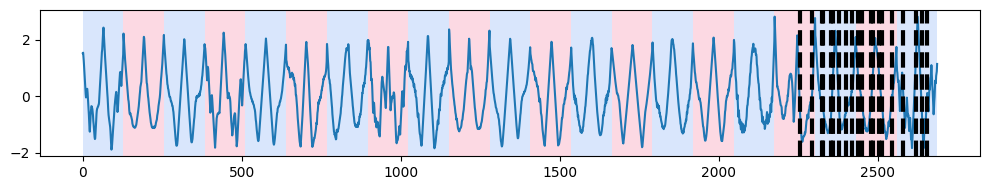

In [216]:
eval, result = predict_change_points_binseg(swleaf_data2, swleaf_data2.shape[0], original_points[:-1], "normal")
exp8[1] = eval.iloc[3,1]
eval



C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning:

New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).



16.8


Metryka   Wartość
0     Acc  0.981445
1    Prec  0.050000
2  Recall  0.050000
3      F1  0.050000
4     ASC  0.050000
5     ASD  6.000000
6     ADT  0.000000

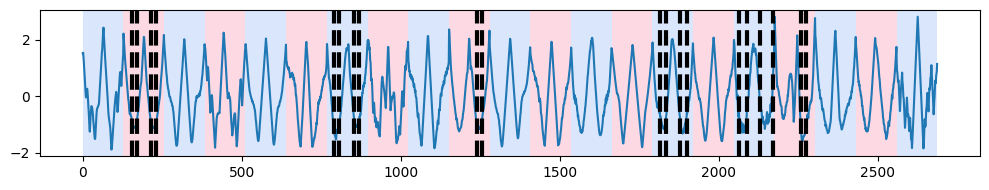

In [217]:
eval, result = predict_change_points_bottomup(swleaf_data2, swleaf_data2.shape[0], original_points[:-1], "normal")
exp8[2] = eval.iloc[3,1]
eval



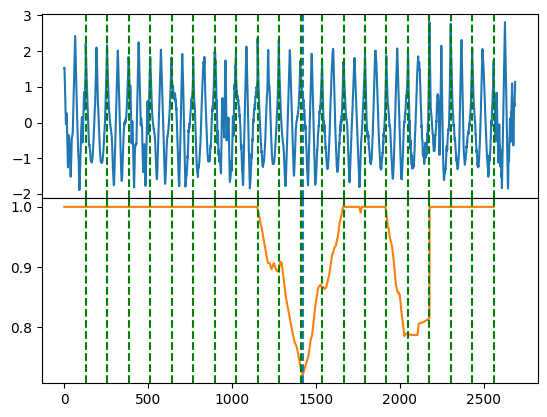

16.8
Conducted experimets: 8
window current average rank is: 3.0
binseg current average rank is: 2.75
bottomup current average rank is: 2.625
fluss current average rank is: 1.625


Metryka    Wartość
0     Acc   0.990723
1    Prec   1.000000
2  Recall   0.050000
3      F1   0.095238
4     ASC   0.050000
5     ASD  13.000000
6     ADT   1.000000

In [218]:
FlussRegimeSegmentator = Fluss(window_size,3)

cac, regimes = FlussRegimeSegmentator.predict_regimes(swleaf_data2)
FlussRegimeSegmentator.print_latest_output(original_points[:-1])

eval = get_evaluation(regimes, original_points[:-1], swleaf_data2.shape[0])
exp8[3] = eval.iloc[3,1]
Benchmark.add_experiment(exp8)
Benchmark.print_current_results()
eval

# Experiment 9 (basic_motions)

In [11]:
filepath = './datasets/basic_motions/BasicMotions_TRAIN.arff'

df = load_dataset_to_dataframe(filepath)

print(len(df.iloc[0,0][0]))
window_size = len(df.iloc[0,0][0])

basic_ds, original_points = stack_time_series_randomly(df,False)
basic_ds = dataframe_to_ndarray(basic_ds)
original_points = original_points.astype(dtype = int)

basic_ds = basic_ds.astype(np.float64)


# exp9 = np.zeros(Benchmark.algorithms_number)
#rpt.display(basic_ds, original_points)
print(window_size)
# n = basic_ds.shape[0]
plt.plot(basic_ds[1000:1300,0])

100


TypeError: stack_time_series_randomly() missing 3 required positional arguments: 'seed', 'block_size', and 'group'

166.66666666666666


Metryka   Wartość
0     Acc  1.000000
1    Prec  1.000000
2  Recall  1.000000
3      F1  1.000000
4     ASC  1.000000
5     ASD  3.333333
6     ADT  0.666667

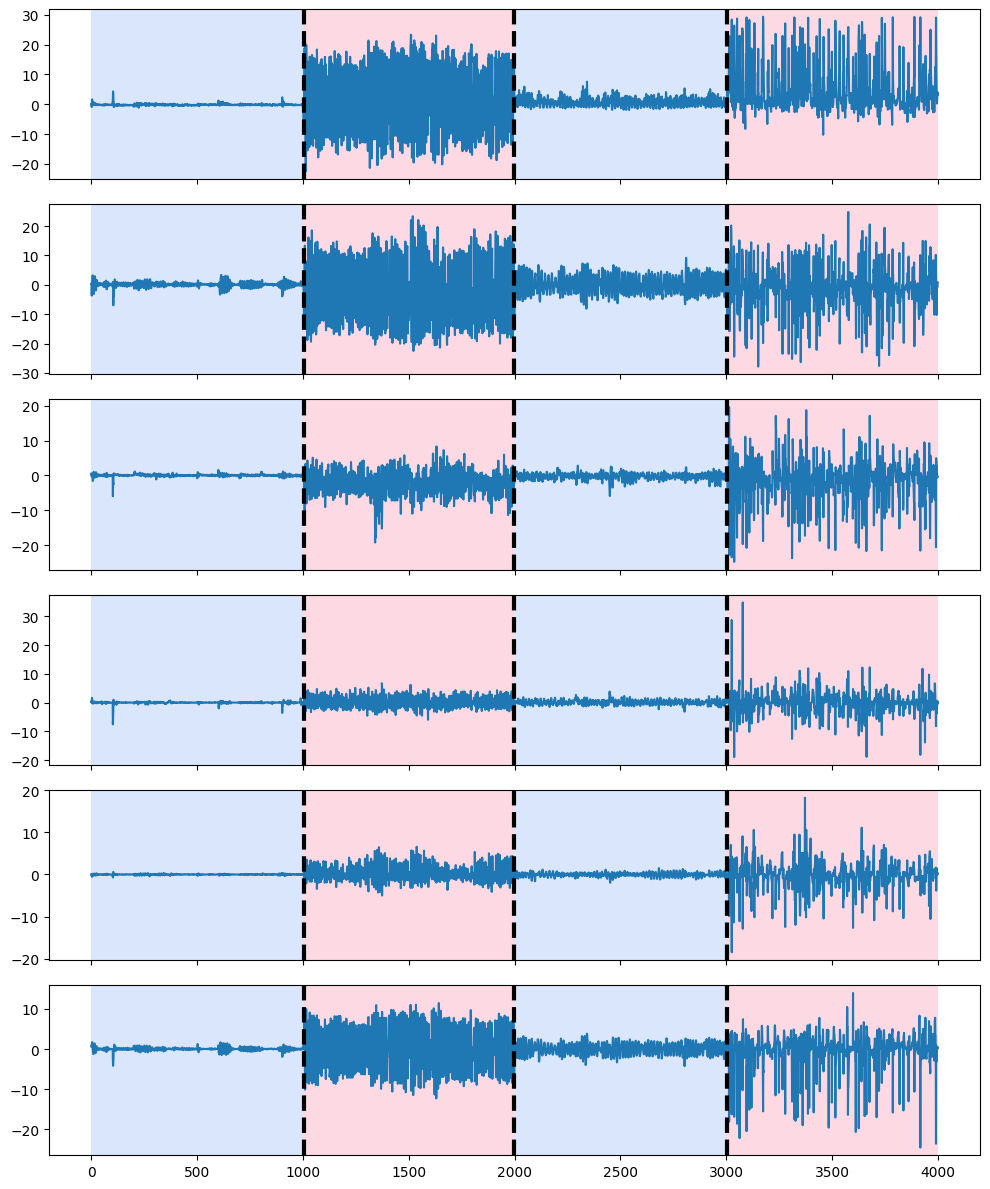

In [220]:
eval, result = predict_change_points_window(basic_ds, n, original_points, "l2", window_size)
exp9[0] = eval.iloc[3,1]
eval


166.66666666666666


Metryka   Wartość
0     Acc  1.000000
1    Prec  1.000000
2  Recall  1.000000
3      F1  1.000000
4     ASC  1.000000
5     ASD  3.333333
6     ADT  0.666667

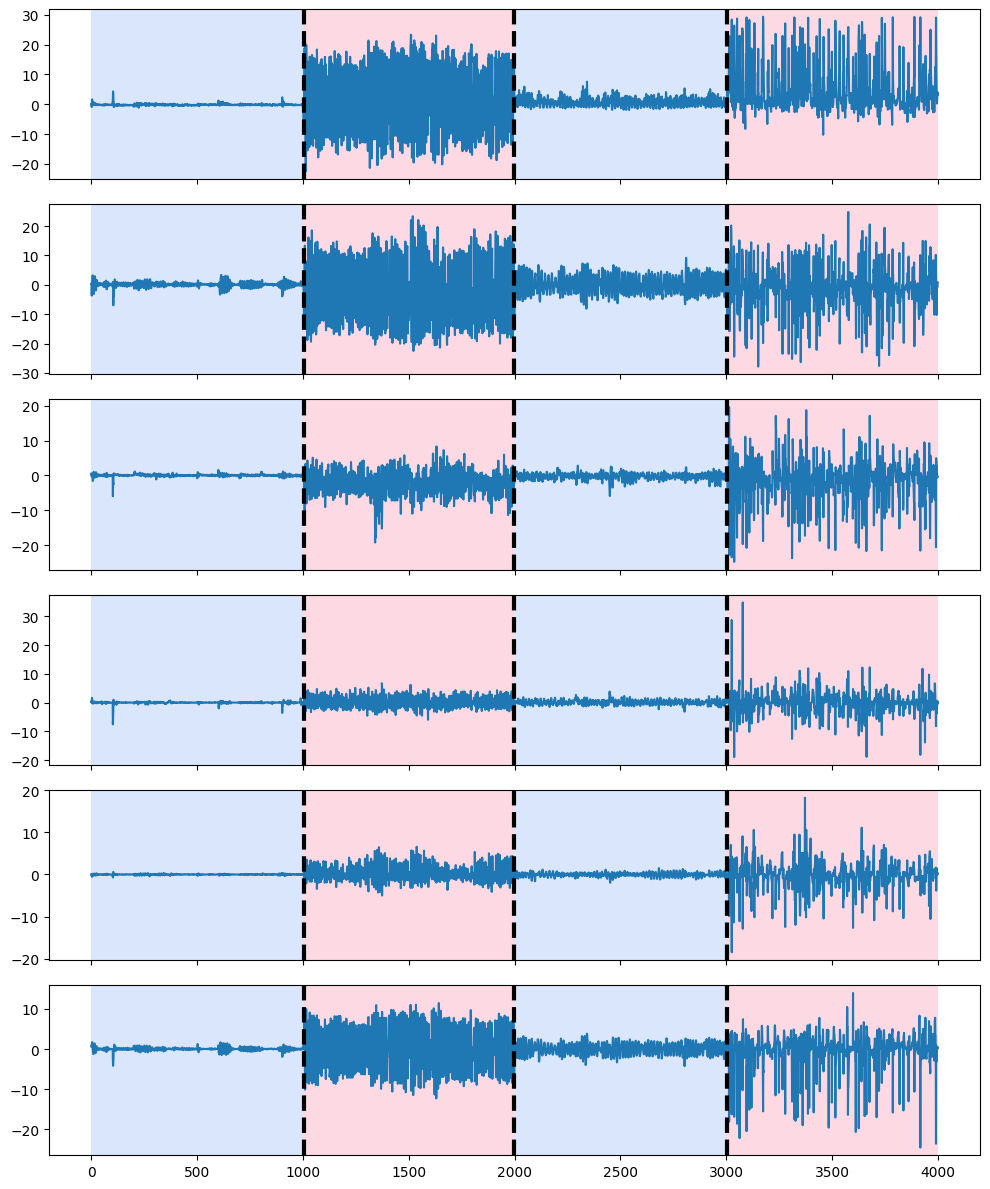

In [221]:
eval, result = predict_change_points_binseg(basic_ds, n, original_points, "l2")
exp9[1] = eval.iloc[3,1]
eval


166.66666666666666


Metryka   Wartość
0     Acc  1.000000
1    Prec  1.000000
2  Recall  1.000000
3      F1  1.000000
4     ASC  1.000000
5     ASD  6.666667
6     ADT  0.666667

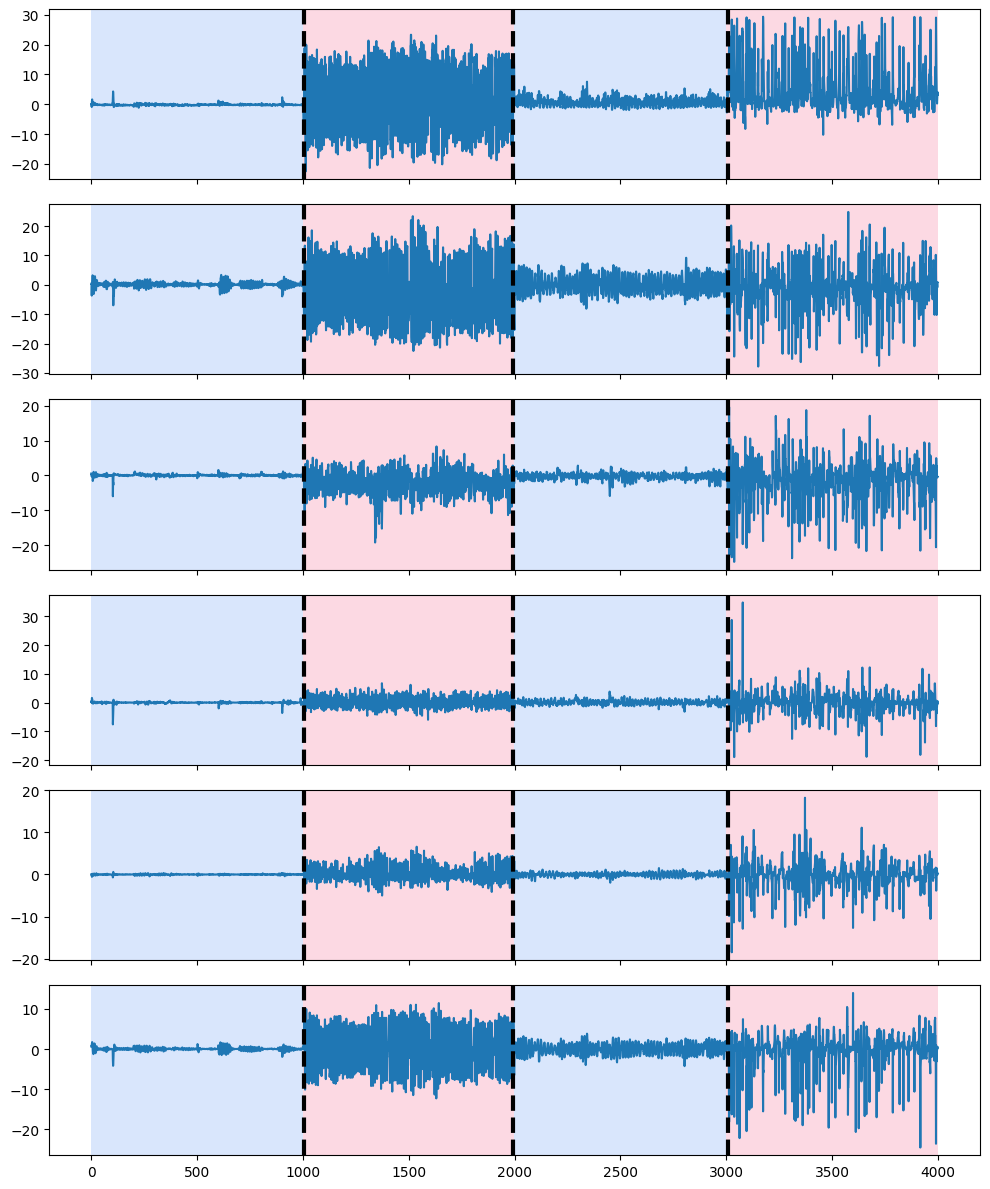

In [222]:
eval, result = predict_change_points_bottomup(basic_ds, n, original_points, "l2")
exp9[2] = eval.iloc[3,1]
eval


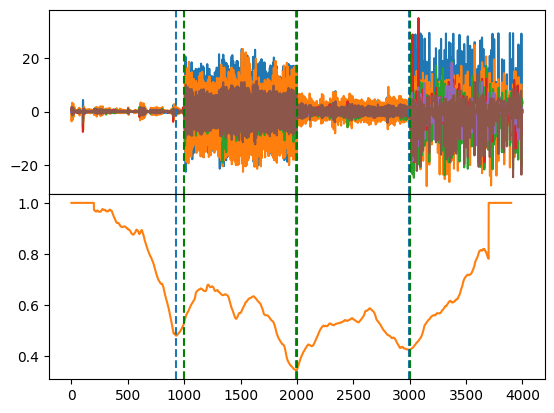

166.66666666666666
Conducted experimets: 9
window current average rank is: 3.111111111111111
binseg current average rank is: 2.7777777777777777
bottomup current average rank is: 2.5555555555555554
fluss current average rank is: 1.5555555555555556
[ 930 1995 2993]


Metryka    Wartość
0     Acc   1.000000
1    Prec   1.000000
2  Recall   1.000000
3      F1   1.000000
4     ASC   1.000000
5     ASD  27.333333
6     ADT   0.000000

In [223]:
FlussRegimeSegmentator = Fluss(window_size, 2)

cac, regimes = FlussRegimeSegmentator.m_predict_regimes(basic_ds)
FlussRegimeSegmentator.print_latest_output(original_points)

eval = get_evaluation(regimes,original_points,n)
exp9[3] = eval.iloc[3,1]
Benchmark.add_experiment(exp9)
Benchmark.print_current_results()
#rpt.display(racket_ds,change_points,regimes)
print(regimes)
eval

# Experiment 10 (BirdChicken)

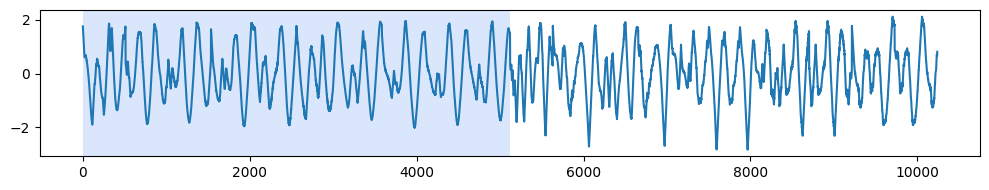

In [224]:
filepath = './datasets/BirdChicken/BirdChicken_TRAIN.arff'

bc_ds, original_points, window_size = load_df_2d_representation_grouped(filepath)
exp10 = np.zeros(Benchmark.algorithms_number)
rpt.display(bc_ds, original_points)
n = bc_ds.shape[0]
# plt.show()
# plt.plot(beef_ds[:5*window_size])


1280.0


Metryka  Wartość
0     Acc  0.99974
1    Prec  0.00000
2  Recall  0.00000
3      F1  0.00000
4     ASC  0.00000
5     ASD -1.00000
6     ADT -1.00000

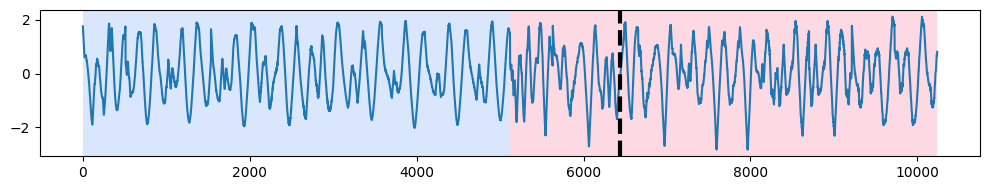

In [225]:
eval, result = predict_change_points_window(bc_ds, n, original_points, "rank",window_size)
exp10[0] = eval.iloc[3,1]
eval


1280.0


Metryka  Wartość
0     Acc  0.99974
1    Prec  0.00000
2  Recall  0.00000
3      F1  0.00000
4     ASC  0.00000
5     ASD -1.00000
6     ADT -1.00000

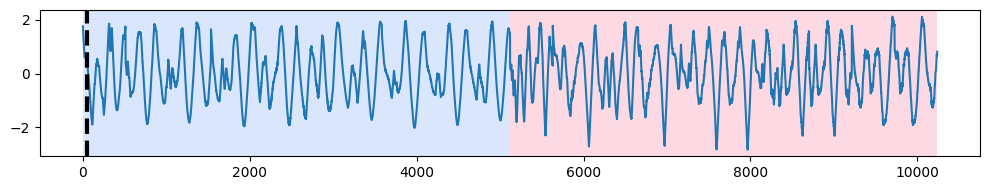

In [226]:
eval, result = predict_change_points_binseg(bc_ds, n, original_points, "l1")
exp10[1] = eval.iloc[3,1]
eval


1280.0


Metryka  Wartość
0     Acc  0.99974
1    Prec  0.00000
2  Recall  0.00000
3      F1  0.00000
4     ASC  0.00000
5     ASD -1.00000
6     ADT -1.00000

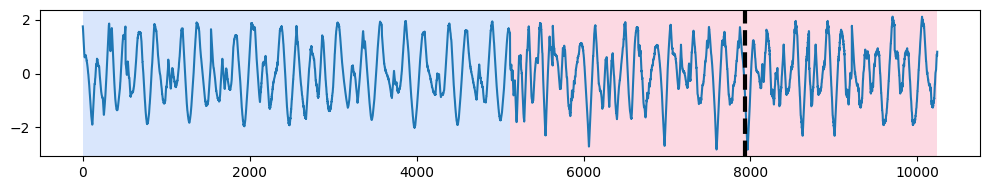

In [227]:
eval, result = predict_change_points_bottomup(bc_ds, n, original_points, "l2")
exp10[2] = eval.iloc[3,1]
eval


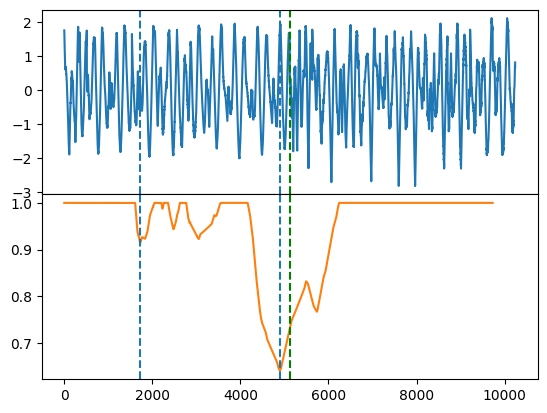

1280.0
Conducted experimets: 10
window current average rank is: 3.2
binseg current average rank is: 2.8
bottomup current average rank is: 2.5
fluss current average rank is: 1.5
[1728 4896]


Metryka     Wartość
0     Acc    0.999870
1    Prec    0.500000
2  Recall    1.000000
3      F1    0.666667
4     ASC    1.000000
5     ASD  224.000000
6     ADT    0.000000

In [228]:
FlussRegimeSegmentator = Fluss(window_size, 3)

cac, regimes = FlussRegimeSegmentator.predict_regimes(bc_ds)
FlussRegimeSegmentator.print_latest_output(original_points)

eval = get_evaluation(regimes,original_points,n)
exp10[3] = eval.iloc[3,1]
Benchmark.add_experiment(exp10)
#Benchmark.print_current_results()
#rpt.display(racket_ds,change_points,regimes)
print(regimes)
eval

# Experiment Template

In [24]:
def experimentTemplate(isMultivariate, filepath, costW, costBS, costBU, seed, block_size, subset = 1.0, group = False, shuffle = False, custom_ws = None):
    """ Function that aggregates 4 algorithms performance on one dataset. First it performs loading dataset to nupmy array,
    optionally dataset is grouped and shuffled and finally each algorithm is processed on it and evaluated

    Args:
        isMultivariate: bool value indicating wheteher data is mukltivariate or not
        filepath: path to .arff file containing time series
        costW: cost function for window algorithm (string)
        costBS: cost function for binary segmentation algorithm (string)
        costBU: cost function for bottomup algorithm (string)
        seed: seed for dataset shuffle randomization
        block_size: number of rows in original dataset which will make for a size of chunk for dataset shuffling if group is set to True
        subset: float representing partition of orignal dataset to be taken for data output
        group: bool, if set to true the output data will be grouped (each class will be in only one segment)
        shuffle: bool, if set to true, applies shuffling rows in groups of block_size, it takes part after (optional) grouping 
    Returns:
        all_evals: list of dataframes containing metrics and its values for each algorithm
        data: flattend 2d numpy array containing time series
        original_points: list of change points
    """
    
    data = None
    n =  None
    window_size = None
    original_points = None

    
    if isMultivariate:
        data, original_points, window_size = load_data_multivariate_representation(filepath, seed, block_size, group, shuffle)
        if subset != 1.0:
            size = len(original_points)
            index = floor(size*subset)
            cut_index = original_points[index]
            data = data[:cut_index, :]
            original_points = original_points[:index]
        
    else:
        data, original_points, window_size = load_data_univariate_representation(filepath, seed, block_size, group, shuffle)
        if subset != 1.0:
            size = len(original_points)
            index = floor(size*subset)
            cut_index = original_points[index]
            data = data[:cut_index]
            original_points = original_points[:index]
            rpt.display(data, original_points)

    


    n = data.shape[0]
    
    all_evals = []
    eval, result = predict_change_points_window(data, n, original_points, costW, window_size)
    all_evals.append(eval)
    
    eval, result = predict_change_points_binseg(data, n, original_points, costBS)
    all_evals.append(eval)

    eval, result = predict_change_points_bottomup(data, n, original_points, costBU)
    all_evals.append(eval)

    if custom_ws is not None:
        window_size = custom_ws
    
    FlussRegimeSegmentator = Fluss(window_size, 2)
    eval = None
    
    if(isMultivariate):
        cac, regimes = FlussRegimeSegmentator.m_predict_regimes(data)
        eval = get_evaluation(regimes, original_points, n)
        #FlussRegimeSegmentator.print_latest_output()
        all_evals.append(eval)

    else:
        cac, regimes = FlussRegimeSegmentator.predict_regimes(data)
        eval = get_evaluation(regimes,original_points,n)
        #FlussRegimeSegmentator.print_latest_output()
        all_evals.append(eval)
        

    return all_evals, data, original_points


# Experiments

In [15]:
from BenchmarkCaller import *

RACKETSPORTS_WS = 30
EARTHQUAKES_WS = 512
UMD_WS = 150
FST_WS = 301
LIBRAS_WS = 45
CRICKET_WS = 1197
SWLEAF_WS = 128
BASICMOTIONS_WS = 100
BIRDCHICKEN_WS = 512
ADIAC_WS = 176

WS_LIST = [RACKETSPORTS_WS, EARTHQUAKES_WS, UMD_WS, FST_WS, LIBRAS_WS, CRICKET_WS, SWLEAF_WS, BASICMOTIONS_WS, BIRDCHICKEN_WS, ADIAC_WS]
quartiles = np.quantile(WS_LIST, [0,0.25,0.5,0.75])
print(quartiles)

BC = BenchmarkCaller(10,4)

# out = BC.get_matrix_results()
# print(out[0,0,3,0])
# experiment 1 

BC.register_experiment(lambda seed, custom_window_size : experimentTemplate(True,'./datasets/RacketSports/RacketSports_TRAIN.arff'
,"l1" ,"l1" ,"l1" ,seed, 30,1.0,True,True, custom_window_size))

# experiment 2

BC.register_experiment(lambda seed, custom_window_size : experimentTemplate(False,'./datasets/Earthquakes/Earthquakes_TRAIN.arff'
,"rank" ,"l1" ,"l1" ,seed, 3,0.2,True,True, custom_window_size))

# experiment 3

BC.register_experiment(lambda seed, custom_window_size : experimentTemplate(False, './datasets/UMD/UMD_TRAIN.arff'
,"normal" ,"normal" ,"l2" ,seed, 4,1.0,True, True, custom_window_size))

# experiment 4 

BC.register_experiment(lambda seed, custom_window_size : experimentTemplate(False, './datasets/FreezerSmallTrain/FreezerSmallTrain_TRAIN.arff'
,"l1" ,"l2" ,"l1" ,seed, 4,1.0,True, True, custom_window_size))

# experiment 5

BC.register_experiment(lambda seed, custom_window_size : experimentTemplate(True, './datasets/Libras/Libras_TRAIN.arff'
,"normal" ,"l1" ,"l2", seed, 60, 1.0, True, True, custom_window_size))

# experiment 6 

BC.register_experiment(lambda seed, custom_window_size : experimentTemplate(True,  './datasets/Cricket/Cricket_TRAIN.arff'
,"normal" ,"normal" ,"normal", seed, 50, 0.4, True, True, custom_window_size))

# experiment 7 

BC.register_experiment(lambda seed, custom_window_size : experimentTemplate(False,  './datasets/SwedishLeaf/SwedishLeaf_TRAIN.arff'
,"l2" ,"normal" ,"normal", seed, 30, 0.6, True, True, custom_window_size))

# experiment 8 

BC.register_experiment(lambda seed, custom_window_size : experimentTemplate(True,  './datasets/basic_motions/BasicMotions_TRAIN.arff'
,"l2" ,"l2" ,"l2", seed, 5, 1.0, True, True, custom_window_size))

# experiment 9

BC.register_experiment(lambda seed, custom_window_size : experimentTemplate(False,   './datasets/BirdChicken/BirdChicken_TRAIN.arff'
,"rank" ,"l1" ,"l2", seed, 4, 1.0, True, True, custom_window_size))

# experiment 10

BC.register_experiment(lambda seed, custom_window_size : experimentTemplate(False,   './datasets/Adiac/Adiac_TRAIN.arff'
,"l1" ,"l1" ,"l1", seed, 4, 0.4, True, True, custom_window_size))

#BC.call_experiments(45,0)

[ 30.   107.   163.   459.25]


0it [00:00, ?it/s]

107.85714285714285
107.85714285714285
107.85714285714285
107.85714285714285
739.5555555555555
739.5555555555555
739.5555555555555
739.5555555555555


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


150.0


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


150.0
150.0
150.0
351.1666666666667
351.1666666666667
351.1666666666667
351.1666666666667


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


96.42857142857143
96.42857142857143
96.42857142857143
96.42857142857143


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


2244.375


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


2244.375


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


2244.375
2244.375
380.0


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


380.0


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


380.0
380.0
95.23809523809524
95.23809523809524
95.23809523809524
95.23809523809524
568.8888888888889
568.8888888888889
568.8888888888889
568.8888888888889
97.77777777777777
97.77777777777777
97.77777777777777
97.77777777777777


1it [04:55, 295.24s/it]

107.85714285714285
107.85714285714285
107.85714285714285
107.85714285714285
739.5555555555555
739.5555555555555
739.5555555555555
739.5555555555555


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


150.0


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


150.0
150.0
150.0
351.1666666666667
351.1666666666667
351.1666666666667
351.1666666666667


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


96.42857142857143
96.42857142857143
96.42857142857143
96.42857142857143


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


2244.375


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


2244.375


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


2244.375
2244.375
380.0


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


380.0


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


380.0
380.0
95.23809523809524
95.23809523809524
95.23809523809524
95.23809523809524
568.8888888888889
568.8888888888889
568.8888888888889
568.8888888888889
97.77777777777777
97.77777777777777
97.77777777777777
97.77777777777777


2it [09:14, 273.89s/it]

94.375
94.375
94.375
94.375
621.7142857142857
621.7142857142857
621.7142857142857
621.7142857142857


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


128.57142857142858


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


128.57142857142858
128.57142857142858
128.57142857142858
200.66666666666666
200.66666666666666
200.66666666666666
200.66666666666666


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


96.42857142857143
96.42857142857143
96.42857142857143
96.42857142857143


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


1915.2


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


1915.2


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


1915.2
1915.2
365.3333333333333


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


365.3333333333333


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


365.3333333333333
365.3333333333333
95.23809523809524
95.23809523809524
95.23809523809524
95.23809523809524
853.3333333333334
853.3333333333334
853.3333333333334
853.3333333333334
94.72222222222223
94.72222222222223
94.72222222222223
94.72222222222223


3it [14:05, 282.01s/it]

107.85714285714285
107.85714285714285
107.85714285714285
107.85714285714285
1280.0
1280.0
1280.0
1280.0


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


128.57142857142858


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


128.57142857142858
128.57142857142858
128.57142857142858
280.93333333333334
280.93333333333334
280.93333333333334
280.93333333333334


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


96.42857142857143
96.42857142857143
96.42857142857143
96.42857142857143


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


2244.375


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


2244.375


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


2244.375
2244.375
400.0


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


400.0


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


400.0
400.0
95.23809523809524
95.23809523809524
95.23809523809524
95.23809523809524
341.3333333333333
341.3333333333333
341.3333333333333
341.3333333333333
102.66666666666667
102.66666666666667
102.66666666666667
102.66666666666667


4it [19:41, 303.35s/it]

94.375
94.375
94.375
94.375
938.6666666666666
938.6666666666666
938.6666666666666
938.6666666666666


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


180.0


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


180.0
180.0
180.0
280.93333333333334
280.93333333333334
280.93333333333334
280.93333333333334


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


96.42857142857143
96.42857142857143
96.42857142857143
96.42857142857143


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


1995.0


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


1995.0


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


1995.0
1995.0
401.5686274509804


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


401.5686274509804


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


401.5686274509804
401.5686274509804
111.1111111111111
111.1111111111111
111.1111111111111
111.1111111111111
426.6666666666667
426.6666666666667
426.6666666666667
426.6666666666667
100.57142857142857
100.57142857142857
100.57142857142857
100.57142857142857


5it [24:40, 301.77s/it]

107.85714285714285
107.85714285714285
107.85714285714285
107.85714285714285
548.5714285714286
548.5714285714286
548.5714285714286
548.5714285714286


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


180.0


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


180.0
180.0
180.0
351.1666666666667
351.1666666666667
351.1666666666667
351.1666666666667


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


96.42857142857143
96.42857142857143
96.42857142857143
96.42857142857143


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


1915.2


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


1915.2


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


1915.2
1915.2
410.6666666666667


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


410.6666666666667


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


410.6666666666667
410.6666666666667
111.1111111111111
111.1111111111111
111.1111111111111
111.1111111111111
568.8888888888889
568.8888888888889
568.8888888888889
568.8888888888889
99.0
99.0
99.0
99.0


6it [29:53, 305.62s/it]

94.375
94.375
94.375
94.375
1996.8
1996.8
1996.8
1996.8


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


150.0


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


150.0
150.0
150.0
351.1666666666667
351.1666666666667
351.1666666666667
351.1666666666667


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


96.42857142857143
96.42857142857143
96.42857142857143
96.42857142857143


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


2244.375


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


2244.375


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


2244.375
2244.375
409.3333333333333


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


409.3333333333333


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


409.3333333333333
409.3333333333333
133.33333333333334
133.33333333333334
133.33333333333334
133.33333333333334
568.8888888888889
568.8888888888889
568.8888888888889
568.8888888888889


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\show\display.py:73: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axarr = plt.subplots(n_features, sharex=True, **matplotlib_options)


96.55555555555556
96.55555555555556
96.55555555555556
96.55555555555556


7it [34:59, 305.61s/it]

107.85714285714285
107.85714285714285
107.85714285714285
107.85714285714285
1536.0
1536.0
1536.0
1536.0


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


128.57142857142858


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


128.57142857142858
128.57142857142858
128.57142857142858
280.93333333333334
280.93333333333334
280.93333333333334
280.93333333333334


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


96.42857142857143
96.42857142857143
96.42857142857143
96.42857142857143


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


1995.0


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


1995.0


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


1995.0
1995.0
345.09803921568624


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


345.09803921568624


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


345.09803921568624
345.09803921568624
111.1111111111111
111.1111111111111
111.1111111111111
111.1111111111111
568.8888888888889
568.8888888888889
568.8888888888889
568.8888888888889
95.33333333333333
95.33333333333333
95.33333333333333
95.33333333333333


8it [40:09, 306.85s/it]

107.85714285714285
107.85714285714285
107.85714285714285
107.85714285714285
1237.3333333333333
1237.3333333333333
1237.3333333333333
1237.3333333333333


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


225.0


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


225.0
225.0
225.0
280.93333333333334
280.93333333333334
280.93333333333334
280.93333333333334


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


96.42857142857143
96.42857142857143
96.42857142857143
96.42857142857143


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


2244.375


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


2244.375


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


2244.375
2244.375
381.3333333333333


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


381.3333333333333


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


381.3333333333333
381.3333333333333
111.1111111111111
111.1111111111111
111.1111111111111
111.1111111111111
426.6666666666667
426.6666666666667
426.6666666666667
426.6666666666667
97.36170212765957
97.36170212765957
97.36170212765957
97.36170212765957


9it [44:47, 297.98s/it]

107.85714285714285
107.85714285714285
107.85714285714285
107.85714285714285
877.7142857142858
877.7142857142858
877.7142857142858
877.7142857142858


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


128.57142857142858


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


128.57142857142858
128.57142857142858
128.57142857142858
280.93333333333334
280.93333333333334
280.93333333333334
280.93333333333334


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


96.42857142857143
96.42857142857143
96.42857142857143
96.42857142857143


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


1915.2


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


1915.2


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


1915.2
1915.2
376.47058823529414


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


376.47058823529414


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


376.47058823529414
376.47058823529414
111.1111111111111
111.1111111111111
111.1111111111111
111.1111111111111
426.6666666666667
426.6666666666667
426.6666666666667
426.6666666666667
97.77777777777777
97.77777777777777
97.77777777777777
97.77777777777777


10it [49:46, 298.15s/it]

125.83333333333333
125.83333333333333
125.83333333333333
125.83333333333333
1507.5555555555557
1507.5555555555557
1507.5555555555557
1507.5555555555557


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


150.0


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


150.0
150.0
150.0
351.1666666666667
351.1666666666667
351.1666666666667
351.1666666666667


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


96.42857142857143
96.42857142857143
96.42857142857143
96.42857142857143


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


2244.375


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


2244.375


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


2244.375
2244.375
386.6666666666667


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


386.6666666666667


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


386.6666666666667
386.6666666666667
111.1111111111111
111.1111111111111
111.1111111111111
111.1111111111111
853.3333333333334
853.3333333333334
853.3333333333334
853.3333333333334
94.1111111111111
94.1111111111111
94.1111111111111
94.1111111111111


11it [54:55, 301.67s/it]

107.85714285714285
107.85714285714285
107.85714285714285
107.85714285714285
739.5555555555555
739.5555555555555
739.5555555555555
739.5555555555555


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


150.0


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


150.0
150.0
150.0
351.1666666666667
351.1666666666667
351.1666666666667
351.1666666666667


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


96.42857142857143
96.42857142857143
96.42857142857143
96.42857142857143


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


2244.375


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


2244.375


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


2244.375
2244.375
380.0


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


380.0


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


380.0
380.0
95.23809523809524
95.23809523809524
95.23809523809524
95.23809523809524
568.8888888888889
568.8888888888889
568.8888888888889
568.8888888888889
97.77777777777777
97.77777777777777
97.77777777777777
97.77777777777777


12it [59:33, 294.32s/it]

94.375
94.375
94.375
94.375
621.7142857142857
621.7142857142857
621.7142857142857
621.7142857142857


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


128.57142857142858


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


128.57142857142858
128.57142857142858
128.57142857142858
200.66666666666666
200.66666666666666
200.66666666666666
200.66666666666666


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


96.42857142857143
96.42857142857143
96.42857142857143
96.42857142857143


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


1915.2


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


1915.2


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


1915.2
1915.2
365.3333333333333


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


365.3333333333333


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


365.3333333333333
365.3333333333333
95.23809523809524
95.23809523809524
95.23809523809524
95.23809523809524
853.3333333333334
853.3333333333334
853.3333333333334
853.3333333333334
94.72222222222223
94.72222222222223
94.72222222222223
94.72222222222223


13it [1:04:17, 291.12s/it]

107.85714285714285
107.85714285714285
107.85714285714285
107.85714285714285
1280.0
1280.0
1280.0
1280.0


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


128.57142857142858


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


128.57142857142858
128.57142857142858
128.57142857142858
280.93333333333334
280.93333333333334
280.93333333333334
280.93333333333334


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


96.42857142857143
96.42857142857143
96.42857142857143
96.42857142857143


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


2244.375


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


2244.375


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


2244.375
2244.375
400.0


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


400.0


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


400.0
400.0
95.23809523809524
95.23809523809524
95.23809523809524
95.23809523809524
341.3333333333333
341.3333333333333
341.3333333333333
341.3333333333333
102.66666666666667
102.66666666666667
102.66666666666667
102.66666666666667


14it [1:09:51, 304.11s/it]

94.375
94.375
94.375
94.375
938.6666666666666
938.6666666666666
938.6666666666666
938.6666666666666


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


180.0


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


180.0
180.0
180.0
280.93333333333334
280.93333333333334
280.93333333333334
280.93333333333334


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


96.42857142857143
96.42857142857143
96.42857142857143
96.42857142857143


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


1995.0


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


1995.0


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


1995.0
1995.0
401.5686274509804


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


401.5686274509804


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


401.5686274509804
401.5686274509804
111.1111111111111
111.1111111111111
111.1111111111111
111.1111111111111
426.6666666666667
426.6666666666667
426.6666666666667
426.6666666666667
100.57142857142857
100.57142857142857
100.57142857142857
100.57142857142857


15it [1:14:27, 295.88s/it]

107.85714285714285
107.85714285714285
107.85714285714285
107.85714285714285
548.5714285714286
548.5714285714286
548.5714285714286
548.5714285714286


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


180.0


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


180.0
180.0
180.0
351.1666666666667
351.1666666666667
351.1666666666667
351.1666666666667


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


96.42857142857143
96.42857142857143
96.42857142857143
96.42857142857143


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


1915.2


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


1915.2


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


1915.2
1915.2
410.6666666666667


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


410.6666666666667


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


410.6666666666667
410.6666666666667
111.1111111111111
111.1111111111111
111.1111111111111
111.1111111111111
568.8888888888889
568.8888888888889
568.8888888888889
568.8888888888889
99.0
99.0
99.0
99.0


16it [1:19:32, 298.52s/it]

94.375
94.375
94.375
94.375
1996.8
1996.8
1996.8
1996.8


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


150.0


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


150.0
150.0
150.0
351.1666666666667
351.1666666666667
351.1666666666667
351.1666666666667


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


96.42857142857143
96.42857142857143
96.42857142857143
96.42857142857143


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


2244.375


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


2244.375


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


2244.375
2244.375
409.3333333333333


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


409.3333333333333


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


409.3333333333333
409.3333333333333
133.33333333333334
133.33333333333334
133.33333333333334
133.33333333333334
568.8888888888889
568.8888888888889
568.8888888888889
568.8888888888889
96.55555555555556
96.55555555555556
96.55555555555556
96.55555555555556


17it [1:24:30, 298.23s/it]

107.85714285714285
107.85714285714285
107.85714285714285
107.85714285714285
1536.0
1536.0
1536.0
1536.0


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


128.57142857142858


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


128.57142857142858
128.57142857142858
128.57142857142858
280.93333333333334
280.93333333333334
280.93333333333334
280.93333333333334


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


96.42857142857143
96.42857142857143
96.42857142857143
96.42857142857143


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


1995.0


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


1995.0


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


1995.0
1995.0
345.09803921568624


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


345.09803921568624


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


345.09803921568624
345.09803921568624
111.1111111111111
111.1111111111111
111.1111111111111
111.1111111111111
568.8888888888889
568.8888888888889
568.8888888888889
568.8888888888889
95.33333333333333
95.33333333333333
95.33333333333333
95.33333333333333


18it [1:30:25, 315.50s/it]

107.85714285714285
107.85714285714285
107.85714285714285
107.85714285714285
1237.3333333333333
1237.3333333333333
1237.3333333333333
1237.3333333333333


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


225.0


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


225.0
225.0
225.0
280.93333333333334
280.93333333333334
280.93333333333334
280.93333333333334


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


96.42857142857143
96.42857142857143
96.42857142857143
96.42857142857143


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


2244.375


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


2244.375


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


2244.375
2244.375
381.3333333333333


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


381.3333333333333


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


381.3333333333333
381.3333333333333
111.1111111111111
111.1111111111111
111.1111111111111
111.1111111111111
426.6666666666667
426.6666666666667
426.6666666666667
426.6666666666667
97.36170212765957
97.36170212765957
97.36170212765957
97.36170212765957


19it [1:35:12, 306.72s/it]

107.85714285714285
107.85714285714285
107.85714285714285
107.85714285714285
877.7142857142858
877.7142857142858
877.7142857142858
877.7142857142858


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


128.57142857142858


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


128.57142857142858
128.57142857142858
128.57142857142858
280.93333333333334
280.93333333333334
280.93333333333334
280.93333333333334


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


96.42857142857143
96.42857142857143
96.42857142857143
96.42857142857143


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


1915.2


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


1915.2


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


1915.2
1915.2
376.47058823529414


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


376.47058823529414


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


376.47058823529414
376.47058823529414
111.1111111111111
111.1111111111111
111.1111111111111
111.1111111111111
426.6666666666667
426.6666666666667
426.6666666666667
426.6666666666667
97.77777777777777
97.77777777777777
97.77777777777777
97.77777777777777


20it [1:40:32, 310.82s/it]

125.83333333333333
125.83333333333333
125.83333333333333
125.83333333333333
1507.5555555555557
1507.5555555555557
1507.5555555555557
1507.5555555555557


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


150.0


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


150.0
150.0
150.0
351.1666666666667
351.1666666666667
351.1666666666667
351.1666666666667


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


96.42857142857143
96.42857142857143
96.42857142857143
96.42857142857143


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


2244.375


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


2244.375


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


2244.375
2244.375
386.6666666666667


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


386.6666666666667


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


386.6666666666667
386.6666666666667
111.1111111111111
111.1111111111111
111.1111111111111
111.1111111111111
853.3333333333334
853.3333333333334
853.3333333333334
853.3333333333334
94.1111111111111
94.1111111111111
94.1111111111111
94.1111111111111


21it [1:45:34, 308.10s/it]

107.85714285714285
107.85714285714285
107.85714285714285
107.85714285714285
739.5555555555555
739.5555555555555
739.5555555555555
739.5555555555555


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


150.0


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


150.0
150.0
150.0
351.1666666666667
351.1666666666667
351.1666666666667
351.1666666666667


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


96.42857142857143
96.42857142857143
96.42857142857143
96.42857142857143


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


2244.375


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


2244.375


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


2244.375
2244.375
380.0


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


380.0


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


380.0
380.0
95.23809523809524
95.23809523809524
95.23809523809524
95.23809523809524
568.8888888888889
568.8888888888889
568.8888888888889
568.8888888888889
97.77777777777777
97.77777777777777
97.77777777777777
97.77777777777777


22it [1:49:53, 293.55s/it]

94.375
94.375
94.375
94.375
621.7142857142857
621.7142857142857
621.7142857142857
621.7142857142857


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


128.57142857142858


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


128.57142857142858
128.57142857142858
128.57142857142858
200.66666666666666
200.66666666666666
200.66666666666666
200.66666666666666


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


96.42857142857143
96.42857142857143
96.42857142857143
96.42857142857143


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


1915.2


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


1915.2


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


1915.2
1915.2
365.3333333333333


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


365.3333333333333


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


365.3333333333333
365.3333333333333
95.23809523809524
95.23809523809524
95.23809523809524
95.23809523809524
853.3333333333334
853.3333333333334
853.3333333333334
853.3333333333334
94.72222222222223
94.72222222222223
94.72222222222223
94.72222222222223


23it [1:55:14, 301.58s/it]

107.85714285714285
107.85714285714285
107.85714285714285
107.85714285714285
1280.0
1280.0
1280.0
1280.0


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


128.57142857142858


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


128.57142857142858
128.57142857142858
128.57142857142858
280.93333333333334
280.93333333333334
280.93333333333334
280.93333333333334


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


96.42857142857143
96.42857142857143
96.42857142857143
96.42857142857143


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


2244.375


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


2244.375


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


2244.375
2244.375
400.0


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


400.0


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


400.0
400.0
95.23809523809524
95.23809523809524
95.23809523809524
95.23809523809524
341.3333333333333
341.3333333333333
341.3333333333333
341.3333333333333
102.66666666666667
102.66666666666667
102.66666666666667
102.66666666666667


24it [2:01:11, 318.17s/it]

94.375
94.375
94.375
94.375
938.6666666666666
938.6666666666666
938.6666666666666
938.6666666666666


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


180.0


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


180.0
180.0
180.0
280.93333333333334
280.93333333333334
280.93333333333334
280.93333333333334


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


96.42857142857143
96.42857142857143
96.42857142857143
96.42857142857143


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


1995.0


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


1995.0


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


1995.0
1995.0
401.5686274509804


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


401.5686274509804


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


401.5686274509804
401.5686274509804
111.1111111111111
111.1111111111111
111.1111111111111
111.1111111111111
426.6666666666667
426.6666666666667
426.6666666666667
426.6666666666667
100.57142857142857
100.57142857142857
100.57142857142857
100.57142857142857


25it [2:05:35, 302.09s/it]

107.85714285714285
107.85714285714285
107.85714285714285
107.85714285714285
548.5714285714286
548.5714285714286
548.5714285714286
548.5714285714286


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


180.0


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


180.0
180.0
180.0
351.1666666666667
351.1666666666667
351.1666666666667
351.1666666666667


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


96.42857142857143
96.42857142857143
96.42857142857143
96.42857142857143


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


1915.2


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


1915.2


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


1915.2
1915.2
410.6666666666667


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


410.6666666666667


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


410.6666666666667
410.6666666666667
111.1111111111111
111.1111111111111
111.1111111111111
111.1111111111111
568.8888888888889
568.8888888888889
568.8888888888889
568.8888888888889
99.0
99.0
99.0
99.0


26it [2:10:15, 295.45s/it]

94.375
94.375
94.375
94.375
1996.8
1996.8
1996.8
1996.8


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


150.0


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


150.0
150.0
150.0
351.1666666666667
351.1666666666667
351.1666666666667
351.1666666666667


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


96.42857142857143
96.42857142857143
96.42857142857143
96.42857142857143


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


2244.375


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


2244.375


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


2244.375
2244.375
409.3333333333333


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


409.3333333333333


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


409.3333333333333
409.3333333333333
133.33333333333334
133.33333333333334
133.33333333333334
133.33333333333334
568.8888888888889
568.8888888888889
568.8888888888889
568.8888888888889
96.55555555555556
96.55555555555556
96.55555555555556
96.55555555555556


27it [2:15:24, 299.51s/it]

107.85714285714285
107.85714285714285
107.85714285714285
107.85714285714285
1536.0
1536.0
1536.0
1536.0


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


128.57142857142858


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


128.57142857142858
128.57142857142858
128.57142857142858
280.93333333333334
280.93333333333334
280.93333333333334
280.93333333333334


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


96.42857142857143
96.42857142857143
96.42857142857143
96.42857142857143


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


1995.0


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


1995.0


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


1995.0
1995.0
345.09803921568624


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


345.09803921568624


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


345.09803921568624
345.09803921568624
111.1111111111111
111.1111111111111
111.1111111111111
111.1111111111111
568.8888888888889
568.8888888888889
568.8888888888889
568.8888888888889
95.33333333333333
95.33333333333333
95.33333333333333
95.33333333333333


28it [2:20:29, 301.21s/it]

107.85714285714285
107.85714285714285
107.85714285714285
107.85714285714285
1237.3333333333333
1237.3333333333333
1237.3333333333333
1237.3333333333333


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


225.0


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


225.0
225.0
225.0
280.93333333333334
280.93333333333334
280.93333333333334
280.93333333333334


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


96.42857142857143
96.42857142857143
96.42857142857143
96.42857142857143


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


2244.375


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


2244.375


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


2244.375
2244.375
381.3333333333333


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


381.3333333333333


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


381.3333333333333
381.3333333333333
111.1111111111111
111.1111111111111
111.1111111111111
111.1111111111111
426.6666666666667
426.6666666666667
426.6666666666667
426.6666666666667
97.36170212765957
97.36170212765957
97.36170212765957
97.36170212765957


29it [2:25:39, 303.84s/it]

107.85714285714285
107.85714285714285
107.85714285714285
107.85714285714285
877.7142857142858
877.7142857142858
877.7142857142858
877.7142857142858


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


128.57142857142858


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


128.57142857142858
128.57142857142858
128.57142857142858
280.93333333333334
280.93333333333334
280.93333333333334
280.93333333333334


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


96.42857142857143
96.42857142857143
96.42857142857143
96.42857142857143


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


1915.2


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


1915.2


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


1915.2
1915.2
376.47058823529414


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


376.47058823529414


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


376.47058823529414
376.47058823529414
111.1111111111111
111.1111111111111
111.1111111111111
111.1111111111111
426.6666666666667
426.6666666666667
426.6666666666667
426.6666666666667
97.77777777777777
97.77777777777777
97.77777777777777
97.77777777777777


30it [2:31:00, 308.99s/it]

125.83333333333333
125.83333333333333
125.83333333333333
125.83333333333333
1507.5555555555557
1507.5555555555557
1507.5555555555557
1507.5555555555557


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


150.0


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


150.0
150.0
150.0
351.1666666666667
351.1666666666667
351.1666666666667
351.1666666666667


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


96.42857142857143
96.42857142857143
96.42857142857143
96.42857142857143


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


2244.375


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


2244.375


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


2244.375
2244.375
386.6666666666667


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


386.6666666666667


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


386.6666666666667
386.6666666666667
111.1111111111111
111.1111111111111
111.1111111111111
111.1111111111111
853.3333333333334
853.3333333333334
853.3333333333334
853.3333333333334
94.1111111111111
94.1111111111111
94.1111111111111
94.1111111111111


31it [2:36:08, 308.57s/it]

107.85714285714285
107.85714285714285
107.85714285714285
107.85714285714285
739.5555555555555
739.5555555555555
739.5555555555555
739.5555555555555


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


150.0


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


150.0
150.0
150.0
351.1666666666667
351.1666666666667
351.1666666666667
351.1666666666667


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


96.42857142857143
96.42857142857143
96.42857142857143
96.42857142857143


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


2244.375


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


2244.375


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


2244.375
2244.375
380.0


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


380.0


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


380.0
380.0
95.23809523809524
95.23809523809524
95.23809523809524
95.23809523809524
568.8888888888889
568.8888888888889
568.8888888888889
568.8888888888889
97.77777777777777
97.77777777777777
97.77777777777777
97.77777777777777


32it [2:41:24, 310.83s/it]

94.375
94.375
94.375
94.375
621.7142857142857
621.7142857142857
621.7142857142857
621.7142857142857


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


128.57142857142858


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


128.57142857142858
128.57142857142858
128.57142857142858
200.66666666666666
200.66666666666666
200.66666666666666
200.66666666666666


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


96.42857142857143
96.42857142857143
96.42857142857143
96.42857142857143


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


1915.2


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


1915.2


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


1915.2
1915.2
365.3333333333333


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


365.3333333333333


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


365.3333333333333
365.3333333333333
95.23809523809524
95.23809523809524
95.23809523809524
95.23809523809524
853.3333333333334
853.3333333333334
853.3333333333334
853.3333333333334
94.72222222222223
94.72222222222223
94.72222222222223
94.72222222222223


33it [2:46:51, 315.68s/it]

107.85714285714285
107.85714285714285
107.85714285714285
107.85714285714285
1280.0
1280.0
1280.0
1280.0


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


128.57142857142858


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


128.57142857142858
128.57142857142858
128.57142857142858
280.93333333333334
280.93333333333334
280.93333333333334
280.93333333333334


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


96.42857142857143
96.42857142857143
96.42857142857143
96.42857142857143


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


2244.375


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


2244.375


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


2244.375
2244.375
400.0


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


400.0


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


400.0
400.0
95.23809523809524
95.23809523809524
95.23809523809524
95.23809523809524
341.3333333333333
341.3333333333333
341.3333333333333
341.3333333333333
102.66666666666667
102.66666666666667
102.66666666666667
102.66666666666667


34it [2:52:12, 317.23s/it]

94.375
94.375
94.375
94.375
938.6666666666666
938.6666666666666
938.6666666666666
938.6666666666666


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


180.0


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


180.0
180.0
180.0
280.93333333333334
280.93333333333334
280.93333333333334
280.93333333333334


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


96.42857142857143
96.42857142857143
96.42857142857143
96.42857142857143


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


1995.0


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


1995.0


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


1995.0
1995.0
401.5686274509804


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


401.5686274509804


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


401.5686274509804
401.5686274509804
111.1111111111111
111.1111111111111
111.1111111111111
111.1111111111111
426.6666666666667
426.6666666666667
426.6666666666667
426.6666666666667
100.57142857142857
100.57142857142857
100.57142857142857
100.57142857142857


35it [2:57:00, 308.52s/it]

107.85714285714285
107.85714285714285
107.85714285714285
107.85714285714285
548.5714285714286
548.5714285714286
548.5714285714286
548.5714285714286


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


180.0


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


180.0
180.0
180.0
351.1666666666667
351.1666666666667
351.1666666666667
351.1666666666667


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


96.42857142857143
96.42857142857143
96.42857142857143
96.42857142857143


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


1915.2


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


1915.2


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


1915.2
1915.2
410.6666666666667


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


410.6666666666667


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


410.6666666666667
410.6666666666667
111.1111111111111
111.1111111111111
111.1111111111111
111.1111111111111
568.8888888888889
568.8888888888889
568.8888888888889
568.8888888888889
99.0
99.0
99.0
99.0


36it [3:02:38, 317.52s/it]

94.375
94.375
94.375
94.375
1996.8
1996.8
1996.8
1996.8


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


150.0


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


150.0
150.0
150.0
351.1666666666667
351.1666666666667
351.1666666666667
351.1666666666667


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


96.42857142857143
96.42857142857143
96.42857142857143
96.42857142857143


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


2244.375


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


2244.375


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


2244.375
2244.375
409.3333333333333


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


409.3333333333333


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


409.3333333333333
409.3333333333333
133.33333333333334
133.33333333333334
133.33333333333334
133.33333333333334
568.8888888888889
568.8888888888889
568.8888888888889
568.8888888888889
96.55555555555556
96.55555555555556
96.55555555555556
96.55555555555556


37it [3:08:05, 320.33s/it]

107.85714285714285
107.85714285714285
107.85714285714285
107.85714285714285
1536.0
1536.0
1536.0
1536.0


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


128.57142857142858


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


128.57142857142858
128.57142857142858
128.57142857142858
280.93333333333334
280.93333333333334
280.93333333333334
280.93333333333334


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


96.42857142857143
96.42857142857143
96.42857142857143
96.42857142857143


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


1995.0


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


1995.0


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


1995.0
1995.0
345.09803921568624


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


345.09803921568624


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


345.09803921568624
345.09803921568624
111.1111111111111
111.1111111111111
111.1111111111111
111.1111111111111
568.8888888888889
568.8888888888889
568.8888888888889
568.8888888888889
95.33333333333333
95.33333333333333
95.33333333333333
95.33333333333333


38it [3:14:15, 335.27s/it]

107.85714285714285
107.85714285714285
107.85714285714285
107.85714285714285
1237.3333333333333
1237.3333333333333
1237.3333333333333
1237.3333333333333


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


225.0


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


225.0
225.0
225.0
280.93333333333334
280.93333333333334
280.93333333333334
280.93333333333334


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


96.42857142857143
96.42857142857143
96.42857142857143
96.42857142857143


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


2244.375


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


2244.375


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


2244.375
2244.375
381.3333333333333


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


381.3333333333333


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


381.3333333333333
381.3333333333333
111.1111111111111
111.1111111111111
111.1111111111111
111.1111111111111
426.6666666666667
426.6666666666667
426.6666666666667
426.6666666666667
97.36170212765957
97.36170212765957
97.36170212765957
97.36170212765957


39it [3:19:08, 322.43s/it]

107.85714285714285
107.85714285714285
107.85714285714285
107.85714285714285
877.7142857142858
877.7142857142858
877.7142857142858
877.7142857142858


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


128.57142857142858


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


128.57142857142858
128.57142857142858
128.57142857142858
280.93333333333334
280.93333333333334
280.93333333333334
280.93333333333334


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


96.42857142857143
96.42857142857143
96.42857142857143
96.42857142857143


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


1915.2


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


1915.2


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


1915.2
1915.2
376.47058823529414


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


376.47058823529414


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


376.47058823529414
376.47058823529414
111.1111111111111
111.1111111111111
111.1111111111111
111.1111111111111
426.6666666666667
426.6666666666667
426.6666666666667
426.6666666666667
97.77777777777777
97.77777777777777
97.77777777777777
97.77777777777777


40it [3:24:02, 306.06s/it]


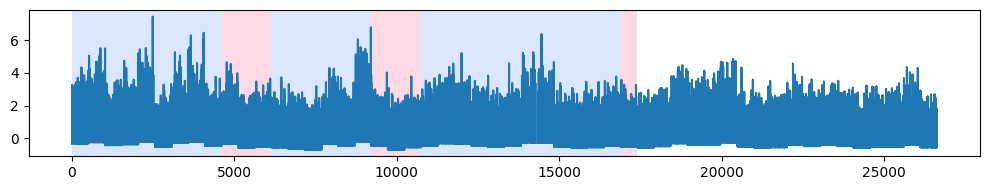

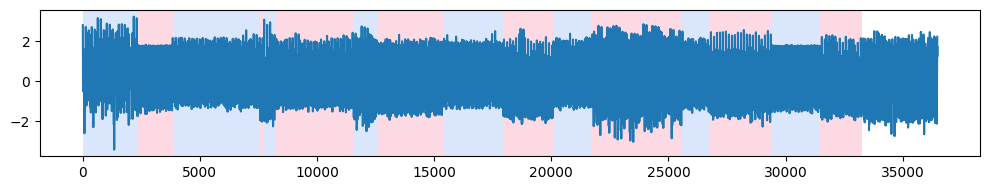

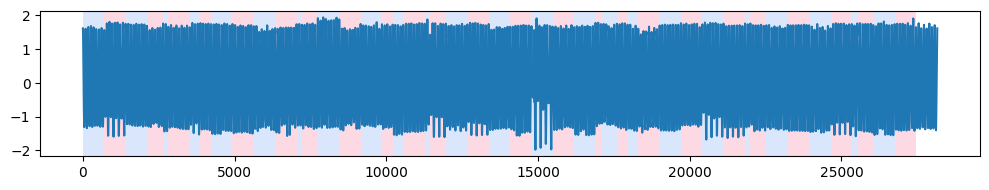

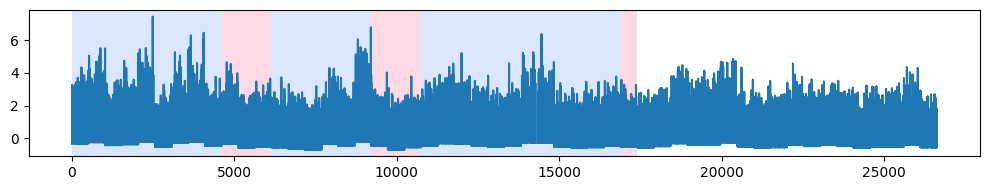

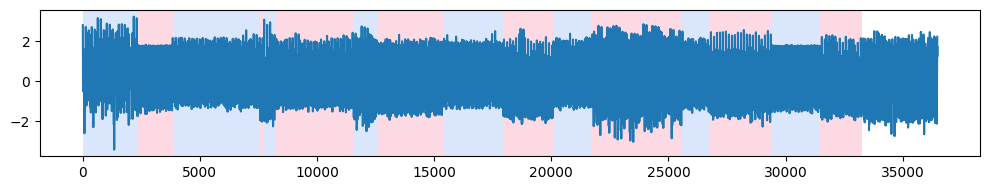

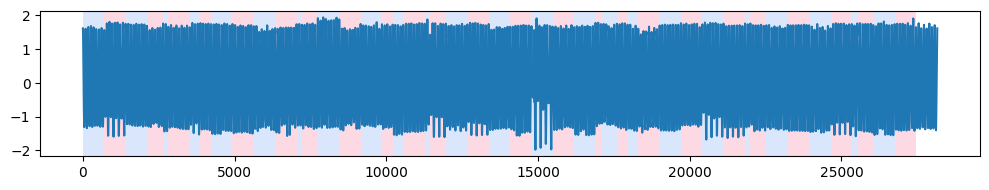

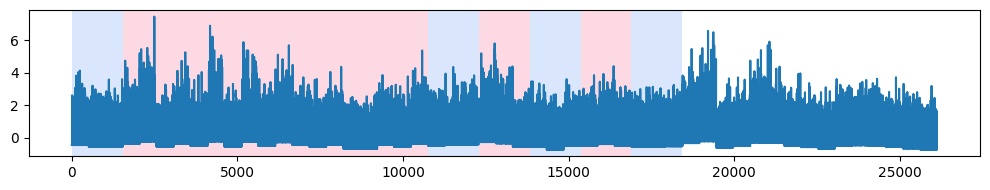

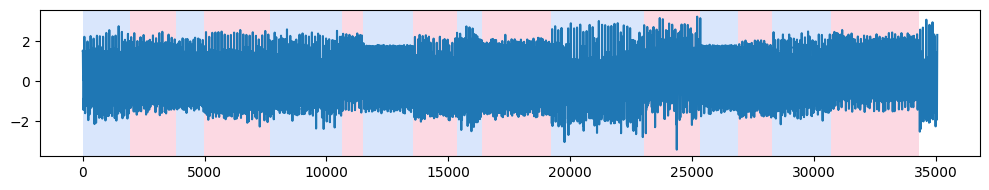

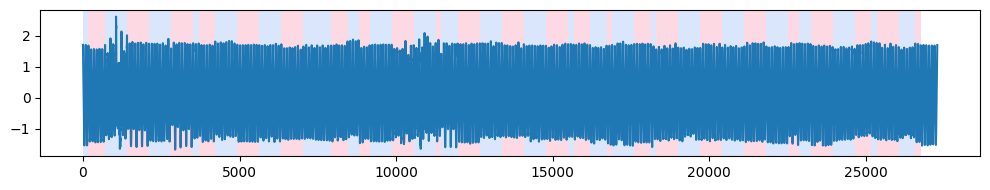

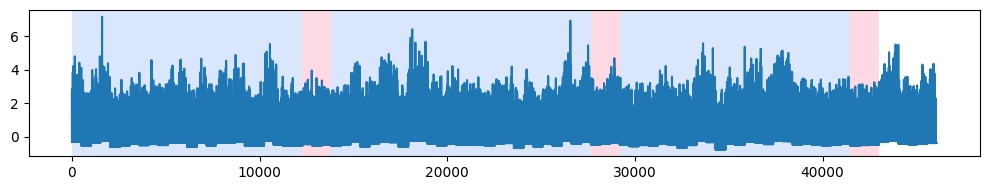

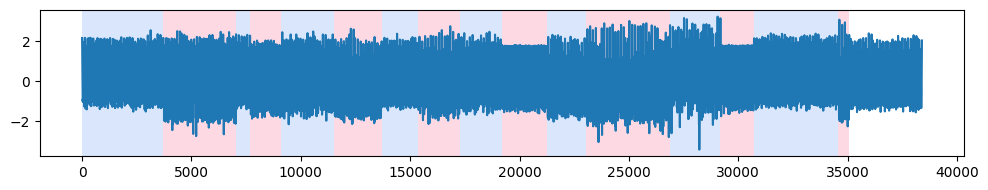

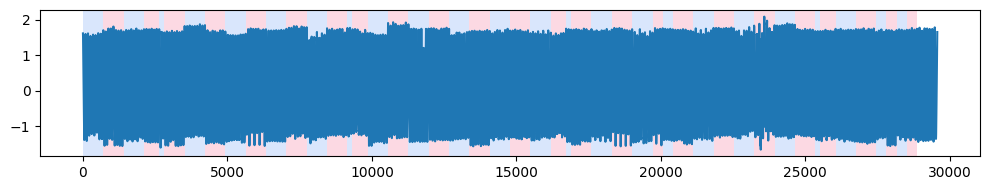

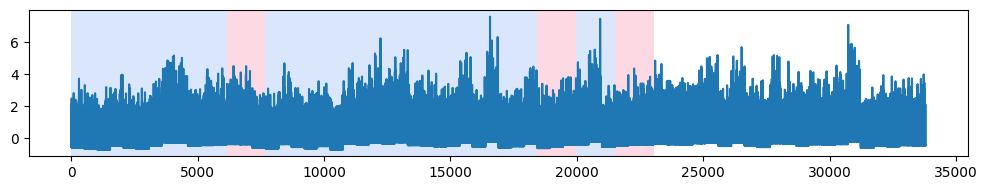

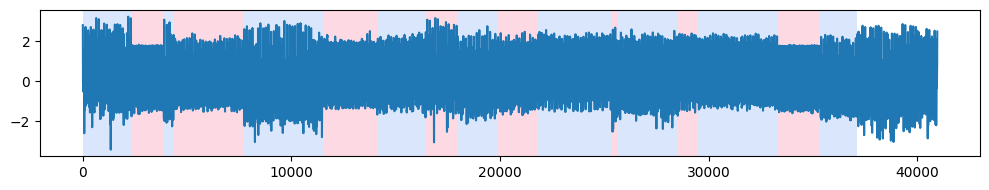

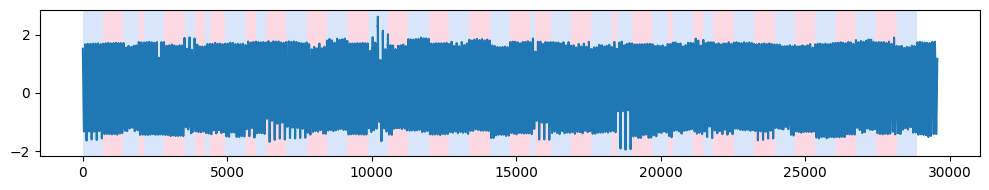

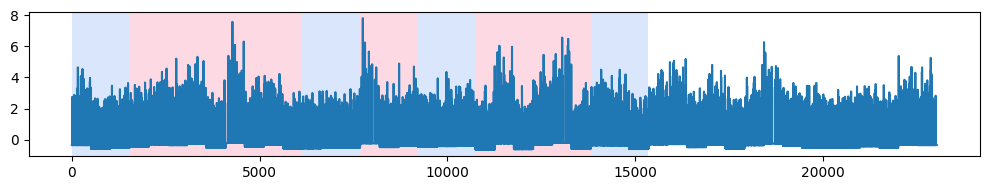

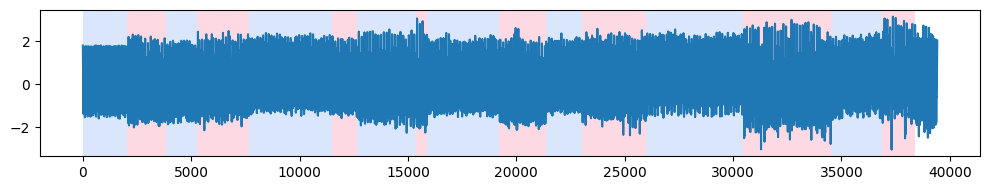

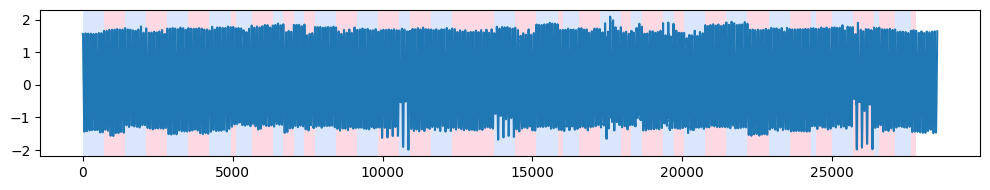

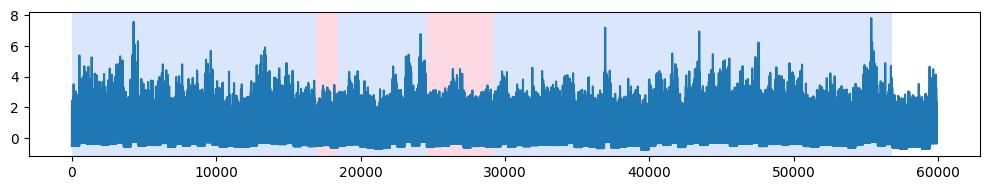

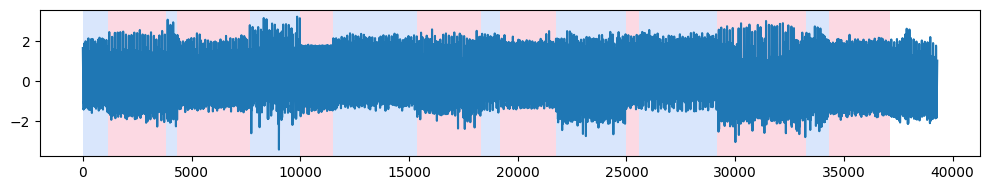

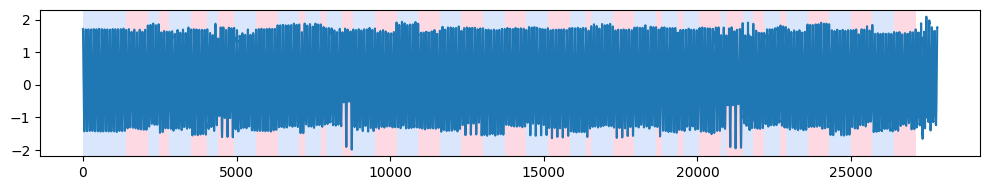

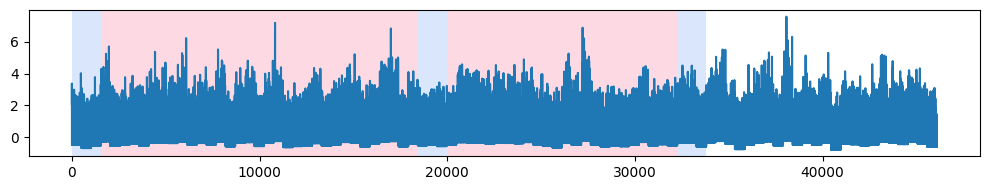

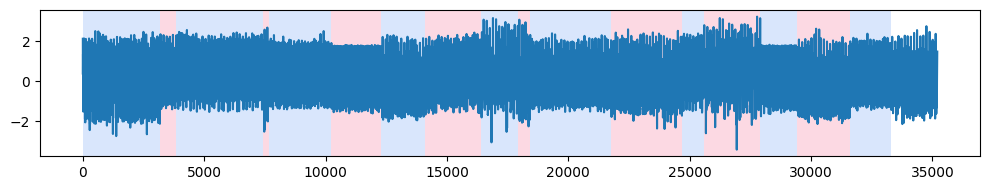

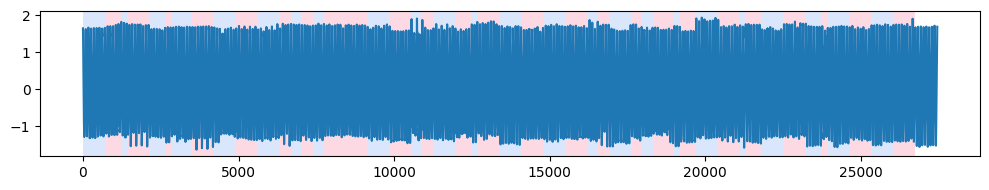

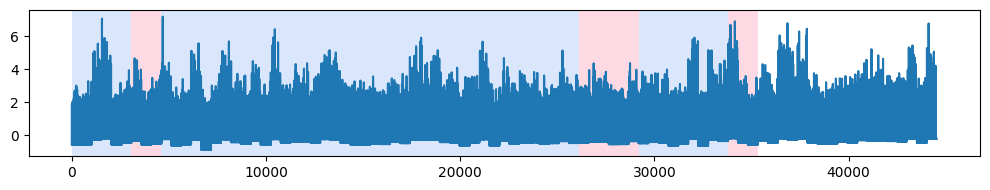

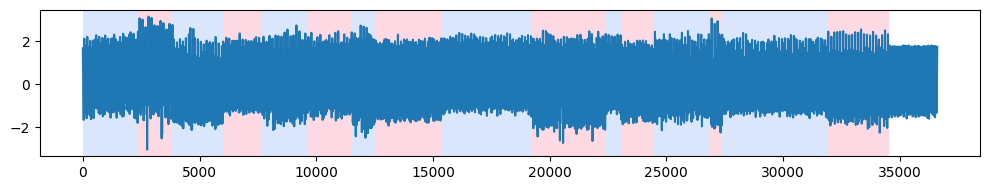

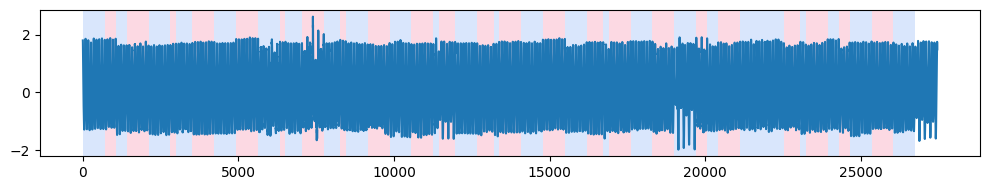

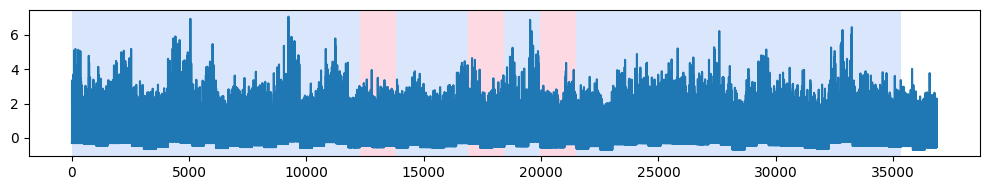

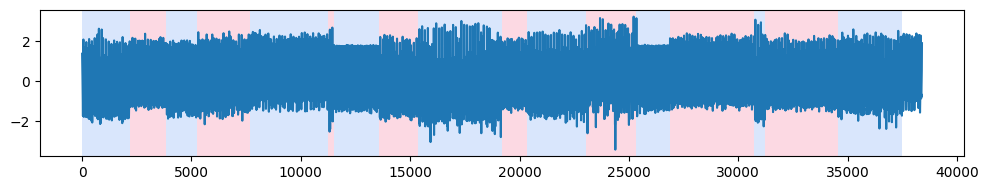

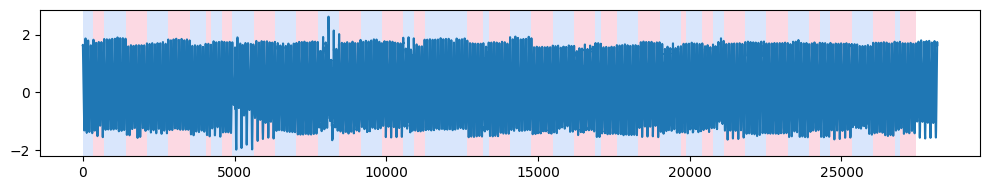

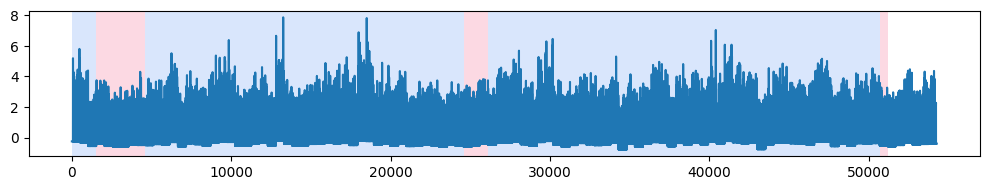

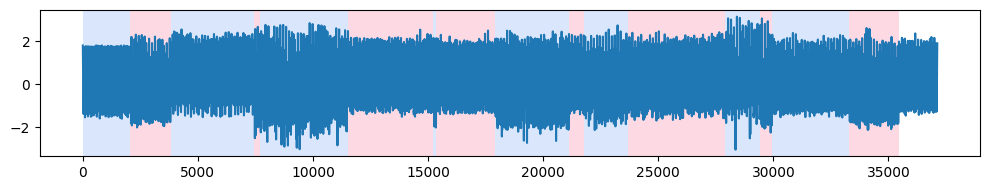

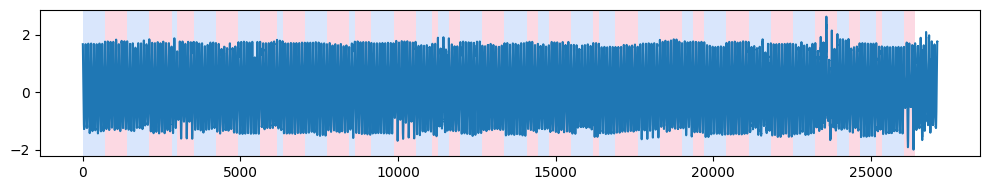

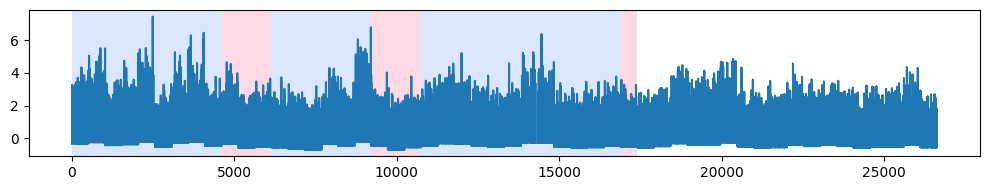

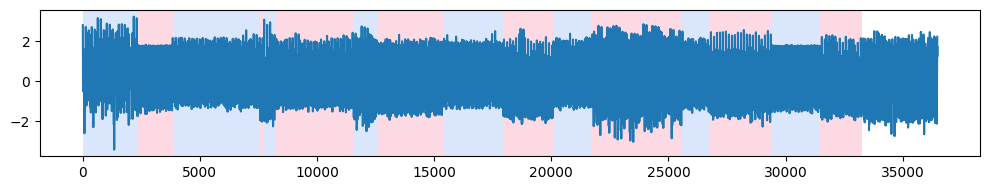

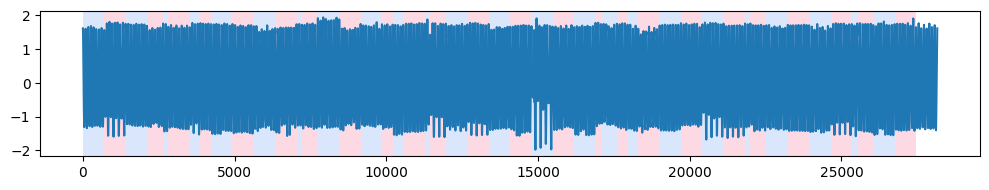

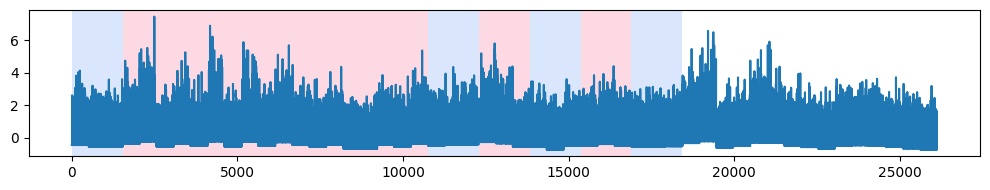

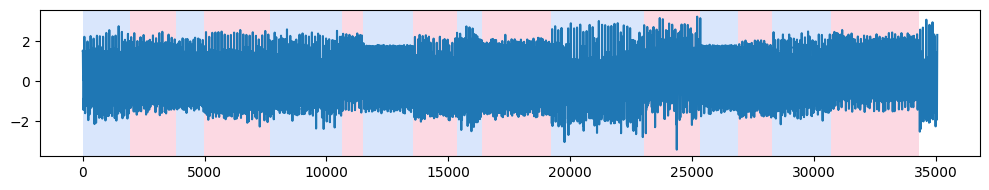

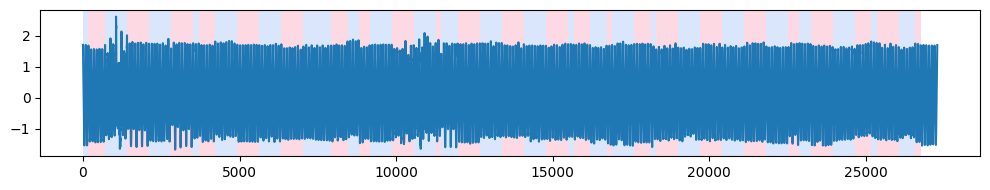

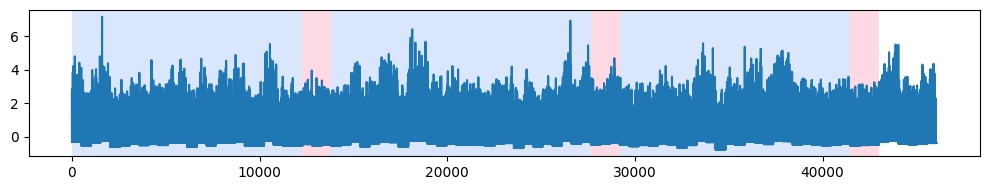

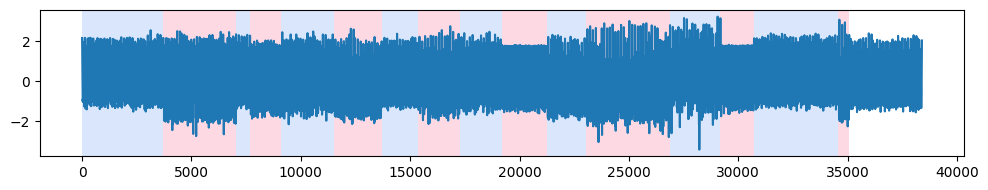

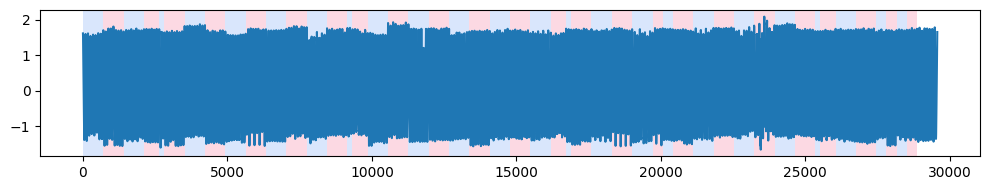

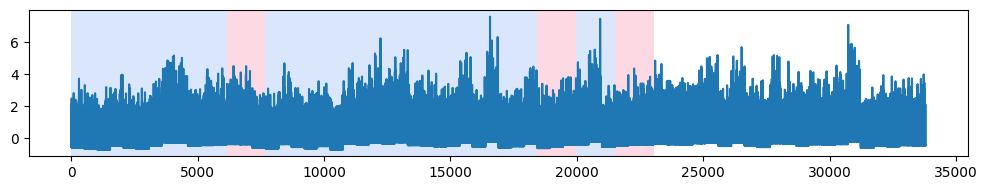

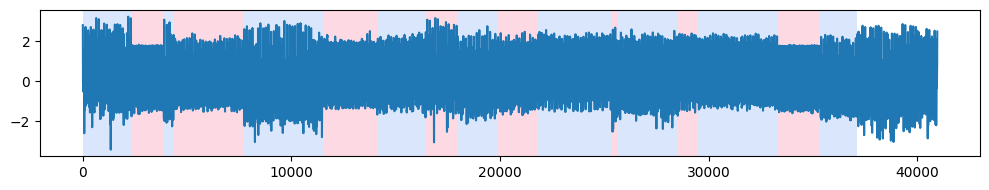

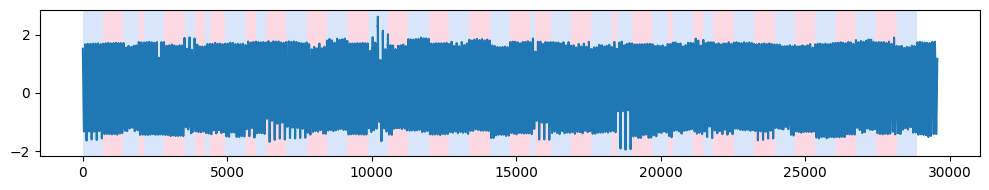

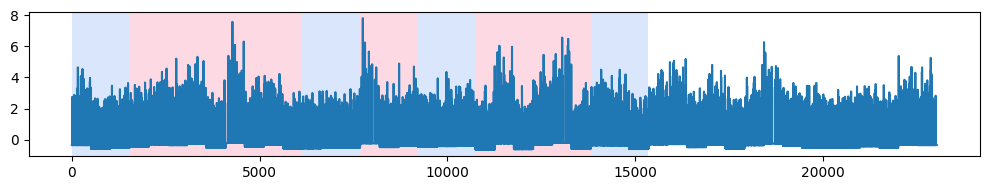

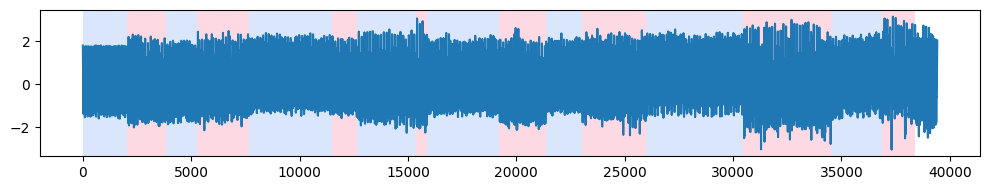

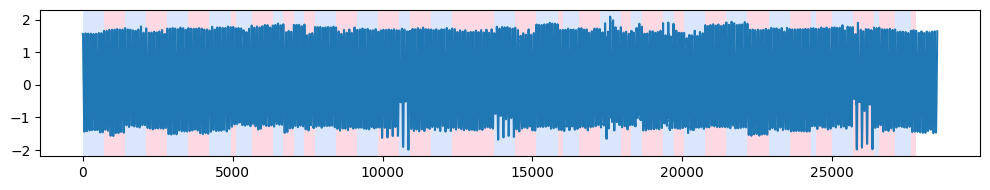

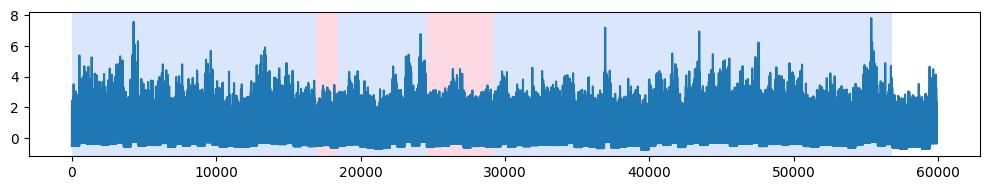

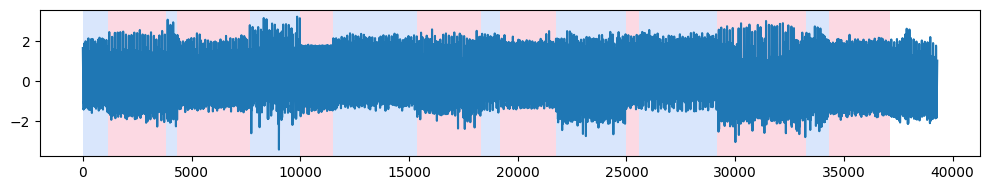

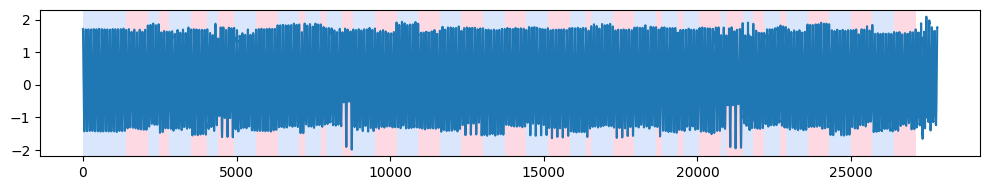

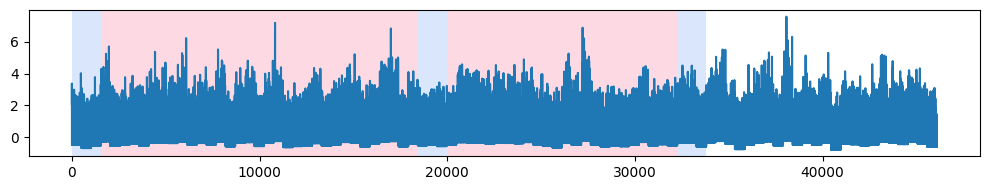

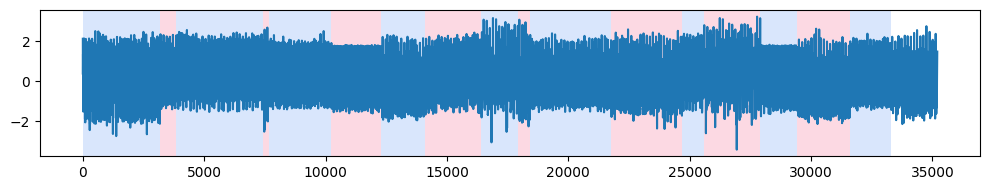

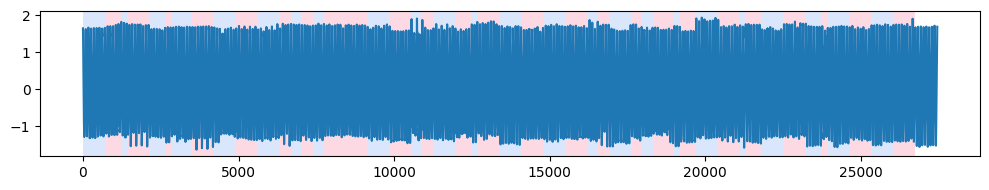

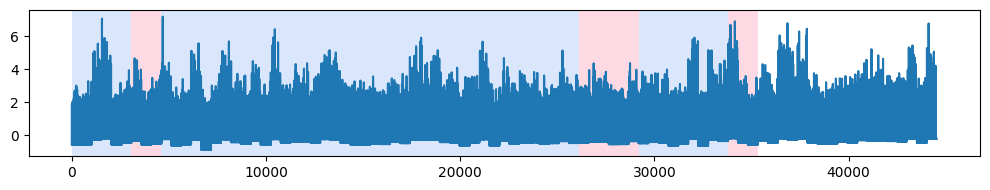

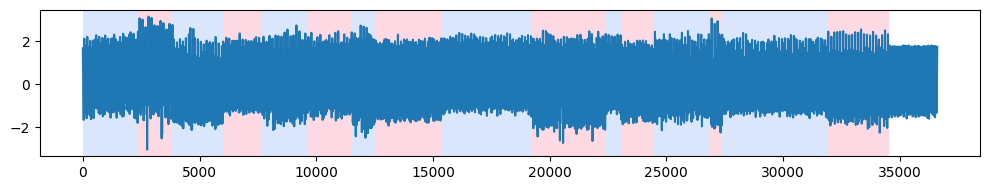

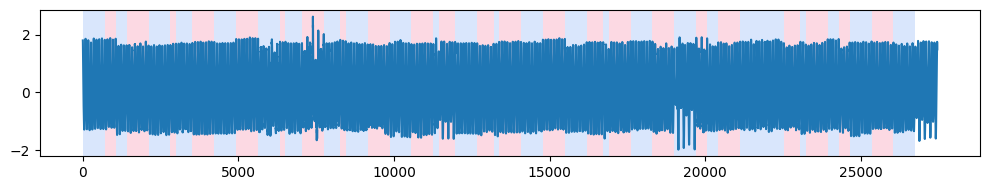

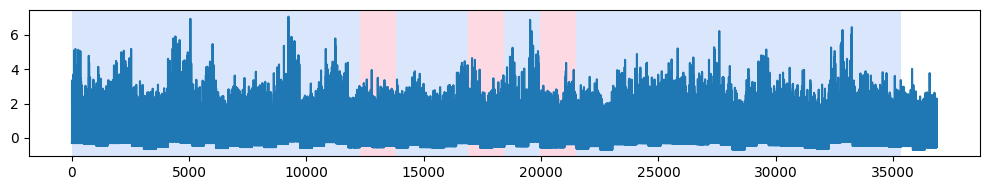

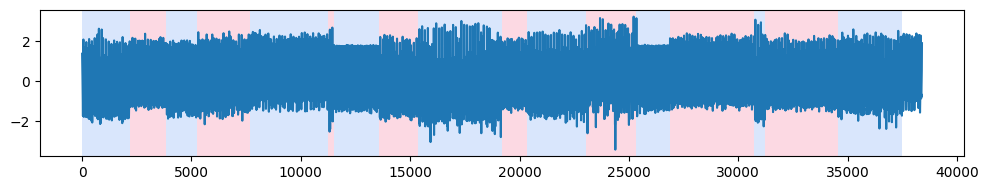

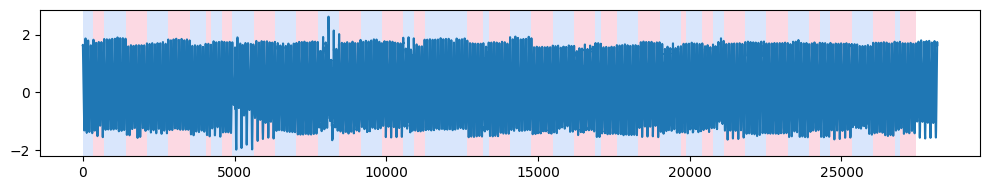

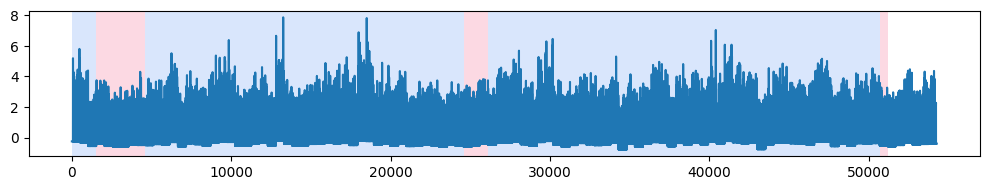

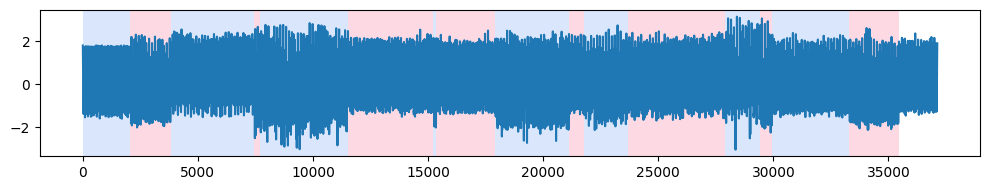

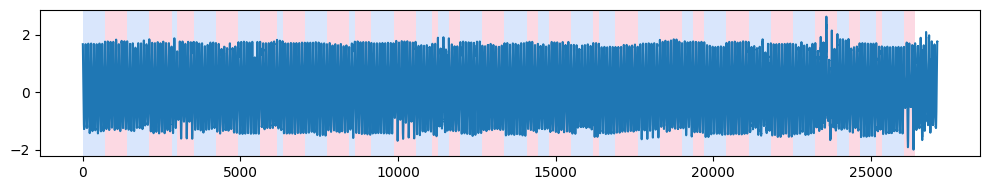

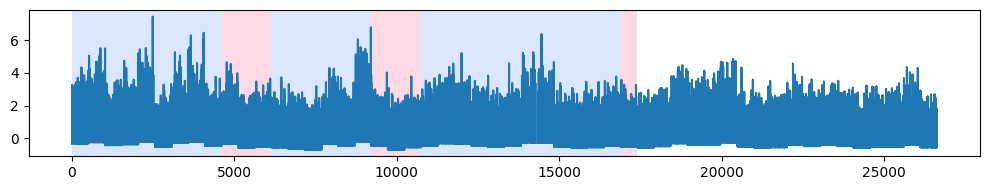

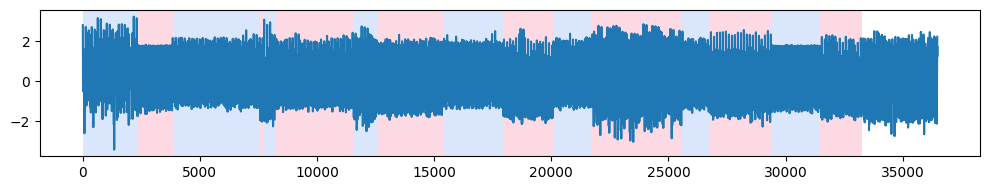

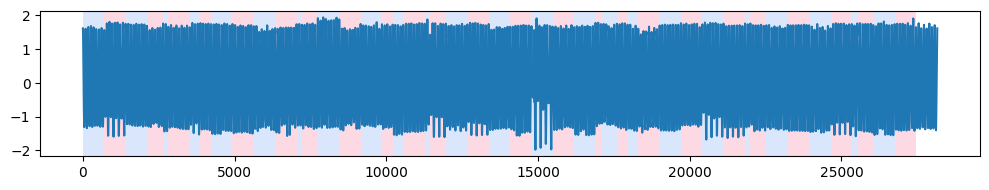

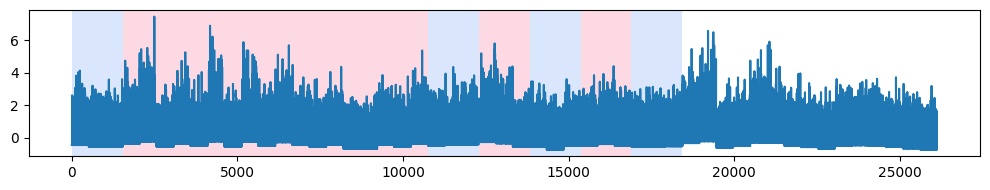

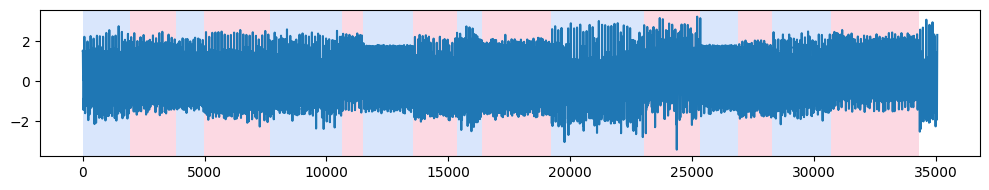

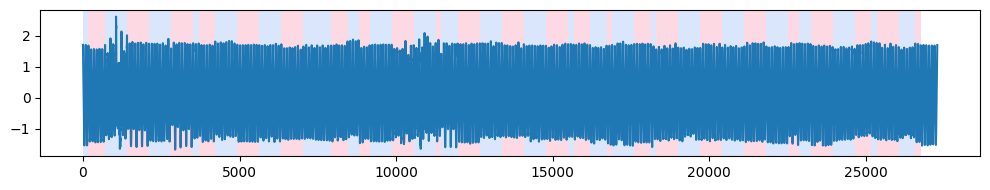

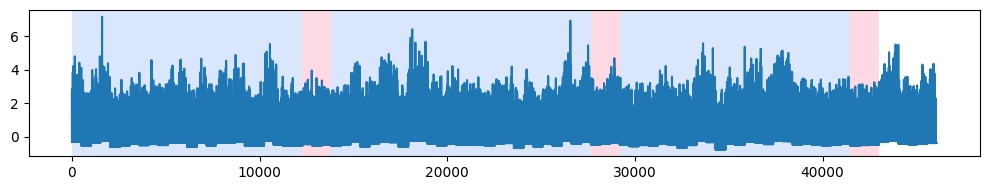

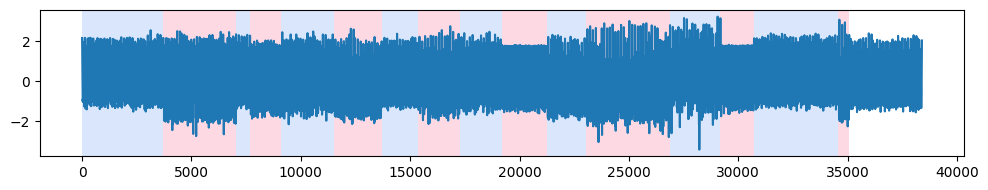

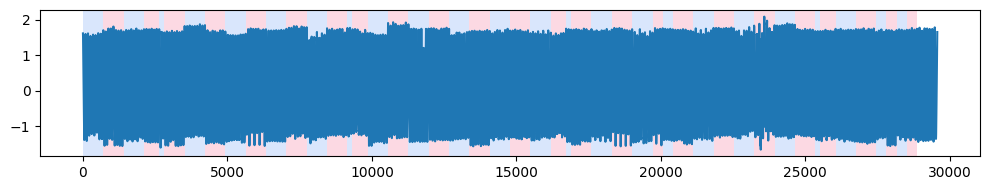

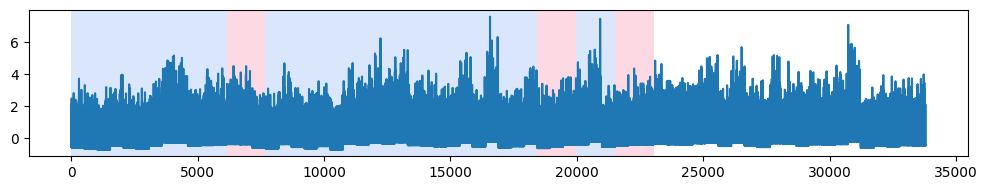

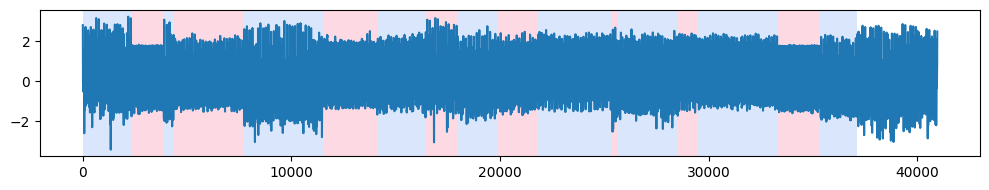

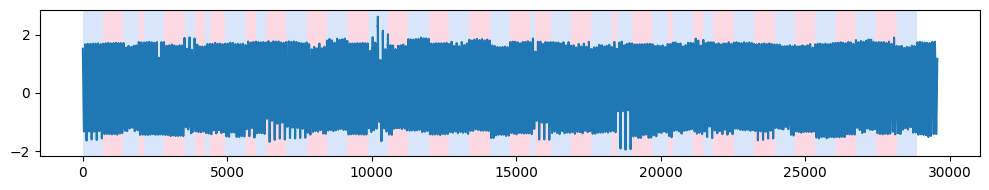

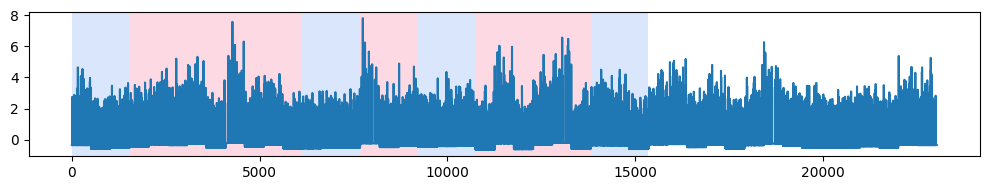

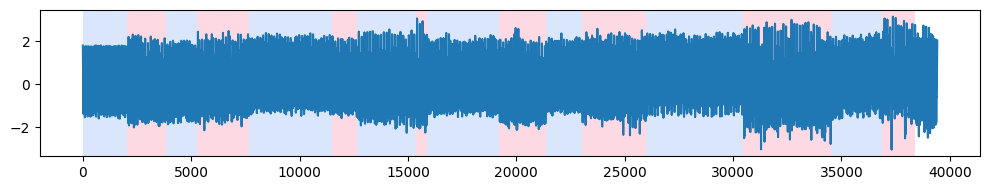

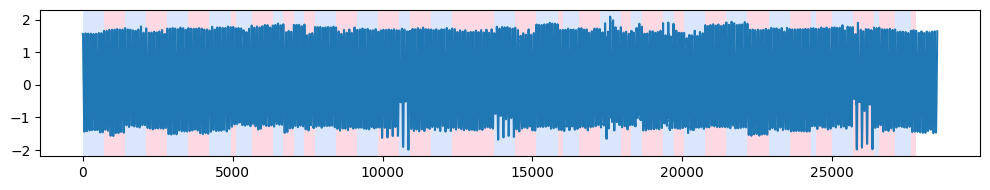

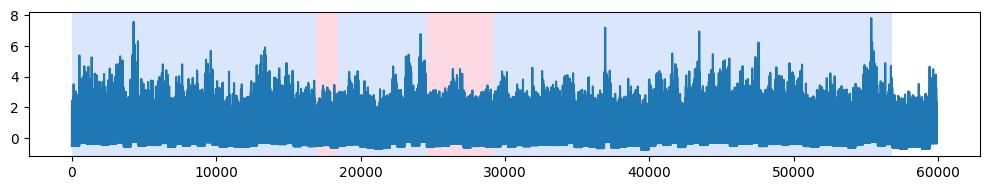

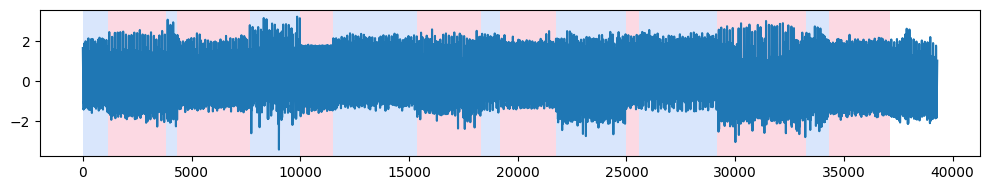

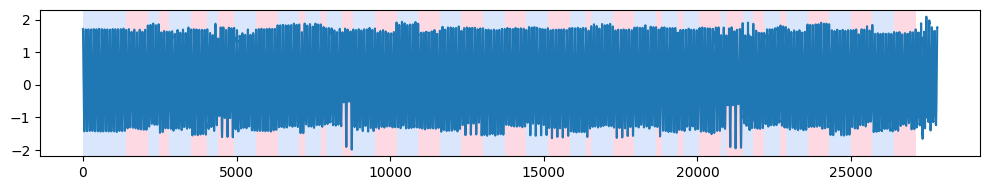

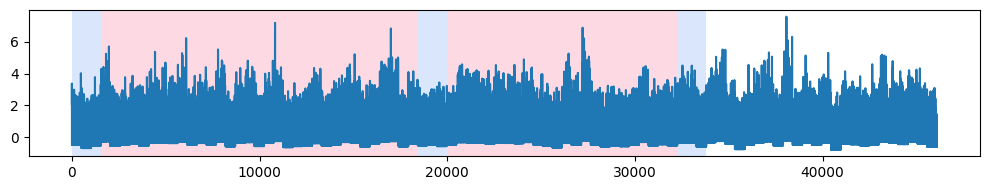

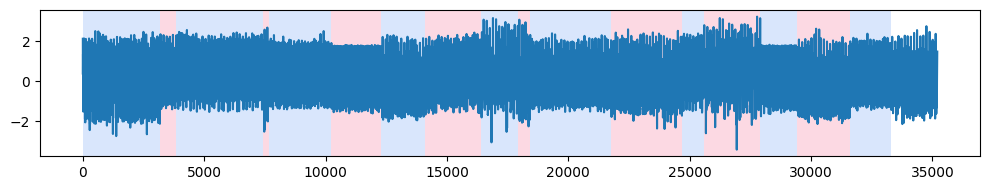

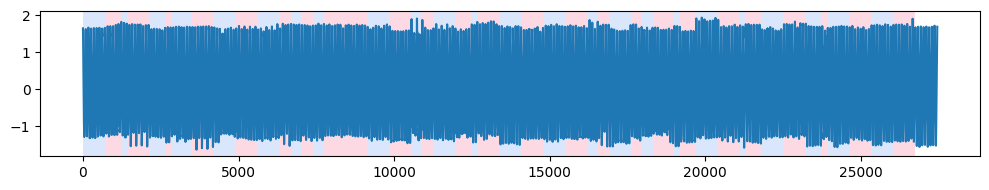

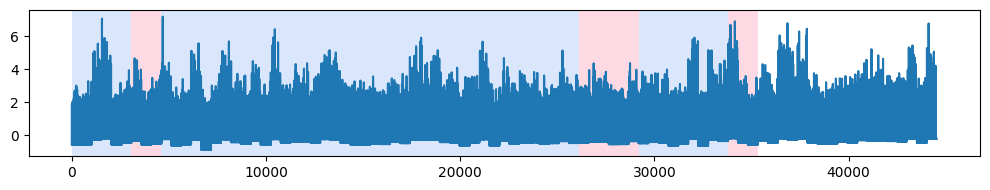

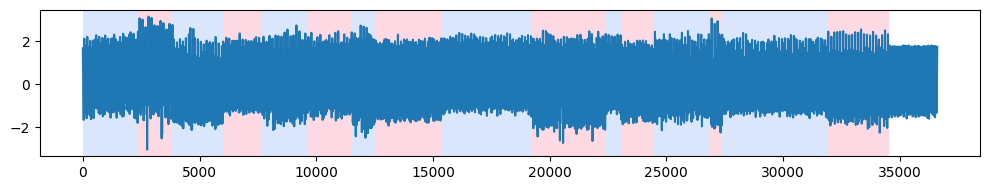

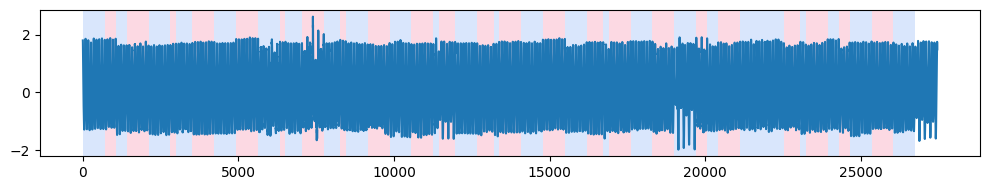

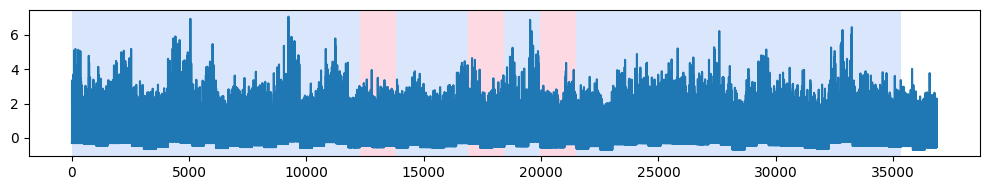

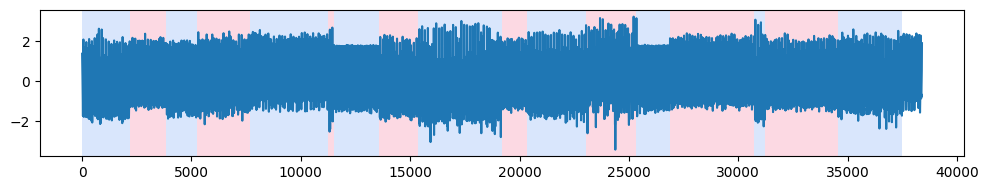

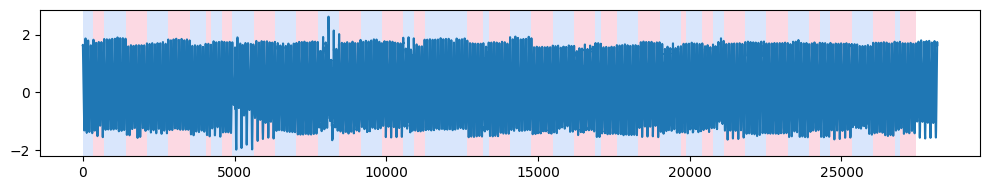

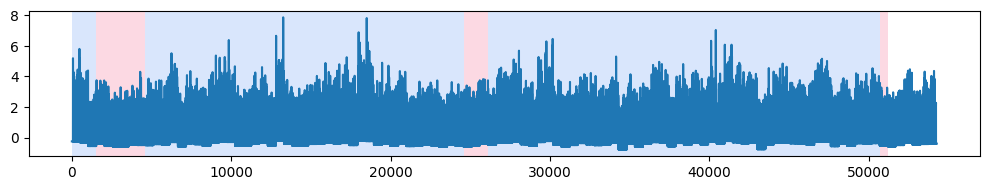

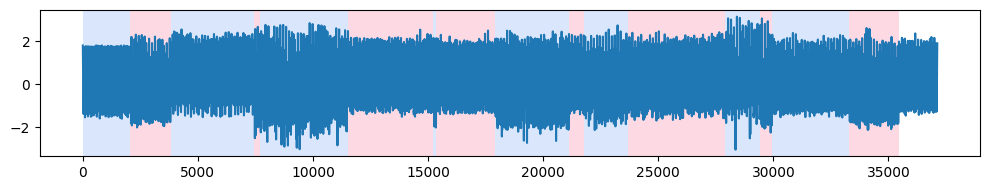

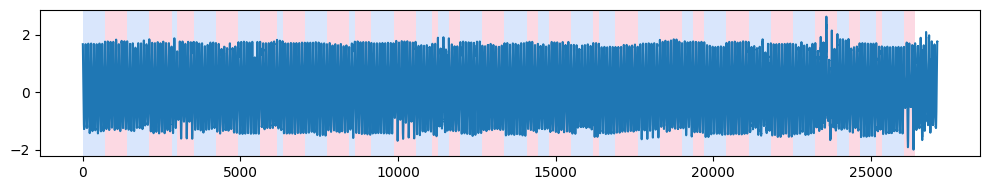

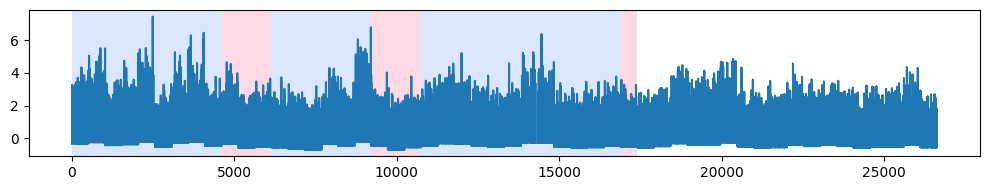

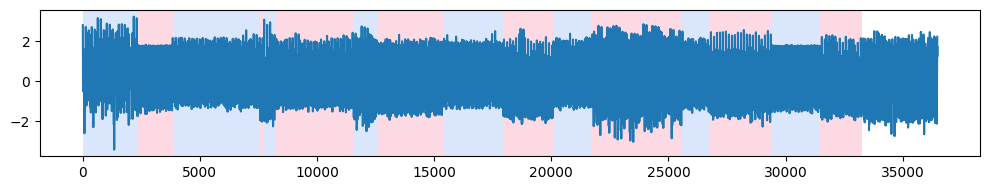

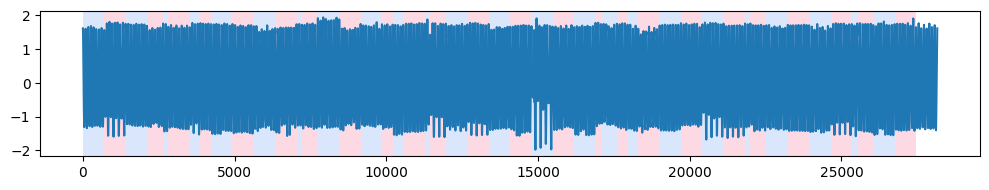

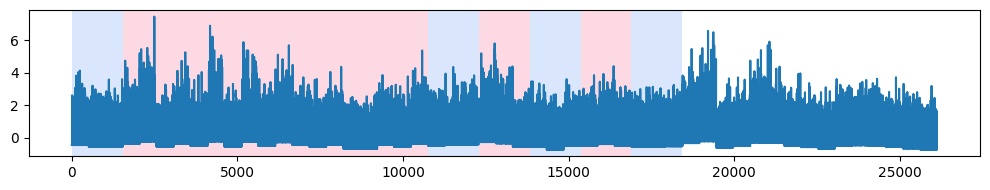

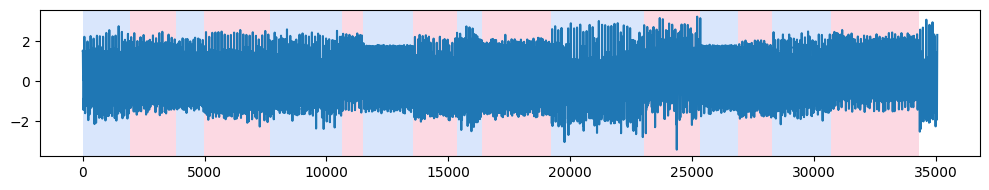

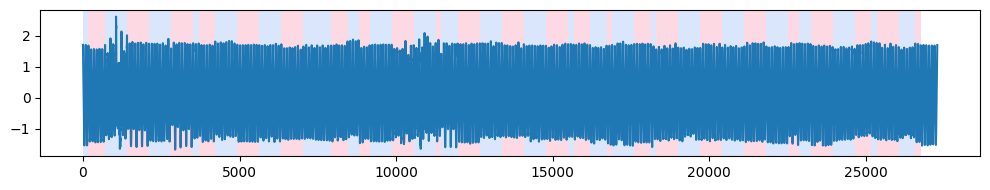

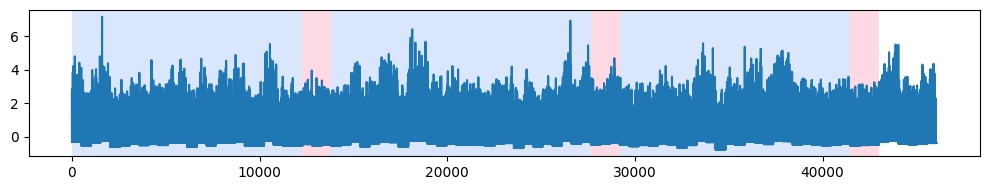

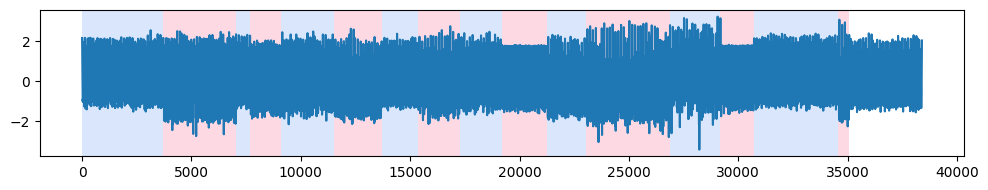

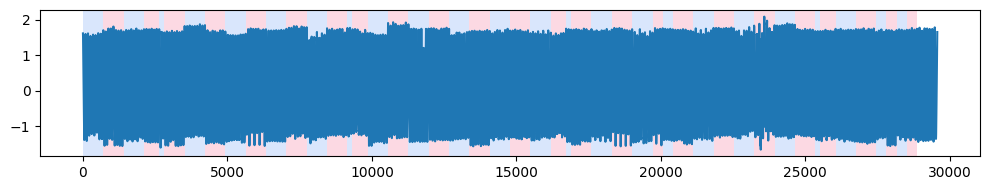

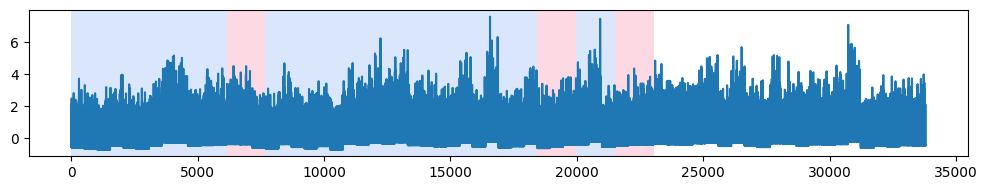

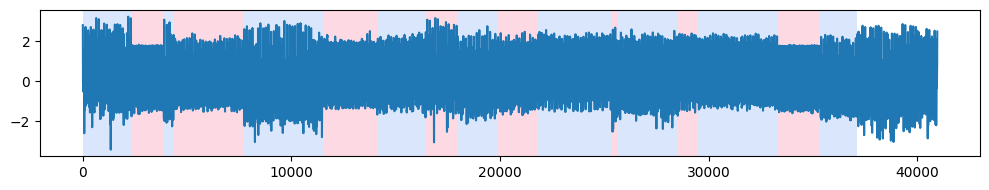

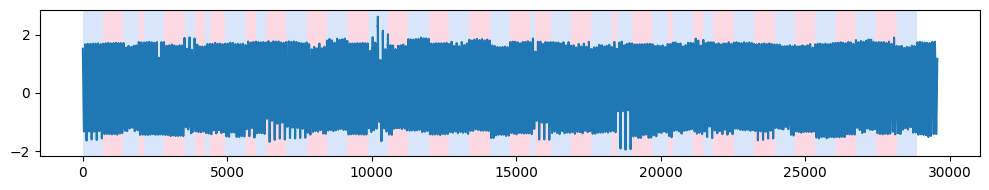

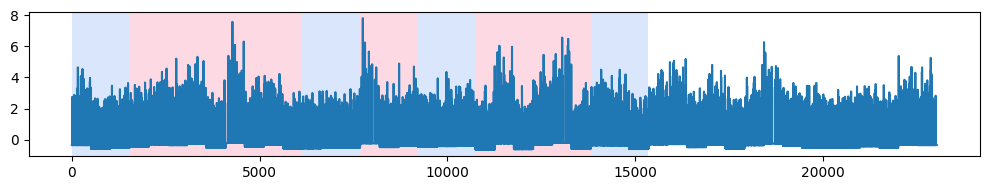

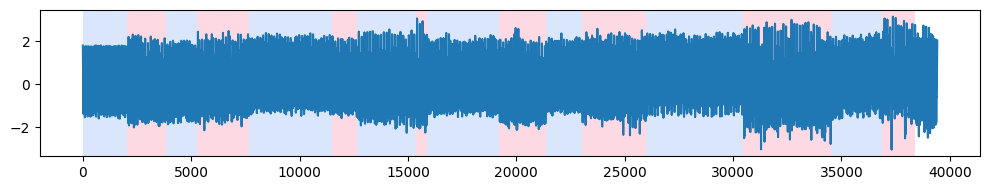

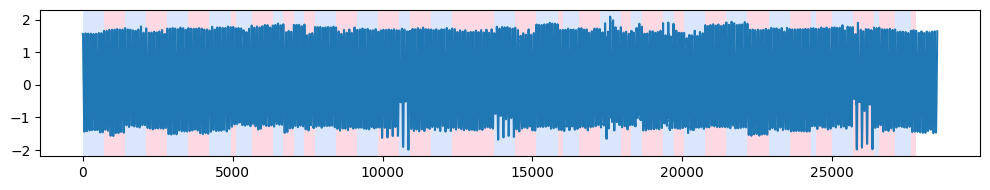

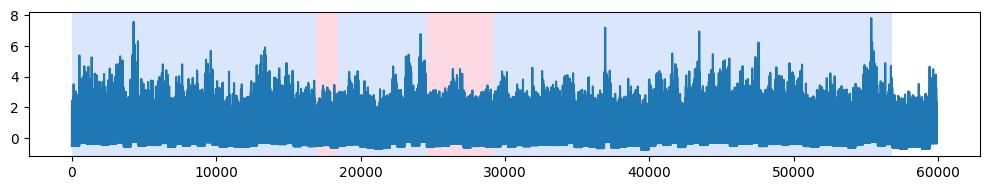

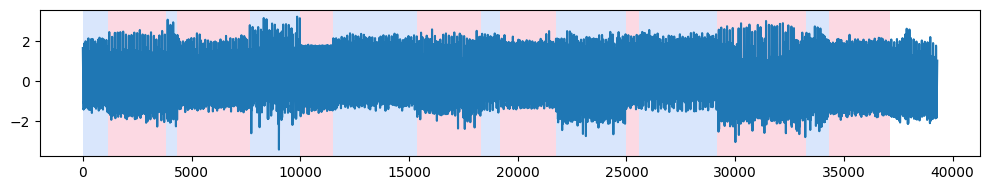

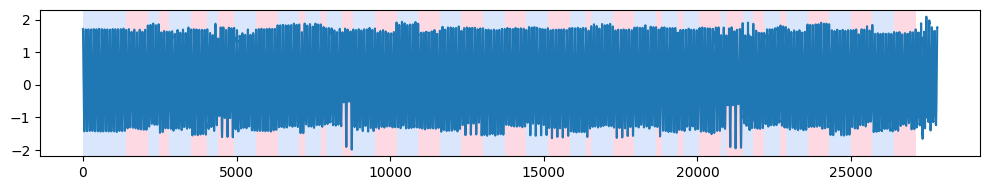

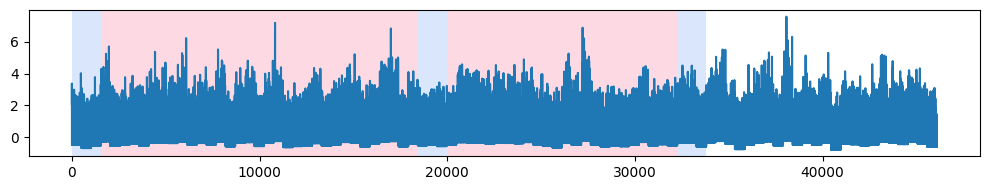

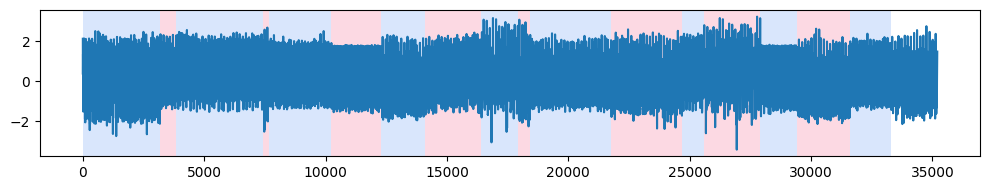

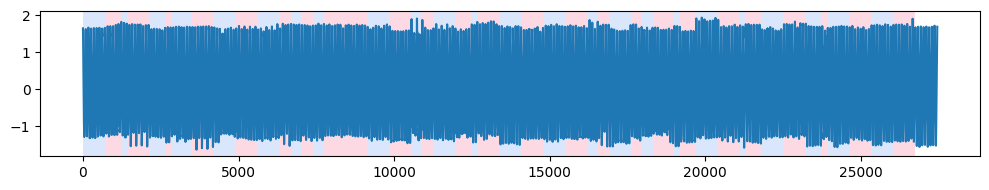

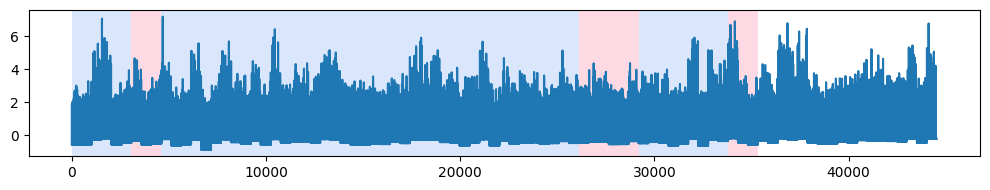

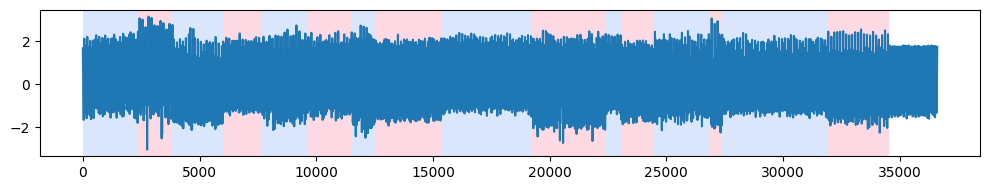

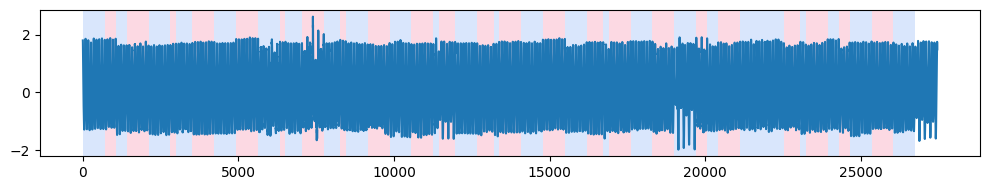

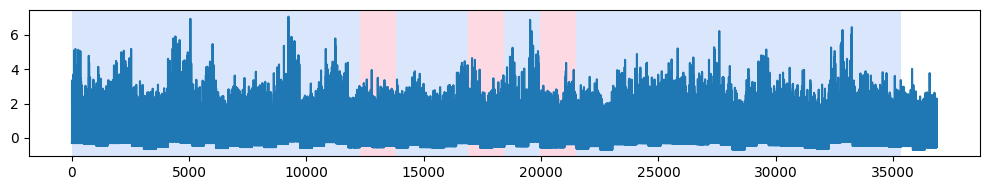

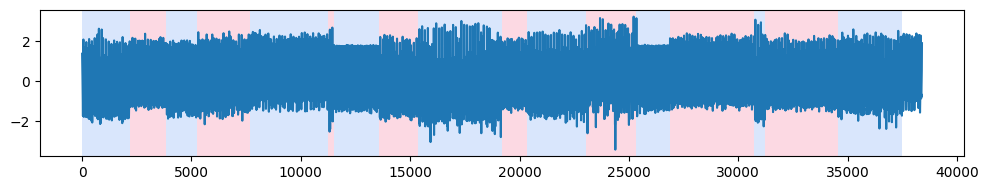

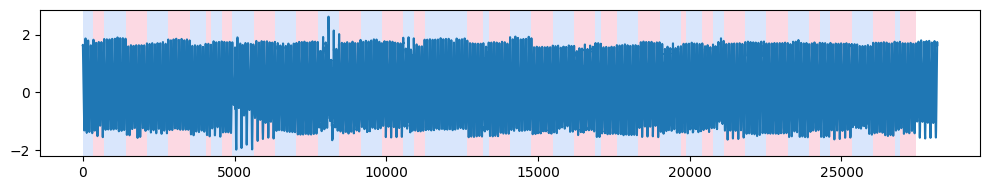

In [26]:
from tqdm import tqdm
import itertools

seed = 40

for ws, itr in tqdm(itertools.product(quartiles, range(10))):
    #print(np.where(quartiles==ws)[0][0])
    BC.call_experiments(seed, itr, int(ws), np.where(quartiles==ws)[0][0])
    seed = 40 + itr



# for x in tqdm(range(10)): 
#     BC.call_experiments(seed,x)
#     seed = 40 + x

# Data Visualization 1 (HeatMap)

In [28]:
out = BC.get_matrix_results()
# out3d = out[:,:,:,0]
print(out.shape)

(10, 7, 4, 10, 4)


In [85]:
data = out 
data = data[:,3,3,:,:]
print(data.shape)
result = np.mean(data, axis=1)

# Sprawdź kształt wynikowej tablicy
print(result.shape)
print(result)

(10, 10, 4)
(10, 4)
[[0.562844   0.59873349 0.53070707 0.14246032]
 [0.11003835 0.20008132 0.24004741 0.28234432]
 [0.40556375 0.38636364 0.35906205 0.07579365]
 [0.19165436 0.37511544 0.33857143 0.37261905]
 [0.63718147 0.53220779 0.2274269  0.05882353]
 [0.06193205 0.19151299 0.32290464 0.91965812]
 [0.32937785 0.59275227 0.64550019 0.44716135]
 [0.63595723 0.60838384 0.45838384 0.15833333]
 [0.25829271 0.47469308 0.56858586 0.58071429]
 [0.50841536 0.4157658  0.26773045 0.06328573]]


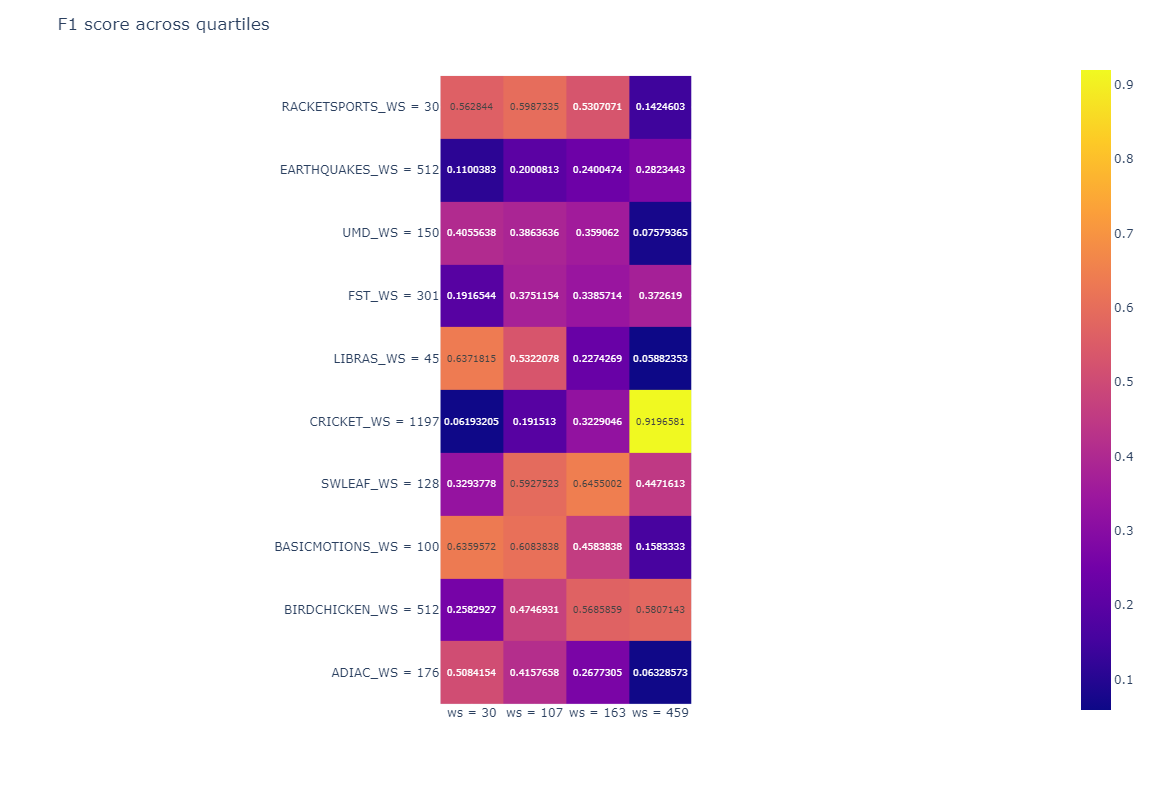

In [86]:
import plotly.express as px

fig = px.imshow(result, text_auto=True,  width=1200, height=800)

RACKETSPORTS_WS = 30
EARTHQUAKES_WS = 512
UMD_WS = 150
FST_WS = 301
LIBRAS_WS = 45
CRICKET_WS = 1197
SWLEAF_WS = 128
BASICMOTIONS_WS = 100
BIRDCHICKEN_WS = 512
ADIAC_WS = 176

x_labels = ['ws = 30', 'ws = 107', 'ws = 163','ws = 459' ]
y_labels = ['RACKETSPORTS_WS = 30', 'EARTHQUAKES_WS = 512', 'UMD_WS = 150','FST_WS = 301','LIBRAS_WS = 45','CRICKET_WS = 1197','SWLEAF_WS = 128' , 'BASICMOTIONS_WS = 100',
           'BIRDCHICKEN_WS = 512', 'ADIAC_WS = 176'
           ]

# Aktualizacja etykiet osi X
fig.update_xaxes(
    tickvals=[0, 1, 2 , 3],  # Wartości na osi X, odpowiadające indeksom
    ticktext=x_labels    # Teksty etykiet dla osi X
)

# Aktualizacja etykiet osi Y
fig.update_yaxes(
    tickvals=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],  # Wartości na osi Y, odpowiadające indeksom
    ticktext=y_labels    # Teksty etykiet dla osi Y
)
fig.update_layout(
    title='F1 score across quartiles')
fig.show()

# Data visualiztaion 2 (3d scatter: Fluss across diffrent iterations of experiments)

In [90]:
result = np.max(data, axis=2)

# Sprawdzenie kształtu wynikowej tablicy
print(result.shape)
print(result)

(10, 10)
[[0.66666667 0.72727273 0.61538462 0.58823529 0.625      0.72727273
  0.66666667 0.6        0.72727273 0.72727273]
 [0.5        0.31578947 0.44444444 0.23076923 0.30769231 0.5
  0.26086957 0.2        0.42857143 0.5       ]
 [0.6        0.47619048 0.47058824 0.4        0.6        0.66666667
  0.41666667 0.44444444 0.66666667 0.44444444]
 [0.5        0.66666667 0.53333333 0.57142857 0.54545455 0.4
  0.66666667 0.5        0.44444444 0.4       ]
 [0.64864865 0.64864865 0.61111111 0.64864865 0.62857143 0.61111111
  0.64864865 0.66666667 0.64864865 0.61111111]
 [1.         1.         0.76923077 1.         0.88888889 0.76923077
  1.         1.         1.         0.76923077]
 [0.58823529 0.58064516 0.6875     0.6875     0.6875     0.66666667
  0.77419355 0.54545455 0.70967742 0.58823529]
 [0.75       0.75       0.5        0.71428571 0.58823529 0.75
  0.66666667 0.90909091 0.6        0.66666667]
 [0.5        0.8        1.         0.4        0.4        0.4
  0.5        0.66666667 0.8571

In [91]:

import plotly.graph_objects as go

z_data = result
# Generowanie wartości dla osi x i y
x_data = np.arange(z_data.shape[1])  # Oś X - kolumny
y_data = np.arange(z_data.shape[0])  # Oś Y - wiersze

# Tworzenie siatki wartości
X, Y = np.meshgrid(x_data, y_data)
Z = z_data.flatten()  # Wartości Z do punktów 3D

# Spłaszczanie X i Y, aby pasowały do spłaszczonego Z
X_flat = X.flatten()
Y_flat = Y.flatten()

# Tworzenie wykresu punktowego 3D
fig = go.Figure(data=[go.Scatter3d(
    x=X_flat,
    y=Y_flat,
    z=Z,
    mode='markers',
    marker=dict(
        size=5,  # Rozmiar markerów
        color=Y_flat,  # Kolor markerów na podstawie wartości X
        colorscale='Viridis',  # Skala kolorów
        colorbar=dict(title='Y Value'),  # Dodanie paska kolorów
        opacity=0.8
    )
)])

# Dostosowanie rozmiaru wykresu
fig.update_layout(
    title='Fluss F1 score across iterations',
    scene=dict(
        xaxis=dict(
            title='iteration number',
            dtick=1  # Ustawienie odstępu co 1 na osi X
        ),
        yaxis=dict(
            title='dataset number',
            dtick=1  # Ustawienie odstępu co 1 na osi Y
        ),
        zaxis=dict(
            title='Metric Value',
            dtick=0.1  # Ustawienie odstępu co 1 na osi Z (jeśli ma sens, np. dla liczb całkowitych)
        )),
    width=800,  # Szerokość wykresu w pikselach
    height=700  # Wysokość wykresu w pikselach
)

# Wyświetlenie wykresu
fig.show()

# Data visualization 3 (window vs binseg vs bottomup vs fluss)

In [88]:
data3 = out 
data3 = data3[:,3,:,:,:]

result = np.max(data3, axis=3)
result = np.mean(result, axis=2)

# Sprawdź kształt wynikowej tablicy
print(result.shape)
print(result)

(10, 4)
[[0.35892857 0.40357143 0.01428571 0.66710442]
 [0.26238095 0.25190476 0.24571429 0.36881365]
 [0.19261905 0.24690476 0.36571429 0.51856676]
 [0.26857143 0.04       0.21428571 0.52279942]
 [0.35714286 0.40714286 0.39285714 0.63718147]
 [0.29       0.77       0.775      0.91965812]
 [0.27058824 0.         0.16544118 0.65156079]
 [0.71238095 0.78238095 0.78238095 0.68949453]
 [0.42333333 0.05       0.20333333 0.64126984]
 [0.34714428 0.07287958 0.10626086 0.50927577]]


In [89]:

import plotly.graph_objects as go

z_data = result
# Generowanie wartości dla osi x i y
x_data = np.arange(z_data.shape[1])  # Oś X - kolumny
y_data = np.arange(z_data.shape[0])  # Oś Y - wiersze

# Tworzenie siatki wartości
X, Y = np.meshgrid(x_data, y_data)
Z = z_data.flatten()  # Wartości Z do punktów 3D

# Spłaszczanie X i Y, aby pasowały do spłaszczonego Z
X_flat = X.flatten()
Y_flat = Y.flatten()

# Tworzenie wykresu punktowego 3D
fig = go.Figure(data=[go.Scatter3d(
    x=X_flat,
    y=Y_flat,
    z=Z,
    mode='markers',
    marker=dict(
        size=5,  # Rozmiar markerów
        color=X_flat,  # Kolor markerów na podstawie wartości X
        colorscale='Viridis',  # Skala kolorów
        colorbar=dict(title='X Value'),  # Dodanie paska kolorów
        opacity=0.8
    )
)])

# Dostosowanie rozmiaru wykresu
fig.update_layout(
    title='F1 score',
 scene=dict(
        xaxis=dict(
            title='algorithm number',
            dtick=1  # Ustawienie odstępu co 1 na osi X
        ),
        yaxis=dict(
            title='dataset number',
            dtick=1  # Ustawienie odstępu co 1 na osi Y
        ),
        zaxis=dict(
            title='Metric Value',
            dtick=0.1  # Ustawienie odstępu co 1 na osi Z (jeśli ma sens, np. dla liczb całkowitych)
        )),
    width=800,  # Szerokość wykresu w pikselach
    height=700  # Wysokość wykresu w pikselach
)

# Wyświetlenie wykresu
fig.show()